# <center> 【Kaggle】Telco Customer Churn 电信用户流失预测案例

## <font face="仿宋">第三部分导读

&emsp;&emsp;<font face="仿宋">在案例的第二部分中，我们详细介绍了常用特征转化方法，其中有些是模型训练之必须，如自然数编码、独热编码，而有些方法则是以提高数据质量为核心、在大多数时候都是作为模型优化的备选方法，如连续变量分箱、数据标准化等。当然，在此之后，我们首先尝试构建一些可解释性较强的模型来进行用户流失预测，即采用逻辑回归和决策树模型来进行预测，并同时详细介绍了两种模型在实战中的调优技巧，在最终模型训练完成后，我们也重点讨论了关于两种可解释性模型建模结果的解释方法。

&emsp;&emsp;<font face="仿宋">从理论上来说，树模型的判别能力是要强于逻辑回归的，但在上一节最后的建模结果中我们发现两个模型的建模并无显著差别，预测准确率都维持在79%-80%之间，这或许说明很多逻辑回归无法正确判别的样本决策树模型也无法判别，据此我们推测，这是一个“入门容易、精通较难”的数据集。当然，如果我们进一步尝试其他“更强”的集成学习算法，如随机森林、XGB、CatBoost等，在当前数据集上的建模结果和逻辑回归也并无太大差异，因此我们亟需通过特征工程方法进一步提升数据集质量，进而提升最终模型效果。

&emsp;&emsp;<font face="仿宋">当然，哪怕是复杂模型在当前数据集上表现出了更好的效果，采用特征工程方法提升数据质量仍是优化建模结果必不可少的部分，正如时下流行的描述那样，“数据质量决定模型上界，而建模过程只是不断逼近这个上界”，特征工程中的一系列提高数据质量的方法、无论是在工业界实践中还是各大顶级竞赛里，都已然成了最为重要的提升模型效果的手段。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gwllgk4wgqj31hr0u0wh4.jpg" alt="image-20211112170651500" style="zoom:15%;" />

&emsp;&emsp;<font face="仿宋">不过，所谓的通过特征工程方法提高数据质量，看似简单但实际操作起来却并不容易。其难点并不在于其中具体操作方法的理解，至少相比机器学习算法原理，特征工程的很多方法并不复杂，特征工程的最大难点在于配合模型与数据进行方法选择、以及各种方法的工程化部署实现。一方面，特征工程方法众多，需要根据实际情况“因地制宜”，但数据的情况千变万化，很多时候需要同时结合数据探索结论、建模人员自身经验以及对各种备选方法的熟悉程度，才能快速制定行之有效的特征工程策略；另一方面，很多特征工程方法不像机器学习算法有现成的库可以直接调用，很多方法、尤其是一些围绕当前数据集的定制方法，需要自己手动实现，而这个过程就对建模人员本身的代码编写能力及工程部署能力提出了更高的要求。总而言之，特征工程是一个实践高度相关的技术，这也是为何课程会在介绍案例的过程中同步介绍特征工程常用方法的原因。

&emsp;&emsp;<font face="仿宋">当然，从宽泛的角度来看，所有围绕数据集的数据调整工作都可以看成是特征工程的一部分，包括此前介绍的缺失值填补、数据编码、特征变换等，这些方法其实都能一定程度提升数据质量，而本节开始，我们将花费一整节的时间来讨论另一类特征工程方法：特征衍生与特征筛选。而该方法通过创建更多特征来提供更多捕捉数据规律的维度，从而提升模型效果。当然特征衍生也是目前公认的最为有效的、能够显著提升数据集质量方法。

# <center>Part 3.特征衍生与特征筛选

&emsp;&emsp;本阶开始我们将重点讨论特征工程中的特征衍生与特征筛选方法，并借此进一步提升模型效果。首先需要将此前的操作中涉及到的第三方库进行统一的导入：

In [1]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义模块
from telcoFunc import *

# re模块相关
import inspect, re

其中telcoFunc是自定义的模块，其内保存了此前自定义的函数和类，后续新增的函数和类也将逐步写入其中，telcoFunc.py文件随课件提供，需要将其放置于当前ipy文件同一文件夹内才能正常导入。

&emsp;&emsp;接下来导入数据并执行Part 1中的数据清洗步骤。

In [2]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
 
# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

# 连续字段转化
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

# 缺失值填补
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

# 标签值手动转化 
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

C:\Users\18269\AppData\Local\Temp\ipykernel_5708\4024799725.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
C:\Users\18269\AppData\Local\Temp\ipykernel_5708\4024799725.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [3]:
features = tcc.drop(columns=[ID_col, target]).copy()
labels = tcc['Churn'].copy()

In [4]:
def features_test(new_features,
                  features = features, 
                  labels = labels, 
                  category_cols = category_cols, 
                  numeric_cols = numeric_cols):
    """
    新特征测试函数
    
    :param features: 数据集特征
    :param labels: 数据集标签
    :param new_features: 新增特征
    :param category_cols: 离散列名称
    :param numeric_cols: 连续列名称
    :return: result_df评估指标
    """
    
    # 数据准备
    if type(new_features) == np.ndarray:
        name = 'new_features'
        new_features = pd.Series(new_features, name=name)
    # print(new_features)
    
    features = features.copy()
    category_cols = category_cols.copy()
    numeric_cols = numeric_cols.copy()

    features = pd.concat([features, new_features], axis=1)
    # print(features.columns)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=21)
    
    # 划分连续变量/离散变量
    if type(new_features) == pd.DataFrame:
        for col in new_features:
            if new_features[col].nunique() >= 15:
                numeric_cols.append(col)
            else:
                category_cols.append(col)
    
    else:
        if new_features.nunique() >= 15:
            numeric_cols.append(name)
        else:
            category_cols.append(name)

        
    # print(category_cols)
    # 检验列是否划分完全
    assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

    # 设置转化器流
    logistic_pre = ColumnTransformer([
        ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
        ('num', 'passthrough', numeric_cols)
    ])

    num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

    # 实例化逻辑回归评估器
    logistic_model = logit_threshold(max_iter=int(1e8))

    # 设置机器学习流
    logistic_pipe = make_pipeline(logistic_pre, logistic_model)

    # 设置超参数空间
    logistic_param = [
        {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l1'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['saga']}, 
        {'columntransformer__num':num_pre, 'logit_threshold__penalty': ['l2'], 'logit_threshold__C': np.arange(0.1, 1.1, 0.1).tolist(), 'logit_threshold__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
    ]

    # 实例化网格搜索评估器
    logistic_search = GridSearchCV(estimator = logistic_pipe,
                                   param_grid = logistic_param,
                                   scoring='accuracy',
                                   n_jobs = 12)

    # 输出时间
    s = time.time()
    logistic_search.fit(X_train, y_train)
    print(time.time()-s, "s")

    # 计算预测结果
    return(logistic_search.best_score_,
           logistic_search.best_params_,
           result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test))

接下来即可直接带入数据进行特征衍生。

- 特征衍生基本概念与分类

&emsp;&emsp;所谓特征衍生，指的是通过既有数据进行新特征的创建，特征衍生有时也被称为特征创建、特征提取等。总体来看，特征衍生有两类方法，其一是依据数据集特征进行新特征的创建，此时的特征衍生其实是一类无监督的特征衍生，例如把月度费用（'MonthlyCharges'）和总费用（'TotalCharges'）两列相加，创建新的一列；而另外一种情况是将数据集标签情况也纳入进行考虑来创建新的特征，此时特征衍生其实是有监督的特征衍生，如上一小节中介绍的通过决策树的建模结果对连续变量进行分箱（分箱后的列也是创建的新的一列，只是有时我们会将其替换原始列）。在大多数时候特征衍生特指无监督特征衍生，而有监督的特征衍生我们会称其为目标编码。

&emsp;&emsp;而无论是特征衍生还是目标编码，实现的途径都可以分为两种，其一是通过深入的数据背景和业务背景分析，进行人工字段合成，这种方法创建的字段往往具有较强的业务背景与可解释性，同时也会更加精准、有效的提升模型效果，但缺点是效率较慢，需要人工进行分析和筛选，其二则是抛开业务背景，直接通过一些简单暴力的工程化手段批量创建特征，然后从海量特征池中挑选有用的特征带入进行建模，这种方法简单高效，但工程化方法同质化严重，在竞赛时虽是必备手段，但却难以和其他同样采用工程化手段批量创建特征的竞争者拉开差距。因此，在实际应用时，往往是先通过工程化方法批量创建特征提升模型效果，然后再围绕当前建模需求具体问题具体分析，尝试人工创建一些字段来进一步提升模型效果。

&emsp;&emsp;当然，由于我们此前已经进行了一定程度的业务背景分析和数据探索，外加考虑到代码实现难度由易到难的讲解顺序，我们将先讨论关于人工字段合成的方法，然后再介绍工程化批量创建字段的方法。

# <center>Part 3.2 批量自动化特征衍生

&emsp;&emsp;在介绍完手动特征衍生方法后，接下来我们来讨论如何通过一些自动化的方法、批量创建海量特征。在正式讨论这部分内容之前，我们需要回顾和总结此前手动特征衍生过程中的部分要点，通过对这些内容的回顾，我们能快速构建对批量特征衍生方法的整体认知：

- 特征衍生的本质

&emsp;&emsp;所谓特征衍生，其本质指的是对既有数据信息的重新排布。需要知道的是，特征衍生本生并不是去创造更多的信息，而仅仅是借助现有的数据去组合出一些新的数据，其本质属于信息重排。当然，尽管只是信息重排，但对于建模结果的提升效果却是显而易见的。

- 特征衍生的过程

&emsp;&emsp;通过上面手动特征衍生的过程，不难发现，特征衍生的“信息重排”的过程就是简单的围绕单个列进行变换或者围绕多个列进行组合。例如，new_customer字段的创建，其本质上就是围绕tenure字段进行的变换，即把所有tenure取值为1的用户都标记为1，其他用户标记为0，当然，如果我们更进一步来进行思考，这其实就是tenure字段进行独热编码后的某一列；再比如，service_num字段其本质就是所有记录各项服务购买情况的字段（先转化为数值型变量再）进行求和汇总的结果，即多列进行组合变换。

- 手动特征衍生与批量特征衍生

&emsp;&emsp;当然，无论是从特征衍生的本质本质、还是从特征衍生的过程上来看，接下来将要介绍的批量自动化特征衍生，并没有超出上述介绍的范畴，即批量特征衍生同样也是数据信息的重排过程，并且执行过程上，同样也是借助单独的列进行变换或者是多个列进行组合变换。只不过不同的是，批量特征衍生并不会像手动特征衍生一样，先从思路出发、再分析数据集当前的业务背景或数据分布规律、最后再进行特征衍生，而是优先考虑从方法出发，直接考虑单个列、不同的列之间有哪些可以衍生出新特征的方法，然后尽可能去衍生出更多的特征。

&emsp;&emsp;例如，我们只需要对tenure字段进行独热编码就可以一次性衍生出73个列，甚至，我们还可以随机选取tenure字段的两个不同值（例如tenure=15、17），并把这两个时间点入网的用户标记为1、其他用户标记为0，而在随机选取的情况下，这里就有$C^2_{73}=\frac{73*72}{2}=2628$种特征衍生的方法。

- 特征衍生、海量特征与特征筛选

&emsp;&emsp;关于有哪些可以用于特征衍生的方法，我们稍后会详细介绍。但这里需要注意的是，在这种尽可能衍生更多特征的的基本指导思想下，自动化批量特征衍生往往会创造出非常多的特征，而这些特征并不是每个都能帮助模型训练的出更好的结果，并且特征列本身过多也会极大程度上影响建模效率。例如，继续上面的例子，我们只需要对tenure字段进行独热编码就可以一次性衍生出73个列，而在随机选取tenure字段的两个不同值（例如tenure=15、17组合出的$C^2_{73}=\frac{73*72}{2}=2628$种特征中，大多数特征也属于无用特征。

&emsp;&emsp;因此若要进行自动批量特征衍生，往往是一定需要搭配特征筛选方法的，也就是需要借助一些策略，来对批量创建的海量特征进行筛选，“去粗取精”，选出最能提升模型效果的特征，在提高模型效果的同时提升建模效率。例如此前的IV值筛选特征就是一种特征筛选的方法，当然本小节我们先介绍关于自动化批量特征衍生的方法，下一小节我们再重点介绍更多特征筛选策略。

<center><img src="https://s2.loli.net/2022/01/22/jyYBXTRvHSNluIJ.png" alt="image-20220122122112626" style="zoom:33%;" />

&emsp;&emsp;此外，批量特征衍生还将造成另外的一个问题，那就是很多衍生出来的特征并不具备业务层面的可解释性，例如tenure=15、17组合衍生出来的特征，我们就无法从业务的角度解释为何需要这么做，但是，这并不代表该特征就一定无法帮助模型训练得出一个更好的结果。在机器学习整体都是后验思想为主导的情况下，我们往往不会过于关注批量衍生的特征具体的业务含义，而只考虑最终的建模效果，也就是说，批量特征衍生+特征筛选的策略，完全是一个“依据建模结果说话”的策略。

- 特征衍生方法汇总

&emsp;&emsp;接下来我们将首先全面详细的介绍常用特征衍生方法，并重点讨论相关方法的实现代码，这里我们先考虑如何把特征“做多”，然后再考虑如何把特征“做精”。总的来说，批量特征衍生有如下方法划分：

<center><img src="https://s2.loli.net/2022/01/22/gANubs8OwQ256Dd.png" alt="特征衍生方法" style="zoom:33%;" />

- 本节学习过程注意事项

&emsp;&emsp;相比有严谨理论体系的机器学习算法，特征衍生的相关方法更像是人们在长期实践过程中总结出来的方法论，这些方法切实有效，但（暂时）却没有一套能够完整统一的理论体系来“框住”这些方法。因此特征衍生的方法很多时候都是“就方法讨论方法”，很多方法使用的技巧和注意事项也都是经验之谈。此外，由于特征衍生应用场景复杂多变，需要综合数据体量、数据规律、现有算力等因素进行考虑，截至目前也并没有统一的第三方库能够提供完整特征衍生的方法实现，因此本节每个特征衍生的方法介绍，我们都将从三个角度入手来进行讨论，分别是该方法的执行过程、使用时的注意事项以及实现代码。尤其需要注意的是，本节会提供所有常用特征衍生方法封装的函数，这些函数或简单或复杂，但都将被后续案例课长期反复复用，当然也可作为实际工作或参与竞赛时的有力工具，因此需要在学习时额外注重对本节代码的学习与掌握。

## 一、单变量特征衍生方法

&emsp;&emsp;正如此前在手动特征衍生过程中看到的那样，一般来说，我们可以借助单个变量进行特征衍生，也可以组合多个变量进行特征衍生，我们先看相对更简单的单变量特征衍生方法。

### 1.数据重编码特征衍生

&emsp;&emsp;首先需要知道的是，此前我们所介绍的所有数据重编码的过程，新创建的列都可以作为一个额外的独立特征，即我们在实际建模过程中，不一定是用重编码后新的列替换掉原始列，而是考虑同时保留新的特征和旧的特征，带入到下一个环节、即特征筛选来进行特征筛选，如果数据重编码后的特征是有效的，则自然会被保留，否则则会被剔除。

&emsp;&emsp;这么一来，我们或许就不用考虑在当前模型下是否需要进行数据重编码，而是无论是否需要，都先进行重编码、并同时保留原特征和衍生出来的新的特征。此处我们简单回顾此前所介绍的一系列数据重编码的方法：

- 连续变量数据重编码方法      
    - 标准化：0-1标准化/Z-Score标准化
    - 离散化：等距分箱/等频分箱/聚类分箱

- 离散变量数据重编码方法
    - 自然数编码/字典编码
    - 独热编码/哑变量变换

&emsp;&emsp;当然，在同时保留原始列和重编码的列时，极有可能出现原始列和重编码的列都是有效特征的情况，例如此前我们看到的tenure独热编码后的某列（tenure=1）和原始列同时带入模型的情况。

### 2.高阶多项式特征衍生

&emsp;&emsp;对于单独的变量来说，除了可以通过重编码进行特征衍生外，还可以通过多项式进行特征衍生，即创建一些自身数据的二次方、三次方数据等。该方法我们曾在逻辑回归一节中重点介绍过，此处进行简单回顾。

- 多项式处理结果

&emsp;&emsp;假设$X1$是某原始特征，单独特征进行高阶多项式衍生过程如下：

<center><img src="https://s2.loli.net/2022/01/19/t37jW9xZ5kqUeGd.png" alt="image-20220119174222374" style="zoom:33%;" />

- 多项式衍生实现方法

&emsp;&emsp;上述过程较为简单，直接利用数组广播特性，手动实现过程也较为简单。当然我们更推荐使用sklearn中的PolynomialFeatures评估器来实现该过程。该评估器不仅能够非常便捷的实现单变量的多项式衍生，也能够快速实现多变量组合多项式衍生，且能够与机器学习流集成，也便于后续的超参数搜索方法的使用。

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
x1 = np.array([1, 2, 4, 1, 3])

In [9]:
PolynomialFeatures(degree=5).fit_transform(x1.reshape(-1, 1))

array([[1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00],
       [1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01],
       [1.000e+00, 4.000e+00, 1.600e+01, 6.400e+01, 2.560e+02, 1.024e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00],
       [1.000e+00, 3.000e+00, 9.000e+00, 2.700e+01, 8.100e+01, 2.430e+02]])

尽管过程简单，但多项式特征衍生也是极为常见且效果出色的特征衍生方法，在此前的逻辑回归建模实验中，简单的多项式衍生，就能够将逻辑回归的决策边界由线性改善至不规则边界，从而极大提升模型建模效果：

<center><img src="https://s2.loli.net/2022/01/19/mUEtDxkquaMWh1w.png" alt="image-20220119180207156" style="zoom:33%;" />

当然，一般来说单特征的多项式往往是针对连续变量会更有效，但再某些情况下也可以将其用于离散型随机变量。

### 3.特征衍生准则

- 无限特征

&emsp;&emsp;在上述过程的基础上，我们将这些方法稍作组合、或者是进行深入拓展，则会发现，就单独一个特征而言，我们都可以衍生出无限个特征。例如我们可以将某连续变量先进行N阶多项式衍生，然后再进行分箱，然后再进行独热编码；或者就是单纯的进行非常高阶的多项式衍生；再或者，我们看随机修改下归一化的规则（以0-1标准化为例），不再是减去最小值除以极值，而是减去次小的值、或者第三小的值等等。你会发现，哪怕是单独针对某个变量，我们都可以衍生出近乎无穷个特征。

&emsp;&emsp;但需要知道的是，尽管特征可以无限衍生，但因为算力有限、时间有限，我们不可能进行无止尽的尝试。因此，在实际模型训练过程中，也并非无节制的朝向无限特征的方向进行特征衍生，往往我们需要有些判断，即哪些情况下朝什么方向进行特征衍生是最有效的。当然，同时我们需要知道的是，特征衍生的方法极少有理论依据、或者只有零散的理论依据，例如多项式衍生其实是借助了核函数的思想，但就特征衍生的技术整体而言，并没有一个完整系统的理论体系，作为何时选择何种方法的参考依据。因此不难看出，特征衍生其实是一个极其考验建模工作者的建模经验、数据敏感度甚至是建模灵感的工作事项，而在很多实际工作和竞赛中，我们也确实会发现特征工程方法选择的不同，往往是建模结果拉开差距的关键。

> 随着课程的深入，我们还会发现，无限衍生特征的方向会有非常多，并且我们也会发现，随着特征衍生进行的深入，新特征的有效性也是在快速递减的。

&emsp;&emsp;而在茫茫多特征衍生方向中如何选择当前数据集特征衍生的方向，首先，课上会在每套特征衍生方法的后面附上这些方法的选择依据，这些依据大都源自实践经验，可以普遍适用于一般情况，并作为特征衍生的基本依据；其次，在后续的案例课中，我们也将结合具体的数据来讨论不同情况下最适用的特征衍生方法，在实践中快速积累特征衍生方法的使用经验。

- 特征衍生选择依据

&emsp;&emsp;这里我们先给出上述单变量特征衍生方法在使用过程中的选取依据，此处我们假设实际构建的模型以集成学习为主：        
- 优先考虑分类变量的独热编码，并同时保留原始变量与独热编码衍生后的变量。独热编码能够丰富树模型生长过程中备选的数据集切分点，因此能够进一步丰富集成学习中不同树模型可能的差异性。但同时也需要注意的是有两种情况不适用于使用独热编码，其一是分类变量取值水平较多（例如超过10个取值），此时独热编码会造成特征矩阵过于稀疏，从而影响最终建模效果；其二则是如果该离散变量参与后续多变量的交叉衍生（稍后会介绍），则一般需再对单独单个变量进行独热编码；      
- 优先考虑连续变量的数据归一化，尽管归一化不会改变数据集分布，即无法通过形式上的变换增加树生长的多样性，但归一化能够加快梯度下降的执行速度，加快迭代收敛的过程；
- 在连续变量较多的情况下，可以考虑对连续变量进行分箱，原因同第一点。具体分享方法优先考虑聚类分箱，若数据量过大，可以使用MiniBatch K-Means提高效率，或者也可以简化为等频率/等宽分箱；      
- 不建议对单变量使用多项式衍生方法，相比单变量的多项式衍生，带有交叉项的多变量的多项式衍生往往效果会更好。

## 二、双变量特征衍生方法

&emsp;&emsp;接下来我们进一步介绍涉及多个变量的特征衍生方法。在大多数情况下，多个变量的交叉组合往往都比单变量特征衍生更有价值。而该过程我们在手动特征衍生时也见到了多次，例如我们创建的老年且经济不独立的标识字段、按月付费且无纸质合约类账户等，都是两个变量的交叉组合结果；而每位用户购买服务总数字段，则更是十个购买服务记录的字段求和之后的结果。一般来说如果具体细分的化，两个特征组合成新的字段我们会称其为双变量（或者双特征）交叉衍生，而如果涉及到多个字段组合，则会称其为多变量交叉衍生。一般来说，双变量特征衍生是目前常见特征衍生方法中最常见、同样也是效果最好的一类方法，这也是我们接下来要重点介绍的方法。而多变量特征衍生，除了四则运算（尤其以加法居多）的组合方法外，其他衍生方法随着组合的字段增加往往会伴随非常严重的信息衰减，因此该类方法除特定场合外一般不会优先考虑使用。我们会在介绍完双变量衍生方法后再介绍多变量衍生。

&emsp;&emsp;接下来开始介绍双变量特征衍生方法，本部分我们会以各个不同的方法作为主线进行介绍，并在每个方法后介绍该方法的使用场景。

### 1.四则运算特征衍生

&emsp;&emsp;先从简单的方法开始讨论——四则运算特征衍生。该过程非常简单，就是单纯的选取两列进行四则运算，基本过程如下：

<center><img src="https://s2.loli.net/2022/01/20/hZOarqcndsHDxlV.png" alt="image-20220120123540522" style="zoom:33%;" />

该过程并不复杂，实际代码执行过程也只需要单独索引出两列然后进行四则运算即可。一般来说，四则运算特征衍生的使用场景较为固定，主要有以下三个：     
- 其一是用于创建业务补充字段：在某些数据集中，我们需要通过四则运算来创建具有明显业务含义的补充字段，例如在上述电信用户流失数据集中，我们可以通过将总消费金额除以用户入网时间，即可算出用户平均每月的消费金额，或者使用用户每月消费金额除以购买服务总数，则可算出每项服务的平均价格，这些字段有明确的业务含义，我们甚至可以将其视作原始字段；          
- 其二，往往在特征衍生的所有工作结束后，我们会就这一系列衍生出来的新字段进行四则运算特征衍生，作为数据信息的一种补充；      
- 其三，在某些极为特殊的字段创建过程中使用，例如竞赛中常用的黄金组合特征、流量平滑特征（稍后会重点讨论）等，需要使用四则运算进行特征衍生。

### 2.交叉组合特征衍生

- 方法介绍

&emsp;&emsp;所谓交叉组合特征衍生，指的是不同分类变量不同取值水平之间进行交叉组合，从而创建新字段的过程。例如此前我们创建的老年且经济不独立的标识字段，实际上就是是否是老年人字段（SeniorCitizen）和是否经济独立字段（Dependents）两个字段交叉组合衍生过程中的一个：

<center><img src="https://s2.loli.net/2022/01/20/BiH4LtVTOjkWQuI.png" alt="image-20220120140301256" style="zoom:33%;" />

不难看出，该计算流程并不复杂，需要注意的是，交叉组合后衍生的特征个数是参数交叉组合的特征的取值水平之积，因此交叉组合特征衍生一般只适用于取值水平较少的分类变量之间进行，若是分类变量或者取值水平较多的离散变量彼此之间进行交叉组合，则会导致衍生特征矩阵过于稀疏，从而无法为模型提供有效的训练信息。

- 手动实现

&emsp;&emsp;我们仍然以telco数据集为例，尝试围绕'SeniorCitizen'、'Partner'、'Dependents'字段进行两两交叉组合衍生，当然该流程也可以顺利推广至任意多个任意取值个数的分类变量两两交叉组合衍生过程。

In [10]:
# 数据集中离散变量
category_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [11]:
# 提取目标字段
colNames = ['SeniorCitizen', 'Partner', 'Dependents']

In [12]:
# 单独提取目标字段的数据集
features_temp = features[colNames]
features_temp.head(5)

,SeniorCitizen,Partner,Dependents
0,0,Yes,No
1,0,No,No
2,0,No,No
3,0,No,No
4,0,No,No


In [13]:
# 创建空列表用于存储衍生后的特征名称和特征
colNames_new_l = []
features_new_l = []

In [14]:
# enumerate过程
for col_index, col_name in enumerate(colNames):
    print(col_index, col_name)

0 SeniorCitizen
1 Partner
2 Dependents


In [15]:
# 衍生特征列名称
for col_index, col_name in enumerate(colNames):
    for col_sub_index in range(col_index+1, len(colNames)):
        newNames = col_name + '&' + colNames[col_sub_index]
        print(newNames)

SeniorCitizen&Partner
SeniorCitizen&Dependents
Partner&Dependents


In [16]:
# 创建衍生特征列名称及特征本身
for col_index, col_name in enumerate(colNames):
    for col_sub_index in range(col_index+1, len(colNames)):
        
        newNames = col_name + '&' + colNames[col_sub_index]
        colNames_new_l.append(newNames)
        
        newDF = pd.Series(features[col_name].astype('str') 
                          + '&'
                          + features[colNames[col_sub_index]].astype('str'), 
                          name=col_name)
        features_new_l.append(newDF)

In [17]:
features_new = pd.concat(features_new_l, axis=1)
features_new.columns = colNames_new_l

In [18]:
features_new

,SeniorCitizen&Partner,SeniorCitizen&Dependents,Partner&Dependents
0,0&Yes,0&No,Yes&No
1,0&No,0&No,No&No
2,0&No,0&No,No&No
3,0&No,0&No,No&No
4,0&No,0&No,No&No
...,...,...,...
7038,0&Yes,0&Yes,Yes&Yes
7039,0&Yes,0&Yes,Yes&Yes
7040,0&Yes,0&Yes,Yes&Yes
7041,1&Yes,1&No,Yes&No


In [19]:
colNames_new_l

['SeniorCitizen&Partner', 'SeniorCitizen&Dependents', 'Partner&Dependents']

截至目前，我们创建了3个4分类的变量，我们可以直接将其带入进行建模，但需要知道的是这些四分类变量并不是有序变量，因此往往我们需要进一步将这些衍生的变量进行独热编码，然后再带入模型：

In [20]:
enc = preprocessing.OneHotEncoder()

In [21]:
enc.fit_transform(features_new)

<7043x12 sparse matrix of type '<class 'numpy.float64'>'
	with 21129 stored elements in Compressed Sparse Row format>

In [22]:
# 借助此前定义的列名称提取器进行列名称提取
cate_colName(enc, colNames_new_l, drop=None)

['SeniorCitizen&Partner_0&No',
 'SeniorCitizen&Partner_0&Yes',
 'SeniorCitizen&Partner_1&No',
 'SeniorCitizen&Partner_1&Yes',
 'SeniorCitizen&Dependents_0&No',
 'SeniorCitizen&Dependents_0&Yes',
 'SeniorCitizen&Dependents_1&No',
 'SeniorCitizen&Dependents_1&Yes',
 'Partner&Dependents_No&No',
 'Partner&Dependents_No&Yes',
 'Partner&Dependents_Yes&No',
 'Partner&Dependents_Yes&Yes']

In [23]:
# 最后创建一个完整的衍生后的特征矩阵
features_new_af = pd.DataFrame(enc.fit_transform(features_new).toarray(), 
                               columns = cate_colName(enc, colNames_new_l, drop=None))

In [24]:
features_new_af.head(5)

,SeniorCitizen&Partner_0&No,SeniorCitizen&Partner_0&Yes,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


至此，我们就完整的完成了既定变量的两两交叉衍生过程，我们可以将上述过程封装为如下函数：

- 函数封装

In [25]:
def Binary_Cross_Combination(colNames, features, OneHot=True):
    """
    分类变量两两组合交叉衍生函数
    
    :param colNames: 参与交叉衍生的列名称
    :param features: 原始数据集
    :param OneHot: 是否进行独热编码
    
    :return：交叉衍生后的新特征和新列名称
    """
    
    # 创建空列表存储器
    colNames_new_l = []
    features_new_l = []
    
    # 提取需要进行交叉组合的特征
    features = features[colNames]
    
    # 逐个创造新特征名称、新特征
    for col_index, col_name in enumerate(colNames):
        for col_sub_index in range(col_index+1, len(colNames)):
            
            newNames = col_name + '&' + colNames[col_sub_index]
            colNames_new_l.append(newNames)
            
            newDF = pd.Series(features[col_name].astype('str')  
                              + '&'
                              + features[colNames[col_sub_index]].astype('str'), 
                              name=col_name)
            features_new_l.append(newDF)
    
    # 拼接新特征矩阵
    features_new = pd.concat(features_new_l, axis=1)
    features_new.columns = colNames_new_l
    colNames_new = colNames_new_l
    
    # 对新特征矩阵进行独热编码
    if OneHot == True:
        enc = preprocessing.OneHotEncoder()
        enc.fit_transform(features_new)
        colNames_new = cate_colName(enc, colNames_new_l, drop=None)
        features_new = pd.DataFrame(enc.fit_transform(features_new).toarray(), columns=colNames_new)
        
    return features_new, colNames_new

> 这里需要注意，本节定义的特征衍生函数都将创建衍生列的特征名称，同时输出的数据也是衍生后的新的特征矩阵，而非和原数据拼接后的结果，这也将为后续使用多种方法、创建多个衍生特征矩阵、再进行统一拼接提供便捷。

简单验证上述函数执行过程：

In [26]:
features_new, colNames_new = Binary_Cross_Combination(colNames, features)

In [27]:
features_new.head(5)

,SeniorCitizen&Partner_0&No,SeniorCitizen&Partner_0&Yes,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
colNames_new

['SeniorCitizen&Partner_0&No',
 'SeniorCitizen&Partner_0&Yes',
 'SeniorCitizen&Partner_1&No',
 'SeniorCitizen&Partner_1&Yes',
 'SeniorCitizen&Dependents_0&No',
 'SeniorCitizen&Dependents_0&Yes',
 'SeniorCitizen&Dependents_1&No',
 'SeniorCitizen&Dependents_1&Yes',
 'Partner&Dependents_No&No',
 'Partner&Dependents_No&Yes',
 'Partner&Dependents_Yes&No',
 'Partner&Dependents_Yes&Yes']

当然，完成衍生特征矩阵创建后，还需要和原始数据集进行拼接，此处拼接过程较为简单，直接使用concat函数即可：

In [29]:
df_temp = pd.concat([features, features_new], axis=1)
df_temp.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


至此，我们就完成了双变量交叉组合衍生的全过程。这里我们不着急带入新的特征进入模型进行效果测试，对于大多数批量创建特征的方法来说，创建的海量特征往往无效特征占绝大多数，例如此前我们曾手动验证过老年无伴侣字段就是无效字段。因此，如果不配合特征筛选方法、盲目带入大量无用特征进入模型，不仅不会起到正向的提升效果，往往可能还会适得其反。待后续介绍特征筛选方法后，我们再来看这些衍生出来的特征效用如何。

- 使用时注意事项

&emsp;&emsp;在实际使用过程中，双变量的交叉衍生是最常见的特征衍生方法，也是第一梯队优先考虑的特征衍生的策略。通过不同分类水平的交叉衍生，能够极大程度丰富数据集信息呈现形式，同时也为有效信息的精细化筛选提供了更多可能。

&emsp;&emsp;但同时也需要注意，越多的分类特征进行交叉组合、或者参与交叉组合的特征本身分类水平更多，衍生的特征数量也将指数级上涨，例如有10个二分类变量参与交叉衍生，则最终将衍生出$2^{10}=1024$个新特征，而如果是10个三分类变量参与交叉衍生，则最终将衍生出$3^{10}=29049$个新特征。无论如何进行衍生，首先我们需要对衍生后的特征规模有基本判断。

### 3.分组统计特征衍生

- 方法介绍

&emsp;&emsp;接下来，我们继续讨论另一种同样非常常用的特征衍生方法：分组统计特征衍生方法。所谓分组统计，顾名思义，就是A特征根据B特征的不同取值进行分组统计，统计量可以是均值、方差等针对连续变量的统计指标，也可以是众数、分位数等针对离散变量的统计指标，例如我们可以计算不同入网时间用户的平均月消费金额、消费金额最大值、消费金额最小值等，基本过程如下：

<center><img src="https://s2.loli.net/2022/01/20/6YzMGo9uI1Dm8rc.png" alt="image-20220120170224947" style="zoom:33%;" />

同样，该过程也并不复杂，在实际执行分组统计特征衍生的过程中（假设是A特征根据B特征的不同取值进行分组统计），有以下几点需要注意：

- 首先，一般来说A特征可以是离散变量也可以是连续变量，而B特征必须是离散变量，且最好是一些取值较多的离散变量（或者固定取值的连续变量），例如本数据集中的tenure字段，总共有73个取值。主要原因是如果B特征取值较少，则在衍生的特征矩阵中会出现大量的重复的行；      
- 其次，在实际计算A的分组统计量时，可以不局限于连续特征只用连续变量的统计量、离散特征只用离散的统计量，完全可以交叉使用，例如A是离散变量，我们也可以分组统计其均值、方差、偏度、峰度等，连续变量也可以统计众数、分位数等。很多时候，更多的信息组合有可能会带来更多的可能性；        
- 其三，有的时候分组统计还可以用于多表连接的场景，例如假设现在给出的数据集不是每个用户的汇总统计结果，而是每个用户在过去的一段时间内的行为记录，则我们可以根据用户ID对其进行分组统计汇总：        
<center><img src="https://s2.loli.net/2022/01/20/mE9hBtyaHpOIlvR.png" alt="image-20220120172058991" style="zoom:33%;" />      
- 其四，很多时候我们还会考虑进一步围绕特征A和分组统计结果进行再一次的四则运算特征衍生，例如用月度消费金额减去分组均值，则可以比较每一位用户与相同时间入网用户的消费平均水平的差异，围绕衍生特征再次进行衍生，我们将其称为统计演变特征，也是分组汇总衍生特征的重要应用场景：     
<center><img src="https://s2.loli.net/2022/01/20/Z1bgnjBui7VT4dI.png" alt="image-20220120172703371" style="zoom:33%;" />        

- 手动实现

&emsp;&emsp;接下来我们考虑分组汇总特征如何实现。这里我们可以优先考虑借助Pandas中的groupby方法来实现，首先简单回归groupby方法的基本使用，这里我们提取'tenure'、'SeniorCitizen'、'MonthlyCharges'三列来尝试进行单列聚合和多列聚合：

In [30]:
# 提取目标字段
colNames = ['tenure', 'SeniorCitizen', 'MonthlyCharges']

In [31]:
# 单独提取目标字段的数据集
features_temp = features[colNames]
features_temp.head(5)

,tenure,SeniorCitizen,MonthlyCharges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85
3,45,0,42.30
4,2,0,70.70


In [32]:
# 在不同tenure取值下计算其他变量分组均值的结果
features_temp.groupby('tenure').mean()

,SeniorCitizen,MonthlyCharges
tenure,,
0,0.000000,41.418182
1,0.140294,50.485808
2,0.180672,57.206303
3,0.125000,58.015000
4,0.147727,57.432670
...,...,...
68,0.130000,73.321000
69,0.136842,70.823158
70,0.142857,76.378992


In [33]:
# 在不同tenure取值下计算其他变量分组标准差的结果
features_temp.groupby('tenure').std()

,SeniorCitizen,MonthlyCharges
tenure,,
0,0.000000,23.831484
1,0.347575,24.714198
2,0.385557,25.180714
3,0.331549,26.783798
4,0.355842,26.362647
...,...,...
68,0.337998,30.267744
69,0.345504,33.730068
70,0.351407,30.993483


此外，我们还可以尝试多列聚合

In [34]:
# 在'tenure'、'SeniorCitizen'交叉取值分组下，计算组内月度消费金额均值
features_temp.groupby(['tenure', 'SeniorCitizen']).mean()

MonthlyCharges
tenure SeniorCitizen                
0      0                   41.418182
1      0                   48.329127
       1                   63.701744
2      0                   54.951538
       1                   67.431395
...                              ...
70     1                   87.017647
71     0                   72.497482
       1                   79.287097
72     0                   78.687745
       1                   91.668750

[145 rows x 1 columns]

当然，groupby也支持同时输入多个统计量进行汇总计算，此时推荐使用agg方法来进行相关操作:

In [35]:
colNames

['tenure', 'SeniorCitizen', 'MonthlyCharges']

In [36]:
# 分组汇总字段
colNames_sub = ['SeniorCitizen', 'MonthlyCharges']

In [37]:
# 创建空字典
aggs = {}

# 字段汇总统计量设置
for col in colNames_sub:
    aggs[col] = ['mean', 'min', 'max']

In [38]:
# 每个字段汇总统计信息
aggs

{'SeniorCitizen': ['mean', 'min', 'max'],
 'MonthlyCharges': ['mean', 'min', 'max']}

In [39]:
# 创建新的列名称
cols = ['tenure']

for key in aggs.keys():
    cols.extend([key+'_'+'tenure'+'_'+stat for stat in aggs[key]])

In [40]:
cols

['tenure',
 'SeniorCitizen_tenure_mean',
 'SeniorCitizen_tenure_min',
 'SeniorCitizen_tenure_max',
 'MonthlyCharges_tenure_mean',
 'MonthlyCharges_tenure_min',
 'MonthlyCharges_tenure_max']

而这里的列表表达式，返回结果如下：

In [41]:
[key+'_'+'tenure'+'_'+stat for stat in aggs[key]]

['MonthlyCharges_tenure_mean',
 'MonthlyCharges_tenure_min',
 'MonthlyCharges_tenure_max']

这也是为何使用extend方法的原因。接下来我们创建新特征：

In [42]:
features_new = features_temp.groupby('tenure').agg(aggs).reset_index()
features_new.head(5)

tenure SeniorCitizen         MonthlyCharges               
                  mean min max           mean    min     max
0      0      0.000000   0   0      41.418182  19.70   80.85
1      1      0.140294   0   1      50.485808  18.80  102.45
2      2      0.180672   0   1      57.206303  18.75  104.40
3      3      0.125000   0   1      58.015000  18.80  107.95
4      4      0.147727   0   1      57.432670  18.85  105.65

In [43]:
# 重新设置列名称
features_new.columns = cols
features_new.head(5)

,tenure,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_min,SeniorCitizen_tenure_max,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_min,MonthlyCharges_tenure_max
0,0,0.000000,0,0,41.418182,19.70,80.85
1,1,0.140294,0,1,50.485808,18.80,102.45
2,2,0.180672,0,1,57.206303,18.75,104.40
3,3,0.125000,0,1,58.015000,18.80,107.95
4,4,0.147727,0,1,57.432670,18.85,105.65


当然，在创建完统计汇总信息后，还需要以tenure为主键和原始数据集进行拼接，此时需要使用merge函数进行操作：

In [44]:
df_temp = pd.merge(features, features_new, how='left',on='tenure')
df_temp.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_min,SeniorCitizen_tenure_max,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_min,MonthlyCharges_tenure_max
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Yes,Electronic check,29.85,29.85,0.140294,0,1,50.485808,18.80,102.45
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,Mailed check,56.95,1889.50,0.184615,0,1,69.644615,19.60,116.25
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,Mailed check,53.85,108.15,0.180672,0,1,57.206303,18.75,104.40
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,Bank transfer (automatic),42.30,1840.75,0.196721,0,1,71.245902,18.85,115.65
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Yes,Electronic check,70.70,151.65,0.180672,0,1,57.206303,18.75,104.40


- 常用统计量补充

&emsp;&emsp;这里我们对所有分组统计过程中可能用到的统计量进行汇总，需要注意的是，在进行分组汇总统计时，我们往往会无差别的进行尽可能多的统计量进行计算，只在针对离散或连续变量时进行统计量设置的些许调整。可用于连续性变量的统计量如下：

    - mean/var：均值、方差；
    - max/min：最大值、最小值；
    - skew：数据分布偏度，小于零时左偏，大于零时右偏；

In [45]:
a = np.array([[1, 2, 3, 2, 5, 1], [0, 0, 0, 1, 1, 1]])
df = pd.DataFrame(a.T, columns=['x1', 'x2'])
df

,x1,x2
0,1,0
1,2,0
2,3,0
3,2,1
4,5,1
5,1,1


In [46]:
aggs = {'x1': ['mean', 'var', 'max', 'min', 'skew']}
df.groupby('x2').agg(aggs).reset_index()

x2        x1                            
          mean       var max min      skew
0  0  2.000000  1.000000   3   1  0.000000
1  1  2.666667  4.333333   5   1  1.293343

常用的分类变量的统计量如下，当然除了偏度外，其他连续变量的统计量也是可用于分类变量的：

    - median：中位数；
    - count：个数统计；
    - nunique：类别数；
    - quantile：分位数

In [47]:
df = pd.DataFrame({'x1':[1, 3, 4, 2, 1], 'x2':[0, 0, 1, 1, 1]})
df

,x1,x2
0,1,0
1,3,0
2,4,1
3,2,1
4,1,1


In [48]:
aggs = {'x1': ['median', 'count', 'nunique']}
df.groupby('x2').agg(aggs).reset_index()

x2     x1              
     median count nunique
0  0      2     2       2
1  1      2     3       3

而对于分位数的计算，则需要借助自定义函数来完成计算：

In [49]:
def q1(x):
    """
    下四分位数
    """
    return x.quantile(0.25)

def q2(x):
    """
    上四分位数
    """
    return x.quantile(0.75)

In [50]:
d1 = pd.DataFrame({'x1':[3, 2, 4, 4, 2, 2], 'x2':[0, 1, 1, 0, 0, 0]})
d1

,x1,x2
0,3,0
1,2,1
2,4,1
3,4,0
4,2,0
5,2,0


In [51]:
aggs = {'x1': [q1, q2]}
d2 = d1.groupby('x2').agg(aggs).reset_index()
d2

x2   x1      
       q1    q2
0  0  2.0  3.25
1  1  2.5  3.50

In [52]:
d2.columns = ['x2', 'x1_x2_q1', 'x1_x2_q2']
d2

,x2,x1_x2_q1,x1_x2_q2
0,0,2.0,3.25
1,1,2.5,3.50


当然，分位数也是可以应用于连续变量的。

&emsp;&emsp;最后，让我们来汇总各种不同类型的变量可以使用的统计量。正如此前讨论的，分位数可以用于连续变量，而连续变量的统计指标中只有偏度不适用于离散变量。据此我们在划分连续变量和分类变量后，可以设置如下基本统计衍生指标：

In [53]:
aggs_num = {'num': ['mean', 'var', 'max', 'min', 'skew', 'median', 'q1', 'q2']}

In [54]:
aggs_cat = {'cat': ['mean', 'var', 'max', 'min', 'median', 'count', 'nunique', 'q1', 'q2']}

> 需要注意的是，上面的统计指标设置只适用于一般情况，在某些情况下，如连续变量取值个数较少（只有十几个或者几十个不同取值）时，该连续变量也可以使用'count'、'nunique'等指标，而如果分类变量取值个数较多（如超过5个），则也可以使用偏度计算公式，具体如何选择还需要视具体情况而定。

- 函数封装

&emsp;&emsp;针对此一般情况，我们可以将分组统计特征衍生过程封装为如下函数。在实际封装时需要注意，若是使用自定义的q1、q2函数，则aggs字典在辅助定义列名称时value需要以字符串形式出现，而在作为参数带入到agg方法中时则需要以函数名称出现，因此需要重复定义两次aggs：

In [55]:
d1 = pd.DataFrame({'x1':[1, 2, 3, 1, 2], 'x2':[2, 1,2, 1, 2]})
d1

,x1,x2
0,1,2
1,2,1
2,3,2
3,1,1
4,2,2


In [56]:
# x2在x1上分组汇总
colNames = ['x2']
keyCol = 'x1'

接下来是第一次定义aggs，用于辅助定义列名称：

In [57]:
aggs = {}
        
for col in colNames:
    aggs[col] = ['q1', 'q2'] 
    
aggs

{'x2': ['q1', 'q2']}

In [58]:
# 新增列的列名称
cols = [keyCol]
for key in aggs.keys():
    cols.extend([key+'_'+keyCol+'_'+stat for stat in aggs[key]])
cols

['x1', 'x2_x1_q1', 'x2_x1_q2']

第二次定义aggs，用于配合groupby过程进行分组计算：

In [59]:
aggs = {}
        
for col in colNames:
    aggs[col] = [q1, q2] 
    
aggs

{'x2': [<function __main__.q1(x)>, <function __main__.q2(x)>]}

In [60]:
aggs = {}
        
for col in colNames:
    aggs[col] = [ q1, q2] 

In [61]:
d2 = d1.groupby(keyCol).agg(aggs).reset_index()
d2

x1    x2      
        q1    q2
0  1  1.25  1.75
1  2  1.25  1.75
2  3  2.00  2.00

In [62]:
d2.columns = cols
d2

,x1,x2_x1_q1,x2_x1_q2
0,1,1.25,1.75
1,2,1.25,1.75
2,3,2.00,2.00


接下来，我们进行函数封装。为了能够更好的适用于不同情况，该函数需要单独输入连续变量和离散变量，同时也可以自定义不同类别变量分组统计的统计量：

In [63]:
def Binary_Group_Statistics(keyCol, 
                            features, 
                            col_num=None, 
                            col_cat=None, 
                            num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'], 
                            cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'], 
                            quant=True):
    """
    双变量分组统计特征衍生函数
    
    :param keyCol: 分组参考的关键变量
    :param features: 原始数据集
    :param col_num: 参与衍生的连续型变量
    :param col_cat: 参与衍生的离散型变量
    :param num_stat: 连续变量分组统计量
    :param cat_num: 离散变量分组统计量  
    :param quant: 是否计算分位数  

    :return：交叉衍生后的新特征和新特征的名称
    """
    
    # 当输入的特征有连续型特征时
    if col_num != None:
        aggs_num = {}
        colNames = col_num
        
        # 创建agg方法所需字典
        for col in col_num:
            aggs_num[col] = num_stat 
            
        # 创建衍生特征名称列表
        cols_num = [keyCol]
        for key in aggs_num.keys():
            cols_num.extend([key+'_'+keyCol+'_'+stat for stat in aggs_num[key]])
            
        # 创建衍生特征df
        features_num_new = features[col_num+[keyCol]].groupby(keyCol).agg(aggs_num).reset_index()
        features_num_new.columns = cols_num 
        
        # 当输入的特征有连续型也有离散型特征时
        if col_cat != None:        
            aggs_cat = {}
            colNames = col_num + col_cat

            # 创建agg方法所需字典
            for col in col_cat:
                aggs_cat[col] = cat_stat

            # 创建衍生特征名称列表
            cols_cat = [keyCol]
            for key in aggs_cat.keys():
                cols_cat.extend([key+'_'+keyCol+'_'+stat for stat in aggs_cat[key]])    

            # 创建衍生特征df
            features_cat_new = features[col_cat+[keyCol]].groupby(keyCol).agg(aggs_cat).reset_index()
            features_cat_new.columns = cols_cat
    
            # 合并连续变量衍生结果与离散变量衍生结果
            df_temp = pd.merge(features_num_new, features_cat_new, how='left',on=keyCol)
            features_new = pd.merge(features[keyCol], df_temp, how='left',on=keyCol)
            features_new.loc[:, ~features_new.columns.duplicated()]
            colNames_new = cols_num + cols_cat
            colNames_new.remove(keyCol)
            colNames_new.remove(keyCol)
         
        # 当只有连续变量时
        else:
            # merge连续变量衍生结果与原始数据，然后删除重复列
            features_new = pd.merge(features[keyCol], features_num_new, how='left',on=keyCol)
            features_new.loc[:, ~features_new.columns.duplicated()]
            colNames_new = cols_num
            colNames_new.remove(keyCol)
    
    # 当没有输入连续变量时
    else:
        # 但存在分类变量时，即只有分类变量时
        if col_cat != None:
            aggs_cat = {}
            colNames = col_cat

            for col in col_cat:
                aggs_cat[col] = cat_stat

            cols_cat = [keyCol]
            for key in aggs_cat.keys():
                cols_cat.extend([key+'_'+keyCol+'_'+stat for stat in aggs_cat[key]])    

            features_cat_new = features[col_cat+[keyCol]].groupby(keyCol).agg(aggs_cat).reset_index()
            features_cat_new.columns = cols_cat            
             
            features_new = pd.merge(features[keyCol], features_cat_new, how='left',on=keyCol)
            features_new.loc[:, ~features_new.columns.duplicated()]
            colNames_new = cols_cat
            colNames_new.remove(keyCol) 
    
    if quant:
        # 定义四分位计算函数
        def q1(x):
            """
            下四分位数
            """
            return x.quantile(0.25)

        def q2(x):
            """
            上四分位数
            """
            return x.quantile(0.75)

        aggs = {}
        for col in colNames:
            aggs[col] = ['q1', 'q2']

        cols = [keyCol]
        for key in aggs.keys():
            cols.extend([key+'_'+keyCol+'_'+stat for stat in aggs[key]])    

        aggs = {}
        for col in colNames:
            aggs[col] = [q1, q2]    

        features_temp = features[colNames+[keyCol]].groupby(keyCol).agg(aggs).reset_index()
        features_temp.columns = cols

        features_new = pd.merge(features_new, features_temp, how='left',on=keyCol)
        features_new.loc[:, ~features_new.columns.duplicated()]
        colNames_new = colNames_new + cols
        colNames_new.remove(keyCol)     
    
    features_new.drop([keyCol], axis=1, inplace=True)
        
    return features_new, colNames_new

这里需要注意merge过程的一个小技巧，如果我们希望函数创建的衍生特征矩阵不包含原始特征列的话，可以在merge的过程中主表只保留主键的那一列：

In [64]:
d1 = pd.DataFrame({'tenure':[1, 2, 1, 3, 2, 3], 'x1':[2, 5, 1, 2, 6, 1]})
d1

,tenure,x1
0,1,2
1,2,5
2,1,1
3,3,2
4,2,6
5,3,1


In [65]:
d2 = pd.DataFrame({'tenure':[1, 2, 3], 'stat':[1, 7, 4]})
d2

,tenure,stat
0,1,1
1,2,7
2,3,4


In [66]:
pd.merge(d1['tenure'], d2, how='left',on='tenure')

,tenure,stat
0,1,1
1,2,7
2,1,1
3,3,4
4,2,7
5,3,4


接下来在完整数据集上测试效果：

In [67]:
col_num = ['MonthlyCharges']
col_cat = ['SeniorCitizen']
keyCol = 'tenure'

In [68]:
df, col = Binary_Group_Statistics(keyCol, features, col_num, col_cat)
df.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_var,SeniorCitizen_tenure_max,SeniorCitizen_tenure_min,SeniorCitizen_tenure_median,SeniorCitizen_tenure_count,SeniorCitizen_tenure_nunique,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2,SeniorCitizen_tenure_q1,SeniorCitizen_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,0.140294,0.120808,1,0,0,613,2,20.9,71.35,0,0.0
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,0.184615,0.152885,1,0,0,65,2,50.2,94.25,0,0.0
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,0.180672,0.148654,1,0,0,238,2,34.8,79.15,0,0.0
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,0.196721,0.160656,1,0,0,61,2,50.9,96.75,0,0.0
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,0.180672,0.148654,1,0,0,238,2,34.8,79.15,0,0.0


In [69]:
col

['MonthlyCharges_tenure_mean',
 'MonthlyCharges_tenure_var',
 'MonthlyCharges_tenure_max',
 'MonthlyCharges_tenure_min',
 'MonthlyCharges_tenure_skew',
 'MonthlyCharges_tenure_median',
 'SeniorCitizen_tenure_mean',
 'SeniorCitizen_tenure_var',
 'SeniorCitizen_tenure_max',
 'SeniorCitizen_tenure_min',
 'SeniorCitizen_tenure_median',
 'SeniorCitizen_tenure_count',
 'SeniorCitizen_tenure_nunique',
 'MonthlyCharges_tenure_q1',
 'MonthlyCharges_tenure_q2',
 'SeniorCitizen_tenure_q1',
 'SeniorCitizen_tenure_q2']

In [70]:
df.columns

Index(['MonthlyCharges_tenure_mean', 'MonthlyCharges_tenure_var',
       'MonthlyCharges_tenure_max', 'MonthlyCharges_tenure_min',
       'MonthlyCharges_tenure_skew', 'MonthlyCharges_tenure_median',
       'SeniorCitizen_tenure_mean', 'SeniorCitizen_tenure_var',
       'SeniorCitizen_tenure_max', 'SeniorCitizen_tenure_min',
       'SeniorCitizen_tenure_median', 'SeniorCitizen_tenure_count',
       'SeniorCitizen_tenure_nunique', 'MonthlyCharges_tenure_q1',
       'MonthlyCharges_tenure_q2', 'SeniorCitizen_tenure_q1',
       'SeniorCitizen_tenure_q2'],
      dtype='object')

一般来说在进行分组统计时，需要注意某些统计指标在计算过程中可能造成缺失值，需要在执行完特征衍生后再进行缺失值查找：

In [71]:
df.isnull().sum()

MonthlyCharges_tenure_mean      0
MonthlyCharges_tenure_var       0
MonthlyCharges_tenure_max       0
MonthlyCharges_tenure_min       0
MonthlyCharges_tenure_skew      0
MonthlyCharges_tenure_median    0
SeniorCitizen_tenure_mean       0
SeniorCitizen_tenure_var        0
SeniorCitizen_tenure_max        0
SeniorCitizen_tenure_min        0
SeniorCitizen_tenure_median     0
SeniorCitizen_tenure_count      0
SeniorCitizen_tenure_nunique    0
MonthlyCharges_tenure_q1        0
MonthlyCharges_tenure_q2        0
SeniorCitizen_tenure_q1         0
SeniorCitizen_tenure_q2         0
dtype: int64

当然，我们可以进一步测试，如果只输入一个连续字段进行分组统计衍生时函数效果：

In [72]:
col_num = ['MonthlyCharges']
df, col = Binary_Group_Statistics(keyCol, features, col_num)
df.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,20.9,71.35
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,50.2,94.25
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,50.9,96.75
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15


至此，我们就完整讨论了分组统计特征衍生的相关方法。

### 4.多项式特征衍生

- 方法介绍

&emsp;&emsp;当然，双变量的多项式衍生会比单变量多项式衍生更有效果，该过程并不复杂，只是在单变量多项式衍生基础上增加了交叉项的计算，例如X1和X2都是某连续变量，在进行双变量二阶多项式衍生时计算过程如下：

<center><img src="https://s2.loli.net/2022/01/20/MKXbm2tpf1hFVRw.png" alt="image-20220120222202519" style="zoom:33%;" />

更高阶的多项式衍生过程也依此类推。在实际使用过程中，有以下几点注意事项：

- 一般来说双变量多项式衍生只适用于两个连续变量之间，一个连续变量一个离散变量或者两个离散变量进行多项式衍生意义不大（除非类似tenure字段，离散字段带有非常多不同的取值）；      
- 在选取特征进行多项式衍生的过程中，往往我们不会随意组合连续变量来进行多项式衍生，而是只针对我们判断非常重要的特征来进行多项式衍生。就这点而言，多项式衍生和四则运算衍生非常类似，其使用场景背后的基本思路也完全一致：强化重要特征的表现形式；      
- 关于衍生多少阶，一般来说伴随着多项式阶数的增加，各列数值也会呈现指数级递增（或递减），因此往往我们只会衍生3阶左右，极少数情况会衍生5-10阶。而伴随着多项式阶数的增加，也需要配合一些手段来消除数值绝对值爆炸或者衰减所造成的影响，例如对数据进行归一化处理等；

- 实现过程

&emsp;&emsp;而多项式衍生的实现过程也并不复杂，我们可以直接调用sklearn中的PolynomialFeatures来执行相关操作：

In [73]:
from sklearn.preprocessing import PolynomialFeatures

In [74]:
df = pd.DataFrame({'X1':[1, 2, 3], 'X2':[2, 3, 4]})
df

,X1,X2
0,1,2
1,2,3
2,3,4


In [75]:
PolynomialFeatures(degree=2, include_bias=False).fit_transform(df)

array([[ 1.,  2.,  1.,  2.,  4.],
       [ 2.,  3.,  4.,  6.,  9.],
       [ 3.,  4.,  9., 12., 16.]])

PolynomialFeatures评估器的使用并不复杂，重点需要关注以下两个参数：      
- interaction_only：默认False，如果选择为True，则表示只创建交叉项；     
- include_bias：默认为True，即考虑计算特征的0次方，除了需要人工捕捉截距，否则建议修改为False。全是1的列不包含任何有效信息；

&emsp;&emsp;而如果进一步考虑衍生特征的排列顺序，在默认情况下PolynomialFeatures，二阶多项式衍生后的特征排布如下：

<center><img src="https://s2.loli.net/2022/01/20/wBKy8DPisG6CWQL.png" alt="image-20220120225612964" style="zoom:33%;" />

即按照第一个变量阶数依次递减、第二个变量阶数依次递增来进行排布，首先是$X_1^2 * X_2^0$，然后是$X_1^1*X_2^1$，然后是$X_1^0*X_2^2$。如果是三阶多项式衍生也是类似

In [76]:
PolynomialFeatures(degree=3, include_bias=False).fit_transform(df)

array([[ 1.,  2.,  1.,  2.,  4.,  1.,  2.,  4.,  8.],
       [ 2.,  3.,  4.,  6.,  9.,  8., 12., 18., 27.],
       [ 3.,  4.,  9., 12., 16., 27., 36., 48., 64.]])

<center><img src="https://s2.loli.net/2022/01/20/Q4KYGJhx3ldAgzs.png" alt="image-20220120232257547" style="zoom:33%;" />

&emsp;&emsp;据此，我们可以在PolynomialFeatures过程外再嵌套一个函数，使得能够在创建新的特征的同时，创建新的列的名称。该函数最重要同时也是较为复杂的部分就是根据上述规则创建各衍生特征的名称，其基本过程如下：

In [77]:
# 创建数据集
df = pd.DataFrame({'X1':[1, 2, 3], 'X2':[2, 3, 4], 'X3':[1, 0, 0]})
df

,X1,X2,X3
0,1,2,1
1,2,3,0
2,3,4,0


In [78]:
# 选取X1、X2进行三阶衍生
colNames = ['X1', 'X2']
degree = 3
colNames_l = []

可以通过如下循环创建三阶多项式衍生时各衍生特征的列名称，当然，该循环也同样适用于更高阶的多项式衍生结果：

In [79]:
for deg in range(2, degree+1):
    for i in range(deg+1):
        col_temp = colNames[0] + '**' + str(deg-i) + '*'+ colNames[1] + '**' + str(i)
        colNames_l.append(col_temp)

In [80]:
colNames_l

['X1**2*X2**0',
 'X1**1*X2**1',
 'X1**0*X2**2',
 'X1**3*X2**0',
 'X1**2*X2**1',
 'X1**1*X2**2',
 'X1**0*X2**3']

上述过程可以封装为如下函数：

In [81]:
def Binary_PolynomialFeatures(colNames, degree, features):
    """
    连续变量两变量多项式衍生函数
    
    :param colNames: 参与交叉衍生的列名称
    :param degree: 多项式最高阶
    :param features: 原始数据集
    
    :return：交叉衍生后的新特征和新列名称
    """
    
    
    # 创建空列表存储器
    colNames_new_l = []
    features_new_l = []
    
    # 提取需要进行多项式衍生的特征
    features = features[colNames]
    
    # 逐个进行多项式特征组合
    for col_index, col_name in enumerate(colNames):
        for col_sub_index in range(col_index+1, len(colNames)):
            col_temp = [col_name] + [colNames[col_sub_index]]
            array_new_temp = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(features[col_temp])
            features_new_l.append(pd.DataFrame(array_new_temp[:, 2:]))
    
            # 逐个创建衍生多项式特征的名称
            for deg in range(2, degree+1):
                for i in range(deg+1):
                    col_name_temp = col_temp[0] + '**' + str(deg-i) + '*'+ col_temp[1] + '**' + str(i)
                    colNames_new_l.append(col_name_temp)
            
    
    # 拼接新特征矩阵
    features_new = pd.concat(features_new_l, axis=1)
    features_new.columns = colNames_new_l
    colNames_new = colNames_new_l
    
    return features_new, colNames_new

简单检测函数效果，我们先带入两个特征进行计算：

In [82]:
features_new, colNames_new = Binary_PolynomialFeatures(colNames=colNames, degree=degree, features=df)

In [83]:
features_new

,X1**2*X2**0,X1**1*X2**1,X1**0*X2**2,X1**3*X2**0,X1**2*X2**1,X1**1*X2**2,X1**0*X2**3
0,1.0,2.0,4.0,1.0,2.0,4.0,8.0
1,4.0,6.0,9.0,8.0,12.0,18.0,27.0
2,9.0,12.0,16.0,27.0,36.0,48.0,64.0


In [84]:
colNames_new

['X1**2*X2**0',
 'X1**1*X2**1',
 'X1**0*X2**2',
 'X1**3*X2**0',
 'X1**2*X2**1',
 'X1**1*X2**2',
 'X1**0*X2**3']

然后再测试输入多个特征进行两两组合多项式计算：

In [85]:
colNames = ['X1', 'X2', 'X3']

In [86]:
features_new, colNames_new = Binary_PolynomialFeatures(colNames=colNames, degree=degree, features=df)

In [87]:
features_new

,X1**2*X2**0,X1**1*X2**1,X1**0*X2**2,X1**3*X2**0,X1**2*X2**1,X1**1*X2**2,X1**0*X2**3,X1**2*X3**0,X1**1*X3**1,X1**0*X3**2,...,X1**2*X3**1,X1**1*X3**2,X1**0*X3**3,X2**2*X3**0,X2**1*X3**1,X2**0*X3**2,X2**3*X3**0,X2**2*X3**1,X2**1*X3**2,X2**0*X3**3
0,1.0,2.0,4.0,1.0,2.0,4.0,8.0,1.0,1.0,1.0,...,1.0,1.0,1.0,4.0,2.0,1.0,8.0,4.0,2.0,1.0
1,4.0,6.0,9.0,8.0,12.0,18.0,27.0,4.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,0.0,27.0,0.0,0.0,0.0
2,9.0,12.0,16.0,27.0,36.0,48.0,64.0,9.0,0.0,0.0,...,0.0,0.0,0.0,16.0,0.0,0.0,64.0,0.0,0.0,0.0


In [88]:
colNames_new

['X1**2*X2**0',
 'X1**1*X2**1',
 'X1**0*X2**2',
 'X1**3*X2**0',
 'X1**2*X2**1',
 'X1**1*X2**2',
 'X1**0*X2**3',
 'X1**2*X3**0',
 'X1**1*X3**1',
 'X1**0*X3**2',
 'X1**3*X3**0',
 'X1**2*X3**1',
 'X1**1*X3**2',
 'X1**0*X3**3',
 'X2**2*X3**0',
 'X2**1*X3**1',
 'X2**0*X3**2',
 'X2**3*X3**0',
 'X2**2*X3**1',
 'X2**1*X3**2',
 'X2**0*X3**3']

&emsp;&emsp;至此，我们就完成了双变量的多项式特征衍生方法梳理。

### 5.统计演变特征

- 二阶特征衍生

&emsp;&emsp;一种很自然的联想，是当我们已经完成了一些特征衍生后，还会考虑以衍生特征为基础，进一步进行特征衍生，这也就是所谓的二阶特征衍生（注意区分二阶多项式衍生）。当然这个过程可以无限重复，这也是此前讨论为何会出现无限特征的根本原因之一。不过，在大多数情况下，二阶甚至是更高阶的特征衍生（以下简称高阶特征衍生）往往伴随着严重的信息衰减，大多数高阶衍生出来的特征其本身的有效性也将急剧下降，外加高阶特征衍生是在已有的大量衍生出来的一阶特征基础上再进行衍生，其计算过程往往需要消耗巨大的计算量，外加需要从一系列高阶衍生特征中挑选出极个别有用的特征也较为繁琐，因此，高阶衍生往往性价比较低，除非特殊情况，否则并不建议在广泛特征基础上进行大量高阶特征衍生的尝试。

- 统计演变特征

&emsp;&emsp;当然，尽管并不建议手动进行尝试，但在长期的实践过程中，人们还是总结出某些高阶衍生特征（主要是二阶衍生特征）在很多情况下都能起到很好的效果。需要注意的是，这里的着重指的是一些特征，而不是特征衍生的策略。在这些普遍有效的高阶特征中，最著名的就是所谓的统计演变特征，这些特征由原始特征和分组统计特征、或分组统计特征彼此之间交叉衍生而来，在很多算法竞赛和企业应用中，都被证明了有较高的尝试价值。

&emsp;&emsp;接下来我们就对这些统计演变特征进行逐一介绍。

#### 5.1 原始特征与分组汇总特征交叉衍生

&emsp;&emsp;在统计演变特征中，最常用的特征衍生方法就是利用KeyCol和分组统计衍生特征进行交叉衍生，例如此前数据集分组统计汇总衍生为例，此处我们以tenure作为分组依据，对月均消费金额进行分组汇总统计，有计算结果如下：

In [89]:
col_num = ['MonthlyCharges']
df, col = Binary_Group_Statistics(keyCol, features, col_num)
df.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,20.9,71.35
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,50.2,94.25
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,50.9,96.75
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15


我们依此为依据，可以进一步构建下列统计演变特征：

- 流量平滑特征

&emsp;&emsp;该特征通过KeyCol除以分组汇总均值后的特征计算而来，也就是利用tenure除以MonthlyCharges_tenure_mean计算得出。当然因为是进行除法运算，为了避免分母为零的情况，我们可以在分母位上加上一个很小的数，具体计算过程如下：

In [90]:
df

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,20.9000,71.3500
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,50.2000,94.2500
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8000,79.1500
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,50.9000,96.7500
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8000,79.1500
...,...,...,...,...,...,...,...,...
7038,61.343617,803.577217,104.65,19.55,-0.177493,59.400,34.6250,85.6750
7039,80.695856,1021.234761,118.75,19.30,-0.796762,89.075,64.8375,108.2750
7040,58.472727,743.242667,111.40,19.25,-0.106276,61.250,32.1500,78.7500
7041,57.432670,694.989169,105.65,18.85,-0.115595,56.975,29.5250,79.3375


In [91]:
features['tenure'] / (df['MonthlyCharges_tenure_mean'] + 1e-5)

0       0.019808
1       0.488193
2       0.034961
3       0.631615
4       0.034961
          ...   
7038    0.391239
7039    0.892239
7040    0.188122
7041    0.069647
7042    0.867696
Length: 7043, dtype: float64

- 黄金组合特征

&emsp;&emsp;所谓黄金组合特征，就是简单的利用tenure减去MonthlyCharges_tenure_mean计算得出：

In [92]:
features['tenure'] - df['MonthlyCharges_tenure_mean']

0      -49.485808
1      -35.644615
2      -55.206303
3      -26.245902
4      -55.206303
          ...    
7038   -37.343617
7039    -8.695856
7040   -47.472727
7041   -53.432670
7042   -10.063483
Length: 7043, dtype: float64

- 组内归一化特征

&emsp;&emsp;所谓组内归一化特征，指的是用tenure减去MonthlyCharges_tenure_mean，再除以MonthlyCharges_tenure_std，其计算过程非常类似于归一化过程，即某列数据减去该列的均值再除以该列的标准差，这也是组内归一化名称的由来。具体计算过程如下：

In [93]:
(features['tenure'] - df['MonthlyCharges_tenure_mean']) / (np.sqrt(df['MonthlyCharges_tenure_var']) + 1e-5)

0      -2.002322
1      -1.210630
2      -2.192403
3      -0.856826
4      -2.192403
          ...   
7038   -1.317354
7039   -0.272113
7040   -1.741320
7041   -2.026832
7042   -0.339537
Length: 7043, dtype: float64

&emsp;&emsp;不难看出这些衍生过程仍然还是主要用到四则运算衍生方法，其计算过程并不复杂，而在实际操作过程中需要注意的是，往往需要同时带入基础的分组汇总衍生的特征和上述二阶衍生特征，才能起到更好的效果。

#### 5.2 分组汇总特征彼此交叉衍生

&emsp;&emsp;另外一类常用的二阶衍生特征，就是一系列基于分组汇总统计后的信息再次进行交叉衍生得到的新特征。这类特征往往具有较强的统计背景，能够更好的衡量原始特征的基本分布情况，还是在上述数据集中，以tenure作为分组依据，对月均消费金额进行分组汇总统计后，我们可以围绕这些统计指标进行二阶衍生：

In [94]:
col_num = ['MonthlyCharges']
df, col = Binary_Group_Statistics(keyCol, features, col_num)
df.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,20.9,71.35
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,50.2,94.25
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,50.9,96.75
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15


- Gap特征

&emsp;&emsp;Gap特征通过分组汇总后的上四分位数-下四分位数计算得出。在此前使用groupby进行分组统计的过程中我们并未使用分位数作为统计指标，具体分组分位数的计算过程需要借助，然后再带入groupby的过程：

当然，相同的计算过程也可应用于此前数据集中MonthlyCharges在不同tenure取值下的计算：

In [95]:
aggs = {'MonthlyCharges': [q1, q2]}
features_temp = features.groupby('tenure').agg(aggs).reset_index()
features_temp.head(5)

tenure MonthlyCharges         
                     q1       q2
0      0         20.125  58.9750
1      1         20.900  71.3500
2      2         34.800  79.1500
3      3         29.875  79.2875
4      4         29.525  79.3375

In [96]:
features_temp.columns = ['tenure', 'MonthlyCharges_tenure_q1', 'MonthlyCharges_tenure_q2']
features_temp.head(5)

,tenure,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,0,20.125,58.9750
1,1,20.900,71.3500
2,2,34.800,79.1500
3,3,29.875,79.2875
4,4,29.525,79.3375


In [97]:
features_temp['MonthlyCharges_tenure_q2-q1'] = features_temp['MonthlyCharges_tenure_q2'] - features_temp['MonthlyCharges_tenure_q1']
features_temp.head(5)

,tenure,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2,MonthlyCharges_tenure_q2-q1
0,0,20.125,58.9750,38.8500
1,1,20.900,71.3500,50.4500
2,2,34.800,79.1500,44.3500
3,3,29.875,79.2875,49.4125
4,4,29.525,79.3375,49.8125


- 数据倾斜

&emsp;&emsp;此外，我们还可以通过中位数和均值的比较来计算组内的数据倾斜情况：当均值大于中位数时，数据呈现正倾斜，均值小于中位数时，数据正弦负倾斜。当然衡量倾斜的方法有两种，其一是计算差值，其二则是计算比值：

In [98]:
col_num = ['MonthlyCharges']
df, col = Binary_Group_Statistics(keyCol, features, col_num)
df.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,20.9,71.35
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,50.2,94.25
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,50.9,96.75
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,34.8,79.15


In [99]:
df['MonthlyCharges_tenure_mean'] - df['MonthlyCharges_tenure_median']

0       0.735808
1      -4.305385
2      -3.868697
3      -9.754098
4      -3.868697
          ...   
7038    1.943617
7039   -8.379144
7040   -2.777273
7041    0.457670
7042   -4.486517
Length: 7043, dtype: float64

In [100]:
df['MonthlyCharges_tenure_mean'] / (df['MonthlyCharges_tenure_median'] + 1e-5)

0       1.014790
1       0.941780
2       0.936656
3       0.879579
4       0.936656
          ...   
7038    1.032721
7039    0.905931
7040    0.954657
7041    1.008033
7042    0.944301
Length: 7043, dtype: float64

- 变异系数

&emsp;&emsp;变异系数是通过分组统计的标准差除以均值，变异系数计算的是离中趋势，变异系数越大、说明数据离散程度越高，相关计算过程如下：

In [101]:
np.sqrt(df['MonthlyCharges_tenure_var']) / (df['MonthlyCharges_tenure_mean'] + 1e-10)

0       0.489528
1       0.422761
2       0.440174
3       0.429941
4       0.440174
          ...   
7038    0.462109
7039    0.396015
7040    0.466243
7041    0.459018
7042    0.389659
Length: 7043, dtype: float64

#### 5.3 二阶特征衍生方法汇总

&emsp;&emsp;接下来我们通过一个函数封装上述所有常用的二阶衍生方法，同时，需要注意的是，该函数和此前定义的分组统计特征衍生函数彼此独立，进而方便在调用过程中可以针对不同的特征来进行不同阶数的衍生，当然也间接避免了重复讨论关于不同类别变量的不同统计指标的问题，唯一需要注意的是如果相同的特征同时带入一阶组内统计衍生和二阶衍生，则可能创造相同的特征，此时就需要在合并阶段进行列的去重处理。

In [102]:
def Group_Statistics_Extension(colNames, keyCol, features):
    """
    双变量分组统计二阶特征衍生函数
    
    :param colNames: 参与衍生的特征
    :param keyCol: 分组参考的关键变量
    :param features: 原始数据集
    
    :return：交叉衍生后的新特征和新列名称
    """
    
    # 定义四分位计算函数
    def q1(x):
        """
        下四分位数
        """
        return x.quantile(0.25)

    def q2(x):
        """
        上四分位数
        """
        return x.quantile(0.75)   
    
    # 一阶特征衍生
    # 先定义用于生成列名称的aggs
    aggs = {}    
    for col in colNames:
        aggs[col] = ['mean', 'var', 'median', 'q1', 'q2']       
    cols = [keyCol]
    for key in aggs.keys():
        cols.extend([key+'_'+keyCol+'_'+stat for stat in aggs[key]])

    # 再定义用于进行分组汇总的aggs
    aggs = {}   
    for col in colNames:
        aggs[col] = ['mean', 'var', 'median', q1, q2] 
           
    features_new = features[colNames+[keyCol]].groupby(keyCol).agg(aggs).reset_index()
    features_new.columns = cols
             
    features_new = pd.merge(features[keyCol], features_new, how='left',on=keyCol)
    features_new.loc[:, ~features_new.columns.duplicated()]
    colNames_new = cols
    colNames_new.remove(keyCol)
    col1 = colNames_new.copy()
    print(col1)
    
    # 二阶特征衍生
    # 流量平滑特征
    for col_temp in colNames:
        col = col_temp+'_'+keyCol+'_'+'mean'
        features_new[col_temp+'_dive1_'+col] = features_new[keyCol] / (features_new[col] + 1e-5)
        colNames_new.append(col_temp+'_dive1_'+col)
        col = col_temp+'_'+keyCol+'_'+'median'
        features_new[col_temp+'_dive2_'+col] = features_new[keyCol] / (features_new[col] + 1e-5)
        colNames_new.append(col_temp+'_dive2_'+col)
        
    # 黄金组合特征
    for col_temp in colNames:
        col = col_temp+'_'+keyCol+'_'+'mean'
        features_new[col_temp+'_minus1_'+col] = features_new[keyCol] - features_new[col] 
        colNames_new.append(col_temp+'_minus1_'+col)
        features_new[col_temp+'_minus2_'+col] = features_new[keyCol] - features_new[col] 
        colNames_new.append(col_temp+'_minus2_'+col)
        
    # 组内归一化特征
    for col_temp in colNames:
        col_mean = col_temp+'_'+keyCol+'_'+'mean'
        col_var = col_temp+'_'+keyCol+'_'+'var'
        features_new[col_temp+'_norm_'+keyCol] = (features_new[keyCol] - features_new[col_mean]) / (np.sqrt(features_new[col_var]) + 1e-5)      
        colNames_new.append(col_temp+'_norm_'+keyCol)
    
    # Gap特征
    for col_temp in colNames:
        col_q1 = col_temp+'_'+keyCol+'_'+'q1'
        col_q2 = col_temp+'_'+keyCol+'_'+'q2'
        features_new[col_temp+'_gap_'+keyCol] = features_new[col_q2] - features_new[col_q1]  
        colNames_new.append(col_temp+'_gap_'+keyCol)
        
    # 数据倾斜特征
    for col_temp in colNames:
        col_mean = col_temp+'_'+keyCol+'_'+'mean'
        col_median = col_temp+'_'+keyCol+'_'+'median'
        features_new[col_temp+'_mag1_'+keyCol] = features_new[col_median] - features_new[col_mean]    
        colNames_new.append(col_temp+'_mag1_'+keyCol)
        features_new[col_temp+'_mag2_'+keyCol] = features_new[col_median] / (features_new[col_mean] + 1e-5)
        colNames_new.append(col_temp+'_mag2_'+keyCol)
        
    # 变异系数
    for col_temp in colNames:
        col_mean = col_temp+'_'+keyCol+'_'+'mean'
        col_var = col_temp+'_'+keyCol+'_'+'var'
        features_new[col_temp+'_cv_'+keyCol] = np.sqrt(features_new[col_var]) / (features_new[col_mean] + 1e-5)
        colNames_new.append(col_temp+'_cv_'+keyCol)

    features_new.drop([keyCol], axis=1, inplace=True)
    features_new.drop(col1, axis=1, inplace=True)
    colNames_new = list(features_new.columns)
    
    return features_new, colNames_new

接下来测试函数效果：

In [103]:
keyCol = 'tenure'
colNames = ['MonthlyCharges', 'SeniorCitizen']

In [104]:
features_new, colNames_new = Group_Statistics_Extension(colNames, keyCol, features)

['MonthlyCharges_tenure_mean', 'MonthlyCharges_tenure_var', 'MonthlyCharges_tenure_median', 'MonthlyCharges_tenure_q1', 'MonthlyCharges_tenure_q2', 'SeniorCitizen_tenure_mean', 'SeniorCitizen_tenure_var', 'SeniorCitizen_tenure_median', 'SeniorCitizen_tenure_q1', 'SeniorCitizen_tenure_q2']


In [105]:
features_new.head(5)

,MonthlyCharges_dive1_MonthlyCharges_tenure_mean,MonthlyCharges_dive2_MonthlyCharges_tenure_median,SeniorCitizen_dive1_SeniorCitizen_tenure_mean,SeniorCitizen_dive2_SeniorCitizen_tenure_median,MonthlyCharges_minus1_MonthlyCharges_tenure_mean,MonthlyCharges_minus2_MonthlyCharges_tenure_mean,SeniorCitizen_minus1_SeniorCitizen_tenure_mean,SeniorCitizen_minus2_SeniorCitizen_tenure_mean,MonthlyCharges_norm_tenure,SeniorCitizen_norm_tenure,MonthlyCharges_gap_tenure,SeniorCitizen_gap_tenure,MonthlyCharges_mag1_tenure,MonthlyCharges_mag2_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,MonthlyCharges_cv_tenure,SeniorCitizen_cv_tenure
0,0.019808,0.020100,7.127399,100000.0,-49.485808,-49.485808,0.859706,0.859706,-2.002322,2.473370,50.45,0.0,-0.735808,0.985425,-0.140294,0.0,0.489528,2.477306
1,0.488193,0.459770,184.156692,3400000.0,-35.644615,-35.644615,33.815385,33.815385,-1.210630,86.481125,44.05,0.0,4.305385,1.061819,-0.184615,0.0,0.422761,2.117827
2,0.034961,0.032747,11.069155,200000.0,-55.206303,-55.206303,1.819328,1.819328,-2.192403,4.718574,44.35,0.0,3.868697,1.067627,-0.180672,0.0,0.440174,2.133896
3,0.631615,0.555555,228.738372,4500000.0,-26.245902,-26.245902,44.803279,44.803279,-0.856826,111.776586,45.85,0.0,9.754098,1.136907,-0.196721,0.0,0.429941,2.037392
4,0.034961,0.032747,11.069155,200000.0,-55.206303,-55.206303,1.819328,1.819328,-2.192403,4.718574,44.35,0.0,3.868697,1.067627,-0.180672,0.0,0.440174,2.133896


In [106]:
colNames_new

['MonthlyCharges_dive1_MonthlyCharges_tenure_mean',
 'MonthlyCharges_dive2_MonthlyCharges_tenure_median',
 'SeniorCitizen_dive1_SeniorCitizen_tenure_mean',
 'SeniorCitizen_dive2_SeniorCitizen_tenure_median',
 'MonthlyCharges_minus1_MonthlyCharges_tenure_mean',
 'MonthlyCharges_minus2_MonthlyCharges_tenure_mean',
 'SeniorCitizen_minus1_SeniorCitizen_tenure_mean',
 'SeniorCitizen_minus2_SeniorCitizen_tenure_mean',
 'MonthlyCharges_norm_tenure',
 'SeniorCitizen_norm_tenure',
 'MonthlyCharges_gap_tenure',
 'SeniorCitizen_gap_tenure',
 'MonthlyCharges_mag1_tenure',
 'MonthlyCharges_mag2_tenure',
 'SeniorCitizen_mag1_tenure',
 'SeniorCitizen_mag2_tenure',
 'MonthlyCharges_cv_tenure',
 'SeniorCitizen_cv_tenure']

&emsp;&emsp;当然，至此我就完整讨论了关于双变量的组合衍生方法，接下来我们将进一步讨论多变量特征衍生方法。

## 三、多变量特征衍生方法

&emsp;&emsp;接下来，我们进一步介绍多变量衍生方法，不同于双变量衍生，多变量衍生由于一些原因（稍后会解释），导致其实际应用场景并不是很多，因此本部分内容以方法介绍为主，并针对重要的方法进行代码实现方面的介绍。      
&emsp;&emsp;相比双变量衍生，多变量衍生并没有“额外的方法”，只是将双变量衍生的方法应用到多个变量上，从而实现多变量协同衍生。例如，当我们同时针对多个列进行加合运算，就相当于是多个特征的四则运算衍生（例如此前进行购买服务项的求和运算），该过程可以通过下述示例说明：

<center><img src="https://s2.loli.net/2022/02/11/1Q9WJNb6kaYtI7i.png" alt="image-20220211150047767" style="zoom:40%;" />

&emsp;&emsp;和双变量四则运算过程相同，在数据保存为DataFrame格式情况下，我们直接提取列进行四则运算即可。同样，多变量四则运算特征衍生的主要使用场景有两个，其一是需要补充一些特定业务字段时（例如统计每位用户购买服务项目总数），其二则是需要进行衍生字段的二阶段衍生时。

### 1.多变量的交叉组合特征衍生

- 原理介绍

&emsp;&emsp;接下来进一步讨论多变量的交叉组合特征衍生。同样，所谓多变量的交叉组合，就是将多个特征的不同取值水平进行组合，基本过程如下所示：

<center><img src="https://s2.loli.net/2022/02/11/AjeRWLpfOQTwGHF.png" alt="image-20220211160030921" style="zoom:33%;" />

该过程并不复杂，但需要注意的是，伴随着交叉组合特征数量的增加、以及每个特征取值水平增加，衍生出来的特征数量将呈指数级上涨趋势，例如3个包含两个分类水平的离散变量进行交叉组合时，将衍生出$2^3=8$个特征，而如果是10个包含三个分类水平的离散变量进行交叉组合，则将衍生出$3^{10}=59049$个特征。当然，特征数量的多并没有太大影响，但如果同时特征矩阵过于稀疏（有较多零值），则表示相同规模数据情况下包含了较少信息，而这也将极大程度影响后续建模过程。

&emsp;&emsp;通过上述极简示例不难看出，通过交叉组合衍生出来的新特征矩阵是极度稀疏的（即0值占绝大多数），并且不难发现，每一行在衍生的特征矩阵中其实只有一个值是1，其余值都是0（只有组合出了一种取值）。可以证明，在m个n分类特征的交叉组合过程中，假设总共有k条数据，则0值的占比为：

$$\frac{n^m*k-k}{n^m*k}=1-\frac{1}{n^m}$$

即如果是3个2分类水平的特征进行交叉组合衍生，则新的特征矩阵中0值占比为$1-\frac{1}{8}=\frac{7}{8}=87.5$%；而如果是10个三分类变量进行交叉组合衍生，则新特征矩阵中0值占比为$1-\frac{1}{3^{10}}=99.99831$%。尽管后续我们将介绍在海量特征中筛选有效特征的方法，但是在如此稀疏的矩阵中提取信息仍然还是一件非常困难的事情，因此往往我们并不会带入过多的特征进行交叉组合特征衍生。一般来说，如果有多个特征要进行交叉组合衍生，我们往往优先考虑两两组合进行交叉组合衍生，只有在人工判断是极为重要的特征情况下，才会考虑对其进行三个甚至更多的特征进行交叉组合衍生。

- 代码实现

&emsp;&emsp;多变量交叉组合具体的实现过程则与双变量交叉组合过程类似，同样我们以'SeniorCitizen'、'Partner'、'Dependents'三个变量的交叉组合过程为例进行说明：

In [107]:
colNames = ['SeniorCitizen', 'Partner', 'Dependents']

In [108]:
# 单独提取目标字段的数据集
features_temp = features[colNames]
features_temp.head(5)

,SeniorCitizen,Partner,Dependents
0,0,Yes,No
1,0,No,No
2,0,No,No
3,0,No,No
4,0,No,No


接下来将这三列先“合并”成一列，该列名称为：

In [109]:
colNames_new = colNames[0] + '&' + colNames[1] + '&' + colNames[2]
colNames_new

'SeniorCitizen&Partner&Dependents'

当然也可以通过join方法直接生成：

In [110]:
'&'.join(colNames)

'SeniorCitizen&Partner&Dependents'

具体列数据为：

In [111]:
features_new = features['SeniorCitizen'].astype('str') + '&' + features['Partner'].astype('str') + '&' + features['Dependents'].astype('str')

In [112]:
features_new = pd.DataFrame(features_new)
features_new.columns = [colNames_new]
features_new.head(5)

,SeniorCitizen&Partner&Dependents
0,0&Yes&No
1,0&No&No
2,0&No&No
3,0&No&No
4,0&No&No


当然，为了考虑到更为普适的情况，为了确保输入任意多个特征时都能完成上述过程，我们需要通过循环来执行：

In [113]:
colNames

['SeniorCitizen', 'Partner', 'Dependents']

In [114]:
colNames[0]

'SeniorCitizen'

In [115]:
colNames_new = '&'.join([str(i) for i in colNames])
features_new = features[colNames[0]].astype('str')

for col in colNames[1:]:
    features_new = features_new + '&' + features[col].astype('str') 

In [116]:
colNames_new

'SeniorCitizen&Partner&Dependents'

In [117]:
features_new = pd.DataFrame(features_new)
features_new.columns = [colNames_new]
features_new.head(5)

,SeniorCitizen&Partner&Dependents
0,0&Yes&No
1,0&No&No
2,0&No&No
3,0&No&No
4,0&No&No


然后执行one-hot过程：

In [118]:
enc = preprocessing.OneHotEncoder()

In [119]:
enc.fit_transform(features_new)

<7043x8 sparse matrix of type '<class 'numpy.float64'>'
	with 7043 stored elements in Compressed Sparse Row format>

In [120]:
colNames_new

'SeniorCitizen&Partner&Dependents'

In [121]:
# 借助此前定义的列名称提取器进行列名称提取
cate_colName(enc, [colNames_new], drop=None)

['SeniorCitizen&Partner&Dependents_0&No&No',
 'SeniorCitizen&Partner&Dependents_0&No&Yes',
 'SeniorCitizen&Partner&Dependents_0&Yes&No',
 'SeniorCitizen&Partner&Dependents_0&Yes&Yes',
 'SeniorCitizen&Partner&Dependents_1&No&No',
 'SeniorCitizen&Partner&Dependents_1&No&Yes',
 'SeniorCitizen&Partner&Dependents_1&Yes&No',
 'SeniorCitizen&Partner&Dependents_1&Yes&Yes']

In [122]:
features_new_af = pd.DataFrame(enc.fit_transform(features_new).toarray(), 
                               columns = cate_colName(enc, [colNames_new], drop=None))

In [123]:
features_new_af.head(5)

,SeniorCitizen&Partner&Dependents_0&No&No,SeniorCitizen&Partner&Dependents_0&No&Yes,SeniorCitizen&Partner&Dependents_0&Yes&No,SeniorCitizen&Partner&Dependents_0&Yes&Yes,SeniorCitizen&Partner&Dependents_1&No&No,SeniorCitizen&Partner&Dependents_1&No&Yes,SeniorCitizen&Partner&Dependents_1&Yes&No,SeniorCitizen&Partner&Dependents_1&Yes&Yes
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
features_new_af.shape

(7043, 8)

&emsp;&emsp;接下来，考虑将上述过程封装为一个函数：

In [125]:
def Multi_Cross_Combination(colNames, features, OneHot=True):
    """
    多变量组合交叉衍生
    
    :param colNames: 参与交叉衍生的列名称
    :param features: 原始数据集
    :param OneHot: 是否进行独热编码
    
    :return：交叉衍生后的新特征和新列名称
    """
    
    
    # 创建组合特征
    colNames_new = '&'.join([str(i) for i in colNames])
    features_new = features[colNames[0]].astype('str')

    for col in colNames[1:]:
        features_new = features_new + '&' + features[col].astype('str') 
    
    # 将组合特征转化为DataFrame
    features_new = pd.DataFrame(features_new, columns=[colNames_new])
    
    # 对新的特征列进行独热编码
    if OneHot == True:
        enc = preprocessing.OneHotEncoder()
        enc.fit_transform(features_new)
        colNames_new = cate_colName(enc, [colNames_new], drop=None)
        features_new = pd.DataFrame(enc.fit_transform(features_new).toarray(), columns=colNames_new)
        
    return features_new, colNames_new

In [126]:
features_new, colNames_new = Multi_Cross_Combination(colNames, features)

In [127]:
features_new.head(5)

,SeniorCitizen&Partner&Dependents_0&No&No,SeniorCitizen&Partner&Dependents_0&No&Yes,SeniorCitizen&Partner&Dependents_0&Yes&No,SeniorCitizen&Partner&Dependents_0&Yes&Yes,SeniorCitizen&Partner&Dependents_1&No&No,SeniorCitizen&Partner&Dependents_1&No&Yes,SeniorCitizen&Partner&Dependents_1&Yes&No,SeniorCitizen&Partner&Dependents_1&Yes&Yes
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
features_new.shape

(7043, 8)

对比原始数据验证衍生过程是否正确：

In [129]:
features.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [130]:
colNames_new

['SeniorCitizen&Partner&Dependents_0&No&No',
 'SeniorCitizen&Partner&Dependents_0&No&Yes',
 'SeniorCitizen&Partner&Dependents_0&Yes&No',
 'SeniorCitizen&Partner&Dependents_0&Yes&Yes',
 'SeniorCitizen&Partner&Dependents_1&No&No',
 'SeniorCitizen&Partner&Dependents_1&No&Yes',
 'SeniorCitizen&Partner&Dependents_1&Yes&No',
 'SeniorCitizen&Partner&Dependents_1&Yes&Yes']

至此我们就完成了多变量交叉特征衍生的全部过程。

### 2.多变量的分组统计特征衍生

- 方法介绍

&emsp;&emsp;接下来，进一步考虑多变量分组特征衍生的方法。在双变量分组特征衍生时，我们是选择某个特征为KeyCol（关键特征），然后以KeyCol的不同取值为作为分组依据，计算其他特征的统计量。而在多变量分组特征衍生的过程中，我们将考虑采用不同离散变量的交叉组合后的取值分组依据，再进行分组统计量的计算。在双变量分组统计汇总下，基本计算过程如下：

<center><img src="https://s2.loli.net/2022/01/20/6YzMGo9uI1Dm8rc.png" alt="image-20220120170224947" style="zoom:33%;" />

而多变量分组统计汇总基本过程如下：

<center><img src="https://s2.loli.net/2022/02/11/7wgWCorpUuLEKTS.png" alt="image-20220211190335669" style="zoom:33%;" />

此处是以tenure和SeniorCitizen交叉组合后的结果作为分组依据，对Monthly Charges进行分组汇总。除了分组的依据发生了变化外，分组统计过程和此前介绍的双变量分组统计特征衍生过程并没有任何差异。当然，从直观的结果上来看，多变量分组统计特征衍生能够更细粒度的呈现数据集信息，例如在以tenure作为分组依据统计Monthly Charges时相当于计算不同入网时间用户的平均月消费金额（以mean为例），而如果是以tenure与SeniorCitizen交叉组合结果作为分组依据统计Monthly Charges时，则相当于是计算不同入网时间、不同年龄段用户的平均消费金额，而往往更细粒度的信息展示就能够帮助模型达到更好的效果，因此，有限范围内的多变量分组统计特征衍生，是能达到更好的效果的。但同时需要注意的是，这种“细粒度”的呈现并不是越细粒度越好，我们知道，参与分组的交叉特征越多、分组也就越多，而在相同数据集下，分组越多、每一组的组内样本数量就越少，而在进行组内统计量计算时，如果组内样本数量太少，统计量往往就不具备代表性了，例如上述极简示例中ID为1的样本，在tenure和SeniorCitizen交叉分组后该样本所属分组只有一条样本，后续计算的统计量也没有任何“统计”方面的价值了。因此，多变量交叉分组也并不是越多变量越细粒度越好。一般来说，对于人工判断极重要的特征，可以考虑两个或三个特征进行交叉组合后分组。

- 代码实现

&emsp;&emsp;和双变量的分组统计类似，多变量分组统计也可以借助group过程来实现，首先简单回顾双变量的分组统计过程，然后在此基础上进一步考虑如何实现多变量的分组统计：

In [131]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [132]:
# 提取目标字段
colNames = ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']

In [133]:
# 单独提取目标字段的数据集
features_temp = features[colNames]
features_temp.head(5)

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,1,0,29.85,29.85
1,34,0,56.95,1889.50
2,2,0,53.85,108.15
3,45,0,42.30,1840.75
4,2,0,70.70,151.65


In [134]:
# 在不同tenure取值下计算其他变量分组均值的结果
features_temp.groupby('tenure').mean()

,SeniorCitizen,MonthlyCharges,TotalCharges
tenure,,,
0,0.000000,41.418182,0.000000
1,0.140294,50.485808,50.485808
2,0.180672,57.206303,114.332353
3,0.125000,58.015000,174.690000
4,0.147727,57.432670,230.530682
...,...,...,...
68,0.130000,73.321000,5006.300000
69,0.136842,70.823158,4876.041579
70,0.142857,76.378992,5349.057143


In [135]:
# 使用agg方法同时统计多个统计指标

# 分组汇总字段
colNames_sub = ['SeniorCitizen', 'MonthlyCharges', 'TotalCharges']

# 创建空字典
aggs = {}

# 字段汇总统计量设置
for col in colNames_sub:
    aggs[col] = ['mean', 'min', 'max']
    
aggs

{'SeniorCitizen': ['mean', 'min', 'max'],
 'MonthlyCharges': ['mean', 'min', 'max'],
 'TotalCharges': ['mean', 'min', 'max']}

In [136]:
features_temp.groupby('tenure').agg(aggs).reset_index().head(5)

tenure SeniorCitizen         MonthlyCharges                TotalCharges  \
                  mean min max           mean    min     max         mean   
0      0      0.000000   0   0      41.418182  19.70   80.85     0.000000   
1      1      0.140294   0   1      50.485808  18.80  102.45    50.485808   
2      2      0.180672   0   1      57.206303  18.75  104.40   114.332353   
3      3      0.125000   0   1      58.015000  18.80  107.95   174.690000   
4      4      0.147727   0   1      57.432670  18.85  105.65   230.530682   

                  
     min     max  
0   0.00    0.00  
1  18.80  102.45  
2  27.55  242.80  
3  45.75  335.75  
4  55.70  443.90

如果我们在groupby方法的参数中输入包含多个列的列名称的列表，则可以实现多列的交叉组合聚合：

In [137]:
features_temp.groupby(['tenure', 'SeniorCitizen']).mean().head(5)

MonthlyCharges  TotalCharges
tenure SeniorCitizen                              
0      0                   41.418182      0.000000
1      0                   48.329127     48.329127
       1                   63.701744     63.701744
2      0                   54.951538    109.696923
       1                   67.431395    135.353488

当然，我们也可以配合agg过程，实现多统计量的多变量交叉聚合计算：

In [138]:
# 分组汇总字段
colNames_sub = ['MonthlyCharges', 'TotalCharges']

# 创建空字典
aggs = {}

# 字段汇总统计量设置
for col in colNames_sub:
    aggs[col] = ['mean', 'min', 'max']
    
aggs

{'MonthlyCharges': ['mean', 'min', 'max'],
 'TotalCharges': ['mean', 'min', 'max']}

In [139]:
keycol = ['tenure', 'SeniorCitizen']

In [140]:
features_temp.groupby(keycol).agg(aggs).reset_index().head(5)

tenure SeniorCitizen MonthlyCharges                TotalCharges         \
                                 mean    min     max         mean    min   
0      0             0      41.418182  19.70   80.85     0.000000   0.00   
1      1             0      48.329127  18.80  102.45    48.329127  18.80   
2      1             1      63.701744  19.45  100.80    63.701744  19.45   
3      2             0      54.951538  18.75  104.40   109.696923  27.55   
4      2             1      67.431395  19.20   95.50   135.353488  37.20   

           
      max  
0    0.00  
1  102.45  
2  100.80  
3  242.80  
4  196.75

接下来生成列名称：

In [141]:
# 交叉组合列
keycol

['tenure', 'SeniorCitizen']

In [142]:
# 创建包含交叉组合列及所有组合列名称组合的列表
cols = keycol.copy()
col_temp = cols[0]

for i in keycol[1: ]:
    col_temp = col_temp + '&' + i

col_temp, cols

('tenure&SeniorCitizen', ['tenure', 'SeniorCitizen'])

In [143]:
aggs.keys()

dict_keys(['MonthlyCharges', 'TotalCharges'])

In [144]:
# 创建衍生列的列名称
for key in aggs.keys():
    cols.extend([key+'_'+col_temp+'_'+stat for stat in aggs[key]])

In [145]:
cols

['tenure',
 'SeniorCitizen',
 'MonthlyCharges_tenure&SeniorCitizen_mean',
 'MonthlyCharges_tenure&SeniorCitizen_min',
 'MonthlyCharges_tenure&SeniorCitizen_max',
 'TotalCharges_tenure&SeniorCitizen_mean',
 'TotalCharges_tenure&SeniorCitizen_min',
 'TotalCharges_tenure&SeniorCitizen_max']

至此，我们即可完整创建新的特征矩阵：

In [146]:
features_new = features_temp.groupby(keycol).agg(aggs).reset_index()
features_new.columns = cols
features_new.head()

,tenure,SeniorCitizen,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_max,TotalCharges_tenure&SeniorCitizen_mean,TotalCharges_tenure&SeniorCitizen_min,TotalCharges_tenure&SeniorCitizen_max
0,0,0,41.418182,19.70,80.85,0.000000,0.00,0.00
1,1,0,48.329127,18.80,102.45,48.329127,18.80,102.45
2,1,1,63.701744,19.45,100.80,63.701744,19.45,100.80
3,2,0,54.951538,18.75,104.40,109.696923,27.55,242.80
4,2,1,67.431395,19.20,95.50,135.353488,37.20,196.75


接下来需要进一步考虑将衍生的特征矩阵拼接到原数据集上。这里需要注意的是，拼接过程中的主键其实是tenure和SeniorCitizen交叉组合的结果，所以这里我们需要现在原始数据集上创建一个tenure和SeniorCitizen交叉组合特征，然后再进行拼接，这里需要巧妙的借助此前定义的交叉组合函数来实现该过程：

In [147]:
keycol

['tenure', 'SeniorCitizen']

In [148]:
# 原数据集进行关键列的交叉组合
features_key1, col1 = Multi_Cross_Combination(keycol, features, OneHot=False)

In [149]:
col1

'tenure&SeniorCitizen'

In [150]:
list(features.columns)

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [151]:
# 原数据集拼接时的主键
features_key1

,tenure&SeniorCitizen
0,1&0
1,34&0
2,2&0
3,45&0
4,2&0
...,...
7038,24&0
7039,72&0
7040,11&0
7041,4&1


In [152]:
# 新特征矩阵进行交叉组合
features_key2, col2 = Multi_Cross_Combination(keycol, features_new, OneHot=False)
features_key2

,tenure&SeniorCitizen
0,0&0
1,1&0
2,1&1
3,2&0
4,2&1
...,...
140,70&1
141,71&0
142,71&1
143,72&0


接下来进行数据集的拼接：

In [153]:
features_new_af = pd.concat([features_key2, features_new], axis=1)
features_new_af.head(5)

,tenure&SeniorCitizen,tenure,SeniorCitizen,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_max,TotalCharges_tenure&SeniorCitizen_mean,TotalCharges_tenure&SeniorCitizen_min,TotalCharges_tenure&SeniorCitizen_max
0,0&0,0,0,41.418182,19.70,80.85,0.000000,0.00,0.00
1,1&0,1,0,48.329127,18.80,102.45,48.329127,18.80,102.45
2,1&1,1,1,63.701744,19.45,100.80,63.701744,19.45,100.80
3,2&0,2,0,54.951538,18.75,104.40,109.696923,27.55,242.80
4,2&1,2,1,67.431395,19.20,95.50,135.353488,37.20,196.75


In [154]:
features_new_m = pd.merge(features_key1, features_new_af, how='left',on=col_temp)
features_new_m.head(5)

,tenure&SeniorCitizen,tenure,SeniorCitizen,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_max,TotalCharges_tenure&SeniorCitizen_mean,TotalCharges_tenure&SeniorCitizen_min,TotalCharges_tenure&SeniorCitizen_max
0,1&0,1,0,48.329127,18.80,102.45,48.329127,18.80,102.45
1,34&0,34,0,66.715094,19.60,116.25,2261.290566,635.90,3946.90
2,2&0,2,0,54.951538,18.75,104.40,109.696923,27.55,242.80
3,45&0,45,0,69.703061,18.85,115.65,3148.641837,867.30,5125.50
4,2&0,2,0,54.951538,18.75,104.40,109.696923,27.55,242.80


提取新特征的特征矩阵：

In [155]:
features_new_m.iloc[:, len(keycol)+1:]     # +1是因为有一列交叉合成列

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_max,TotalCharges_tenure&SeniorCitizen_mean,TotalCharges_tenure&SeniorCitizen_min,TotalCharges_tenure&SeniorCitizen_max
0,48.329127,18.80,102.45,48.329127,18.80,102.45
1,66.715094,19.60,116.25,2261.290566,635.90,3946.90
2,54.951538,18.75,104.40,109.696923,27.55,242.80
3,69.703061,18.85,115.65,3148.641837,867.30,5125.50
4,54.951538,18.75,104.40,109.696923,27.55,242.80
...,...,...,...,...,...,...
7038,58.976923,19.55,104.65,1419.914103,439.75,2542.45
7039,78.687745,19.30,118.75,5668.428595,1304.80,8684.80
7040,54.326220,19.25,102.00,603.943902,180.30,1222.05
7041,71.798077,20.05,99.80,290.625000,91.45,442.85


至此，我们即完成了多变量分组汇总统计特征衍生的全过程。接下来我们将上述过程封装为一个函数，同样，该函数是在双变量分组汇总函数基础上进行的修改：

In [156]:
def Multi_Group_Statistics(keyCol, 
                           features, 
                           col_num=None, 
                           col_cat=None, 
                           num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'], 
                           cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'], 
                           quant=True):
    """
    多变量分组统计特征衍生函数
    
    :param keyCol: 分组参考的关键变量
    :param features: 原始数据集
    :param col_num: 参与衍生的连续型变量
    :param col_cat: 参与衍生的离散型变量
    :param num_stat: 连续变量分组统计量
    :param cat_num: 离散变量分组统计量  
    :param quant: 是否计算分位数  

    :return：交叉衍生后的新特征和新特征的名称
    """
    # 生成原数据合并的主键
    features_key1, col1 = Multi_Cross_Combination(keyCol, features, OneHot=False)
    
    # 当输入的特征有连续型特征时
    if col_num != None:
        aggs_num = {}
        colNames = col_num
        
        # 创建agg方法所需字典
        for col in col_num:
            aggs_num[col] = num_stat 
            
        # 创建衍生特征名称列表
        cols_num = keyCol.copy()

        for key in aggs_num.keys():
            cols_num.extend([key+'_'+col1+'_'+stat for stat in aggs_num[key]])
            
        # 创建衍生特征df
        features_num_new = features[col_num+keyCol].groupby(keyCol).agg(aggs_num).reset_index()
        features_num_new.columns = cols_num 
        
        # 生成主键
        features_key2, col2 = Multi_Cross_Combination(keyCol, features_num_new, OneHot=False)
        
        # 创建包含合并主键的数据集
        features_num_new = pd.concat([features_key2, features_num_new], axis=1)
        
        
        # 当输入的特征有连续型也有离散型特征时
        if col_cat != None:        
            aggs_cat = {}
            colNames = col_num + col_cat

            # 创建agg方法所需字典
            for col in col_cat:
                aggs_cat[col] = cat_stat

            # 创建衍生特征名称列表
            cols_cat = keyCol.copy()
            
            for key in aggs_cat.keys():
                cols_cat.extend([key+'_'+col1+'_'+stat for stat in aggs_cat[key]])    

            # 创建衍生特征df
            features_cat_new = features[col_cat+keyCol].groupby(keyCol).agg(aggs_cat).reset_index()
            features_cat_new.columns = cols_cat
            
            # 生成主键
            features_key3, col3 = Multi_Cross_Combination(keyCol, features_cat_new, OneHot=False)

            # 创建包含合并主键的数据集
            features_cat_new = pd.concat([features_key3, features_cat_new], axis=1)            
    
    
            # 合并连续变量衍生结果与离散变量衍生结果
            # 合并新的特征矩阵
            df_temp = pd.concat([features_num_new, features_cat_new], axis=1)
            df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
            # 将新的特征矩阵与原始数据集合并
            features_new = pd.merge(features_key1, df_temp, how='left',on=col1)
         
        
        # 当只有连续变量时
        else:
            # merge连续变量衍生结果与原始数据，然后删除重复列
            features_new = pd.merge(features_key1, features_num_new, how='left',on=col1)
            features_new = features_new.loc[:, ~features_new.columns.duplicated()]
    
    # 当没有输入连续变量时
    else:
        # 但存在分类变量时，即只有分类变量时
        if col_cat != None:
            aggs_cat = {}
            colNames = col_cat

            for col in col_cat:
                aggs_cat[col] = cat_stat

            cols_cat = keyCol.copy()
            
            for key in aggs_cat.keys():
                cols_cat.extend([key+'_'+col1+'_'+stat for stat in aggs_cat[key]])    

            features_cat_new = features[col_cat+keyCol].groupby(keyCol).agg(aggs_cat).reset_index()
            features_cat_new.columns = cols_cat            
             
            features_new = pd.merge(features_key1, features_cat_new, how='left',on=col1)
            features_new = features_new.loc[:, ~features_new.columns.duplicated()]
    
    if quant:
        # 定义四分位计算函数
        def q1(x):
            """
            下四分位数
            """
            return x.quantile(0.25)

        def q2(x):
            """
            上四分位数
            """
            return x.quantile(0.75)

        aggs = {}
        for col in colNames:
            aggs[col] = ['q1', 'q2']

        cols = keyCol.copy()
        
        for key in aggs.keys():
            cols.extend([key+'_'+col1+'_'+stat for stat in aggs[key]])    

        aggs = {}
        for col in colNames:
            aggs[col] = [q1, q2]    

        features_temp = features[colNames+keyCol].groupby(keyCol).agg(aggs).reset_index()
        features_temp.columns = cols
        features_new.drop(keyCol, axis=1, inplace=True)
    
        # 生成主键
        features_key4, col4 = Multi_Cross_Combination(keyCol, features_temp, OneHot=False)
        
        # 创建包含合并主键的数据集
        features_temp = pd.concat([features_key4, features_temp], axis=1)        

        # 合并新特征矩阵
        features_new = pd.merge(features_new, features_temp, how='left',on=col1)
        features_new = features_new.loc[:, ~features_new.columns.duplicated()]
  

    features_new.drop(keyCol+[col1], axis=1, inplace=True)
    colNames_new = list(features_new.columns)
    
    return features_new, colNames_new

然后，我们尝试同时带入连续型特征和离散型特征进行函数效果验证，此处我们以'tenure'、'SeniorCitizen'的交叉组合结果作为分组依据，'MonthlyCharges'、'TotalCharges'作为连续变量进行统计，'Partner'作为离散变量进行统计，基本过程如下：

In [157]:
numeric_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [158]:
cols = ['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges' , 'Partner']

In [159]:
keyCol = ['tenure', 'SeniorCitizen']
col_num = ['MonthlyCharges', 'TotalCharges']
col_cat = ['Partner']

In [160]:
features_OE = features[cols]
features_OE.head(5)

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges,Partner
0,1,0,29.85,29.85,Yes
1,34,0,56.95,1889.50,No
2,2,0,53.85,108.15,No
3,45,0,42.30,1840.75,No
4,2,0,70.70,151.65,No


考虑到数据集中存在Object对象类型，在进行分组统计前需要对其进行自然数转化：

In [161]:
enc = preprocessing.OrdinalEncoder(dtype=int)
features_OE['Partner'] = enc.fit_transform(pd.DataFrame(features_OE['Partner']))
features_OE.head(5)

<ipython-input-161-170b06427c53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_OE['Partner'] = enc.fit_transform(pd.DataFrame(features_OE['Partner']))


,tenure,SeniorCitizen,MonthlyCharges,TotalCharges,Partner
0,1,0,29.85,29.85,1
1,34,0,56.95,1889.50,0
2,2,0,53.85,108.15,0
3,45,0,42.30,1840.75,0
4,2,0,70.70,151.65,0


然后即可带入函数进行验证：

In [162]:
features_new, colNames_new = Multi_Group_Statistics(keyCol, features_OE, col_num, col_cat)

In [163]:
features_new.head(5)

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_var,MonthlyCharges_tenure&SeniorCitizen_max,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_skew,MonthlyCharges_tenure&SeniorCitizen_median,TotalCharges_tenure&SeniorCitizen_mean,TotalCharges_tenure&SeniorCitizen_var,TotalCharges_tenure&SeniorCitizen_max,TotalCharges_tenure&SeniorCitizen_min,...,Partner_tenure&SeniorCitizen_min,Partner_tenure&SeniorCitizen_median,Partner_tenure&SeniorCitizen_count,Partner_tenure&SeniorCitizen_nunique,MonthlyCharges_tenure&SeniorCitizen_q1,MonthlyCharges_tenure&SeniorCitizen_q2,TotalCharges_tenure&SeniorCitizen_q1,TotalCharges_tenure&SeniorCitizen_q2,Partner_tenure&SeniorCitizen_q1,Partner_tenure&SeniorCitizen_q2
0,48.329127,607.729345,102.45,18.80,0.227341,45.85,48.329127,6.077293e+02,102.45,18.80,...,0,0.0,527,2,20.450,70.55,20.450,70.55,0.0,0.0
1,66.715094,966.247845,116.25,19.60,-0.198674,67.65,2261.290566,1.120146e+06,3946.90,635.90,...,0,1.0,53,2,40.550,90.05,1325.850,3097.00,0.0,1.0
2,54.951538,652.720616,104.40,18.75,-0.099830,55.05,109.696923,2.734438e+03,242.80,27.55,...,0,0.0,195,2,24.875,76.15,56.875,151.70,0.0,0.0
3,69.703061,1008.318063,115.65,18.85,-0.363734,78.80,3148.641837,2.079569e+06,5125.50,867.30,...,0,1.0,49,2,50.250,95.95,2221.550,4442.75,0.0,1.0
4,54.951538,652.720616,104.40,18.75,-0.099830,55.05,109.696923,2.734438e+03,242.80,27.55,...,0,0.0,195,2,24.875,76.15,56.875,151.70,0.0,0.0


In [164]:
colNames_new

['MonthlyCharges_tenure&SeniorCitizen_mean',
 'MonthlyCharges_tenure&SeniorCitizen_var',
 'MonthlyCharges_tenure&SeniorCitizen_max',
 'MonthlyCharges_tenure&SeniorCitizen_min',
 'MonthlyCharges_tenure&SeniorCitizen_skew',
 'MonthlyCharges_tenure&SeniorCitizen_median',
 'TotalCharges_tenure&SeniorCitizen_mean',
 'TotalCharges_tenure&SeniorCitizen_var',
 'TotalCharges_tenure&SeniorCitizen_max',
 'TotalCharges_tenure&SeniorCitizen_min',
 'TotalCharges_tenure&SeniorCitizen_skew',
 'TotalCharges_tenure&SeniorCitizen_median',
 'Partner_tenure&SeniorCitizen_mean',
 'Partner_tenure&SeniorCitizen_var',
 'Partner_tenure&SeniorCitizen_max',
 'Partner_tenure&SeniorCitizen_min',
 'Partner_tenure&SeniorCitizen_median',
 'Partner_tenure&SeniorCitizen_count',
 'Partner_tenure&SeniorCitizen_nunique',
 'MonthlyCharges_tenure&SeniorCitizen_q1',
 'MonthlyCharges_tenure&SeniorCitizen_q2',
 'TotalCharges_tenure&SeniorCitizen_q1',
 'TotalCharges_tenure&SeniorCitizen_q2',
 'Partner_tenure&SeniorCitizen_q1',
 

能够看到函数能够完整执行多变量交叉组合分组统计。

### 3.多变量的多项式特征衍生

- 方法介绍

&emsp;&emsp;接下来进一步介绍多变量的多项式衍生，多变量的多项式衍生过程并不复杂，无非就是在多项式计算时带入更多特征进行计算，而在进行多项式计算时并无本质区别，都是进行幂运算和交叉项计算。首先回顾双变量二阶多项式衍生过程：

<center><img src="https://s2.loli.net/2022/01/20/MKXbm2tpf1hFVRw.png" alt="image-20220120222202519" style="zoom:33%;" />

此时如果我们增加参与多项式计算的特征，则有如下多变量多项式衍生过程：

<center><img src="https://s2.loli.net/2022/02/13/2Hunyt6rRGeKf1T.png" alt="image-20220213193758668" style="zoom:33%;" />

当然，对于二阶多项式衍生，多变量的计算过程其实等价于多个双变量组合衍生的结果，例如上述X1、X2、X3三个变量的二阶多项式衍生，其实就等价于X1和X2、X1和X3（或X2、X3）两组二阶多项式衍生后去重的结果，因此如果是二阶多项式衍生的话，多变量的交叉组合结果完全等价于多变量中两两变量的二阶多项式衍生结果。但如果是三阶甚至是更高阶的多项式衍生，结果就会有所不同：

<center><img src="https://s2.loli.net/2022/02/13/Ser2R1dj975XlZC.png" alt="image-20220213114830610" style="zoom:33%;" />

<center><img src="https://s2.loli.net/2022/02/13/mMhWDJAXUiPeubf.png" alt="image-20220213114835000" style="zoom:33%;" />

不难发现，多变量的多项式衍生和多变量两两交叉多项式衍生的差异主要体现在多个变量的交叉项上，当然伴随着多项式阶数增加，多变量交叉项本身也会更多更复杂，二者差异也会更加明显。当然，多个特征的交叉组合乘积也同样会增加特征的表现，但同时也会增加伴随着多变量多项式衍生的变量数量增加以及阶数的增加，特征数量也会呈指数级增加趋势，并且衍生特征的取值也将变得非常不稳定，会伴随着阶数增加绝对值快速趋近于0或者一个非常大的数。因此，和此前的多变量特征衍生方法的使用场景类似，一般是针对人工判断的非常重要的特征可以考虑进行多变量的三阶甚至四阶多项式衍生。

- 代码实现

&emsp;&emsp;多变量的高阶多项式衍生也可以通过PolynomialFeatures快速实现：

In [165]:
from sklearn.preprocessing import PolynomialFeatures

In [166]:
df = pd.DataFrame({'X1':[1, 3, 5], 'X2':[1, 1, -1], 'X3':[2, 5, -2]})
df

,X1,X2,X3
0,1,1,2
1,3,1,5
2,5,-1,-2


In [167]:
cols = list(df.columns)

In [168]:
PolynomialFeatures(degree=2, include_bias=False).fit_transform(df)

array([[  1.,   1.,   2.,   1.,   1.,   2.,   1.,   2.,   4.],
       [  3.,   1.,   5.,   9.,   3.,  15.,   1.,   5.,  25.],
       [  5.,  -1.,  -2.,  25.,  -5., -10.,   1.,   2.,   4.]])

和双变量的多项式特征衍生规律类似，多变量的多项式衍生特征的列排布顺序规律如下所示：

<center><img src="https://s2.loli.net/2022/02/13/62qWRPd93rSjskC.png" alt="image-20220213193605507" style="zoom:33%;" />

即首先是各特征的1次方（也就是原始特征本身），然后按照X1、X2、X3依次降序顺序进行组合。当然，如果是三次方多项式衍生，结果如下：

In [169]:
PolynomialFeatures(degree=3, include_bias=False).fit_transform(df)

array([[  1.,   1.,   2.,   1.,   1.,   2.,   1.,   2.,   4.,   1.,   1.,
          2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [  3.,   1.,   5.,   9.,   3.,  15.,   1.,   5.,  25.,  27.,   9.,
         45.,   3.,  15.,  75.,   1.,   5.,  25., 125.],
       [  5.,  -1.,  -2.,  25.,  -5., -10.,   1.,   2.,   4., 125., -25.,
        -50.,   5.,  10.,  20.,  -1.,  -2.,  -4.,  -8.]])

上述结果包含了二阶和三阶多项式衍生结果，此处单独提取三阶多项式衍生结果：

In [170]:
PolynomialFeatures(degree=3, include_bias=False).fit_transform(df)[:, 9:]

array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [ 27.,   9.,  45.,   3.,  15.,  75.,   1.,   5.,  25., 125.],
       [125., -25., -50.,   5.,  10.,  20.,  -1.,  -2.,  -4.,  -8.]])

从该结果中能看出三阶衍生特征排布规律，仍然是按照X1、X2、X3依次降序顺序进行组合排列，衍生列的顺序为：$X_1^3*X_2^0*X_3^0$、$X_1^2*X_2^1*X_3^0$、$X_1^2*X_2^0*X_3^1$、$X_1^1*X_2^2*X_3^0$、$X_1^1*X_2^1*X_3^1$、$X_1^1*X_2^0*X_3^2$、$X_1^0*X_2^3*X_3^0$、$X_1^0*X_2^2*X_3^1$、$X_1^0*X_2^1*X_3^2$、$X_1^0*X_2^0*X_3^3$:

<center><img src="https://s2.loli.net/2022/02/13/CVZzDTKRNbL7PGI.png" alt="image-20220213151656455" style="zoom:33%;" />

&emsp;&emsp;尽管看起来列名称的规律非常明显，但要通过代码实现却并不简单，首先我们采用下述格式进行更加简洁的列名称的展示：

In [171]:
# X1的三次方项
'X1&X2&X3_(3, 0, 0)'

'X1&X2&X3_(3, 0, 0)'

In [172]:
# X1的二次方*X2的一次方项
'X1&X2&X3_(2, 1, 0)'

'X1&X2&X3_(2, 1, 0)'

此处X1&X2&X3项的名称可以通过join方法生成:

In [173]:
'&'.join(cols)

'X1&X2&X3'

接下来就是创建代表阶数的数值项。首先我们知道，最终目标是创建如下顺序的数值列表：

In [174]:
tar = [[3, 0, 0], 
       [2, 1, 0], 
       [2, 0, 1],
       [1, 2, 0], 
       [1, 1, 1], 
       [1, 0, 2], 
       [0, 3, 0], 
       [0, 2, 1], 
       [0, 1, 2], 
       [0, 0, 3]]
tar

[[3, 0, 0],
 [2, 1, 0],
 [2, 0, 1],
 [1, 2, 0],
 [1, 1, 1],
 [1, 0, 2],
 [0, 3, 0],
 [0, 2, 1],
 [0, 1, 2],
 [0, 0, 3]]

我们可以通过一些类似递归的方法来创建该数组，当然也可以采用一种更加巧妙的方法、通过笛卡尔积的计算过程来进行创建。笛卡尔积的计算函数在itertools库内，该库是python自带的库，直接通过下述方法导入即可：

In [175]:
from itertools import product

其中product函数就是笛卡尔积计算函数。我们先通过一个简单示例看下笛卡尔积的计算过程：

In [176]:
list(product([1, 2], ['a', 'b']))

[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b')]

不难发现，笛卡尔积的计算过程就是不同对象的不同位置元素依次排列组合后的结果。这里我们尝试通过笛卡尔积创建这样的一个序列的集合，该序列包含三个元素，每个元素都在[0,3]范围内取值，并且按照前后顺序进行降序排列，即类似如下情况：

$$ [[3, 3, 3], 
       [3, 3, 2], 
       [3, 3, 1],
       [3, 3, 0], 
... 
       [0, 0, 2], 
       [0, 0, 1]]$$

然后我们从该数组中挑选每个序列三个元素之和等于3的序列，这些序列构成的数组便是我们需要寻找的目标数组。我们可以通过如下代码完成该过程：

In [177]:
for x, y, z in product(range(3, -1, -1), range(3, -1, -1), range(3, -1, -1)):
    print(x, y, z)

3 3 3
3 3 2
3 3 1
3 3 0
3 2 3
3 2 2
3 2 1
3 2 0
3 1 3
3 1 2
3 1 1
3 1 0
3 0 3
3 0 2
3 0 1
3 0 0
2 3 3
2 3 2
2 3 1
2 3 0
2 2 3
2 2 2
2 2 1
2 2 0
2 1 3
2 1 2
2 1 1
2 1 0
2 0 3
2 0 2
2 0 1
2 0 0
1 3 3
1 3 2
1 3 1
1 3 0
1 2 3
1 2 2
1 2 1
1 2 0
1 1 3
1 1 2
1 1 1
1 1 0
1 0 3
1 0 2
1 0 1
1 0 0
0 3 3
0 3 2
0 3 1
0 3 0
0 2 3
0 2 2
0 2 1
0 2 0
0 1 3
0 1 2
0 1 1
0 1 0
0 0 3
0 0 2
0 0 1
0 0 0


In [178]:
l = []

for x, y, z in product(range(3, -1, -1), range(3, -1, -1), range(3, -1, -1)):
    l.append([x, y, z])
    
la = np.array(l)

In [179]:
la

array([[3, 3, 3],
       [3, 3, 2],
       [3, 3, 1],
       [3, 3, 0],
       [3, 2, 3],
       [3, 2, 2],
       [3, 2, 1],
       [3, 2, 0],
       [3, 1, 3],
       [3, 1, 2],
       [3, 1, 1],
       [3, 1, 0],
       [3, 0, 3],
       [3, 0, 2],
       [3, 0, 1],
       [3, 0, 0],
       [2, 3, 3],
       [2, 3, 2],
       [2, 3, 1],
       [2, 3, 0],
       [2, 2, 3],
       [2, 2, 2],
       [2, 2, 1],
       [2, 2, 0],
       [2, 1, 3],
       [2, 1, 2],
       [2, 1, 1],
       [2, 1, 0],
       [2, 0, 3],
       [2, 0, 2],
       [2, 0, 1],
       [2, 0, 0],
       [1, 3, 3],
       [1, 3, 2],
       [1, 3, 1],
       [1, 3, 0],
       [1, 2, 3],
       [1, 2, 2],
       [1, 2, 1],
       [1, 2, 0],
       [1, 1, 3],
       [1, 1, 2],
       [1, 1, 1],
       [1, 1, 0],
       [1, 0, 3],
       [1, 0, 2],
       [1, 0, 1],
       [1, 0, 0],
       [0, 3, 3],
       [0, 3, 2],
       [0, 3, 1],
       [0, 3, 0],
       [0, 2, 3],
       [0, 2, 2],
       [0, 2, 1],
       [0,

In [180]:
la[la.sum(1) == 3]

array([[3, 0, 0],
       [2, 1, 0],
       [2, 0, 1],
       [1, 2, 0],
       [1, 1, 1],
       [1, 0, 2],
       [0, 3, 0],
       [0, 2, 1],
       [0, 1, 2],
       [0, 0, 3]])

In [181]:
tar

[[3, 0, 0],
 [2, 1, 0],
 [2, 0, 1],
 [1, 2, 0],
 [1, 1, 1],
 [1, 0, 2],
 [0, 3, 0],
 [0, 2, 1],
 [0, 1, 2],
 [0, 0, 3]]

尽管上述过程能够创建我们所需要的数组，但是需要注意的是，由于后续我们需要将该过程封装为一个函数，因此创建数组的关键参数：如每个序列每个元素的取值范围、多少元素参与笛卡尔积运算等，均不能在流程上“写死”。我们需要重写一个看起来略显复杂，但是更具有可拓展性的流程：

In [182]:
deg = 3
n = len(cols)
l = []
deg, n

(3, 3)

In [183]:
a1 = range(3, -1, -1)

In [184]:
a1 = list(product(a1, range(3, -1, -1)))
a1[:5]

[(3, 3), (3, 2), (3, 1), (3, 0), (2, 3)]

In [185]:
a1 = list(product(a1, range(3, -1, -1)))
a1[:5]

[((3, 3), 3), ((3, 3), 2), ((3, 3), 1), ((3, 3), 0), ((3, 2), 3)]

接下来我们通过如下过程将带有元组的列表转化成包含元组元素的列表：

In [186]:
a2 = []
for i in a1:
    i_temp = list(i[0])
    i_temp.append(i[1])
    a2.append(i_temp)

In [187]:
a2[:5]

[[3, 3, 3], [3, 3, 2], [3, 3, 1], [3, 3, 0], [3, 2, 3]]

上述过程可以封装如下，其中n代表参与参与交叉组合的特征个数，同时也是控制外层循环次数的参数，deg代表多项式计算的最高阶数，同时也是控制数组中最大数的参数：

In [188]:
deg = 3
n = 3
m = 1
a1 = range(deg, -1, -1)
a2 = []

In [189]:
while m < n:
    a1 = list(product(a1, range(deg, -1, -1)))
    if m > 1:
        for i in a1:
            i_temp = list(i[0])
            i_temp.append(i[1])
            a2.append(i_temp)
        a1 = a2.copy()
        a2 = []
    m += 1

In [190]:
a1[:5]

[[3, 3, 3], [3, 3, 2], [3, 3, 1], [3, 3, 0], [3, 2, 3]]

当然，我们也可以测试带入四个变量时的四阶多项式计算结果：

In [191]:
deg = 4
n = 4
m = 1
a1 = range(deg, -1, -1)
a2 = []

In [192]:
while m < n:
    a1 = list(product(a1, range(deg, -1, -1)))
    if m > 1:
        for i in a1:
            i_temp = list(i[0])
            i_temp.append(i[1])
            a2.append(i_temp)
        a1 = a2.copy()
        a2 = []
    m += 1

In [193]:
a1

[[4, 4, 4, 4],
 [4, 4, 4, 3],
 [4, 4, 4, 2],
 [4, 4, 4, 1],
 [4, 4, 4, 0],
 [4, 4, 3, 4],
 [4, 4, 3, 3],
 [4, 4, 3, 2],
 [4, 4, 3, 1],
 [4, 4, 3, 0],
 [4, 4, 2, 4],
 [4, 4, 2, 3],
 [4, 4, 2, 2],
 [4, 4, 2, 1],
 [4, 4, 2, 0],
 [4, 4, 1, 4],
 [4, 4, 1, 3],
 [4, 4, 1, 2],
 [4, 4, 1, 1],
 [4, 4, 1, 0],
 [4, 4, 0, 4],
 [4, 4, 0, 3],
 [4, 4, 0, 2],
 [4, 4, 0, 1],
 [4, 4, 0, 0],
 [4, 3, 4, 4],
 [4, 3, 4, 3],
 [4, 3, 4, 2],
 [4, 3, 4, 1],
 [4, 3, 4, 0],
 [4, 3, 3, 4],
 [4, 3, 3, 3],
 [4, 3, 3, 2],
 [4, 3, 3, 1],
 [4, 3, 3, 0],
 [4, 3, 2, 4],
 [4, 3, 2, 3],
 [4, 3, 2, 2],
 [4, 3, 2, 1],
 [4, 3, 2, 0],
 [4, 3, 1, 4],
 [4, 3, 1, 3],
 [4, 3, 1, 2],
 [4, 3, 1, 1],
 [4, 3, 1, 0],
 [4, 3, 0, 4],
 [4, 3, 0, 3],
 [4, 3, 0, 2],
 [4, 3, 0, 1],
 [4, 3, 0, 0],
 [4, 2, 4, 4],
 [4, 2, 4, 3],
 [4, 2, 4, 2],
 [4, 2, 4, 1],
 [4, 2, 4, 0],
 [4, 2, 3, 4],
 [4, 2, 3, 3],
 [4, 2, 3, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 0],
 [4, 2, 2, 4],
 [4, 2, 2, 3],
 [4, 2, 2, 2],
 [4, 2, 2, 1],
 [4, 2, 2, 0],
 [4, 2, 1, 4],
 [4, 2, 1,

接下来，我们需要在a1中提取出按行求和等于deg的元素，为了便于统计运算，我们需要将a1转化为array：

In [194]:
a1 = np.array(a1)

In [195]:
# 按行求和
a1.sum(1)

array([16, 15, 14, 13, 12, 15, 14, 13, 12, 11, 14, 13, 12, 11, 10, 13, 12,
       11, 10,  9, 12, 11, 10,  9,  8, 15, 14, 13, 12, 11, 14, 13, 12, 11,
       10, 13, 12, 11, 10,  9, 12, 11, 10,  9,  8, 11, 10,  9,  8,  7, 14,
       13, 12, 11, 10, 13, 12, 11, 10,  9, 12, 11, 10,  9,  8, 11, 10,  9,
        8,  7, 10,  9,  8,  7,  6, 13, 12, 11, 10,  9, 12, 11, 10,  9,  8,
       11, 10,  9,  8,  7, 10,  9,  8,  7,  6,  9,  8,  7,  6,  5, 12, 11,
       10,  9,  8, 11, 10,  9,  8,  7, 10,  9,  8,  7,  6,  9,  8,  7,  6,
        5,  8,  7,  6,  5,  4, 15, 14, 13, 12, 11, 14, 13, 12, 11, 10, 13,
       12, 11, 10,  9, 12, 11, 10,  9,  8, 11, 10,  9,  8,  7, 14, 13, 12,
       11, 10, 13, 12, 11, 10,  9, 12, 11, 10,  9,  8, 11, 10,  9,  8,  7,
       10,  9,  8,  7,  6, 13, 12, 11, 10,  9, 12, 11, 10,  9,  8, 11, 10,
        9,  8,  7, 10,  9,  8,  7,  6,  9,  8,  7,  6,  5, 12, 11, 10,  9,
        8, 11, 10,  9,  8,  7, 10,  9,  8,  7,  6,  9,  8,  7,  6,  5,  8,
        7,  6,  5,  4, 11

In [196]:
# 挑选和为3的行
a3 = a1[a1.sum(1) == deg]
a3

array([[4, 0, 0, 0],
       [3, 1, 0, 0],
       [3, 0, 1, 0],
       [3, 0, 0, 1],
       [2, 2, 0, 0],
       [2, 1, 1, 0],
       [2, 1, 0, 1],
       [2, 0, 2, 0],
       [2, 0, 1, 1],
       [2, 0, 0, 2],
       [1, 3, 0, 0],
       [1, 2, 1, 0],
       [1, 2, 0, 1],
       [1, 1, 2, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 2],
       [1, 0, 3, 0],
       [1, 0, 2, 1],
       [1, 0, 1, 2],
       [1, 0, 0, 3],
       [0, 4, 0, 0],
       [0, 3, 1, 0],
       [0, 3, 0, 1],
       [0, 2, 2, 0],
       [0, 2, 1, 1],
       [0, 2, 0, 2],
       [0, 1, 3, 0],
       [0, 1, 2, 1],
       [0, 1, 1, 2],
       [0, 1, 0, 3],
       [0, 0, 4, 0],
       [0, 0, 3, 1],
       [0, 0, 2, 2],
       [0, 0, 1, 3],
       [0, 0, 0, 4]])

而a3就是我们的目标数组。

In [197]:
deg = 3
n = 3
m = 1
a1 = range(deg, -1, -1)
a2 = []

In [198]:
while m < n:
    a1 = list(product(a1, range(deg, -1, -1)))
    if m > 1:
        for i in a1:
            i_temp = list(i[0])
            i_temp.append(i[1])
            a2.append(i_temp)
        a1 = a2.copy()
        a2 = []
    m += 1

a1 = np.array(a1)
a3 = a1[a1.sum(1) == deg]

In [199]:
a3

array([[3, 0, 0],
       [2, 1, 0],
       [2, 0, 1],
       [1, 2, 0],
       [1, 1, 1],
       [1, 0, 2],
       [0, 3, 0],
       [0, 2, 1],
       [0, 1, 2],
       [0, 0, 3]])

In [200]:
tar

[[3, 0, 0],
 [2, 1, 0],
 [2, 0, 1],
 [1, 2, 0],
 [1, 1, 1],
 [1, 0, 2],
 [0, 3, 0],
 [0, 2, 1],
 [0, 1, 2],
 [0, 0, 3]]

In [201]:
a3 == tar

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

&emsp;&emsp;接下来，在a3的基础上，创建新的列名称，其中，每一个新特征的名称可以通过如下方式进行创建：

In [202]:
cols

['X1', 'X2', 'X3']

In [203]:
''.join([str(i) for i in a3[0]])

'300'

In [204]:
'&'.join(cols) + '_' + ''.join([str(i) for i in a3[0]])

'X1&X2&X3_300'

然后我们可以通过循环来创建并保存所有新列的名称：

In [205]:
colNames = []

for i in a3:
    colNames.append('&'.join(cols) + '_' + ''.join([str(i) for i in i]))
    
colNames

['X1&X2&X3_300',
 'X1&X2&X3_210',
 'X1&X2&X3_201',
 'X1&X2&X3_120',
 'X1&X2&X3_111',
 'X1&X2&X3_102',
 'X1&X2&X3_030',
 'X1&X2&X3_021',
 'X1&X2&X3_012',
 'X1&X2&X3_003']

In [206]:
df_p3 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(df)[:, 9:]
df_p3

array([[  1.,   1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [ 27.,   9.,  45.,   3.,  15.,  75.,   1.,   5.,  25., 125.],
       [125., -25., -50.,   5.,  10.,  20.,  -1.,  -2.,  -4.,  -8.]])

然后，我们将其合并为一个三阶多项式衍生的最终结果：

In [207]:
df_p3 = pd.DataFrame(df_p3, columns=colNames)
df_p3

,X1&X2&X3_300,X1&X2&X3_210,X1&X2&X3_201,X1&X2&X3_120,X1&X2&X3_111,X1&X2&X3_102,X1&X2&X3_030,X1&X2&X3_021,X1&X2&X3_012,X1&X2&X3_003
0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,2.0,4.0,8.0
1,27.0,9.0,45.0,3.0,15.0,75.0,1.0,5.0,25.0,125.0
2,125.0,-25.0,-50.0,5.0,10.0,20.0,-1.0,-2.0,-4.0,-8.0


当然，我们也可以验证二阶多项式衍生的结果：

In [208]:
deg = 2
n = len(cols)
l = []
deg, n

(2, 3)

In [209]:
m = 1
a1 = range(deg, -1, -1)
a2 = []
while m < n:
    a1 = list(product(a1, range(deg, -1, -1)))
    if m > 1:
        for i in a1:
            i_temp = list(i[0])
            i_temp.append(i[1])
            a2.append(i_temp)
        a1 = a2.copy()
        a2 = []    
    m += 1
    
a1 = np.array(a1)

In [210]:
# 挑选和为3的行
a3 = a1[a1.sum(1) == deg]
a3

array([[2, 0, 0],
       [1, 1, 0],
       [1, 0, 1],
       [0, 2, 0],
       [0, 1, 1],
       [0, 0, 2]])

接下来，我们将上述过程封装为一个完整的函数:

In [211]:
def Muti_PolynomialFeatures(colNames, degree, features):
    """
    连续变量多变量多项式衍生函数
    
    :param colNames: 参与交叉衍生的列名称
    :param degree: 多项式最高阶
    :param features: 原始数据集
    
    :return：交叉衍生后的新特征和新列名称
    """
    
    
    # 创建空列表容器
    colNames_new_l = []
    
    # 计算带入多项式计算的特征数
    n = len(colNames)
    
    # 提取需要进行多项式衍生的特征
    features = features[colNames]
    
    # 进行多项式特征组合
    array_new_temp = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(features)
    # 选取衍生的特征
    array_new_temp = array_new_temp[:, n:]
    
    
    # 创建列名称列表
    deg = 2
    while deg <= degree:
        m = 1
        a1 = range(deg, -1, -1)
        a2 = []
        while m < n:
            a1 = list(product(a1, range(deg, -1, -1)))
            if m > 1:
                for i in a1:
                    i_temp = list(i[0])
                    i_temp.append(i[1])
                    a2.append(i_temp)
                a1 = a2.copy()
                a2 = []    
            m += 1
            
        a1 = np.array(a1)
        a3 = a1[a1.sum(1) == deg]
        
        for i in a3:
            colNames_new_l.append('&'.join(colNames) + '_' + ''.join([str(i) for i in i]))    
        
        deg += 1
    
    # 拼接新特征矩阵
    features_new = pd.DataFrame(array_new_temp, columns=colNames_new_l)
    colNames_new = colNames_new_l
    
    return features_new, colNames_new

接下来，验证函数效果：

In [212]:
df[cols]

,X1,X2,X3
0,1,1,2
1,3,1,5
2,5,-1,-2


In [213]:
df

,X1,X2,X3
0,1,1,2
1,3,1,5
2,5,-1,-2


In [214]:
cols

['X1', 'X2', 'X3']

In [215]:
features_new, colNames_new = Muti_PolynomialFeatures(cols, 4, df)

In [216]:
features_new

,X1&X2&X3_200,X1&X2&X3_110,X1&X2&X3_101,X1&X2&X3_020,X1&X2&X3_011,X1&X2&X3_002,X1&X2&X3_300,X1&X2&X3_210,X1&X2&X3_201,X1&X2&X3_120,...,X1&X2&X3_202,X1&X2&X3_130,X1&X2&X3_121,X1&X2&X3_112,X1&X2&X3_103,X1&X2&X3_040,X1&X2&X3_031,X1&X2&X3_022,X1&X2&X3_013,X1&X2&X3_004
0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,2.0,1.0,...,4.0,1.0,2.0,4.0,8.0,1.0,2.0,4.0,8.0,16.0
1,9.0,3.0,15.0,1.0,5.0,25.0,27.0,9.0,45.0,3.0,...,225.0,3.0,15.0,75.0,375.0,1.0,5.0,25.0,125.0,625.0
2,25.0,-5.0,-10.0,1.0,2.0,4.0,125.0,-25.0,-50.0,5.0,...,100.0,-5.0,-10.0,-20.0,-40.0,1.0,2.0,4.0,8.0,16.0


&emsp;&emsp;至此，我们即完成了多变量的多项式特征衍生的代码实现。

## 四、关键特征衍生策略

&emsp;&emsp;在大多数情况下，我们只需要合理使用上述双变量和多变量特征衍生方法，就能快速构建海量新特征，并且通过上述方法构建的特征池往往也都包含了绝大多数的潜在有效特征。当然，上述方法的具体使用经验还有待在后续案例中逐渐积累，但需要注意的是，对于某些“特殊”的特征，是无法通过上述自动化特征衍生方法进行更深入的有效信息挖掘的，在机器学习领域中，这些“特殊”的特征就是时序特征和文本特征，例如此前数据集中的tenure字段就属于时序字段，文本类型字段目前暂未遇到，留与后续内容进行介绍。

&emsp;&emsp;而对于时序特征，往往都包含更多更复杂的信息，例如tenur字段，截至目前我们只知道tenure字段代表用户入网时间，并且数值越大表示用户入网时间越早，并且tenure字段和标签呈现负相关，即入网时间越早的用户（tenure字段取值越大）越不容易流失：

<AxesSubplot:>

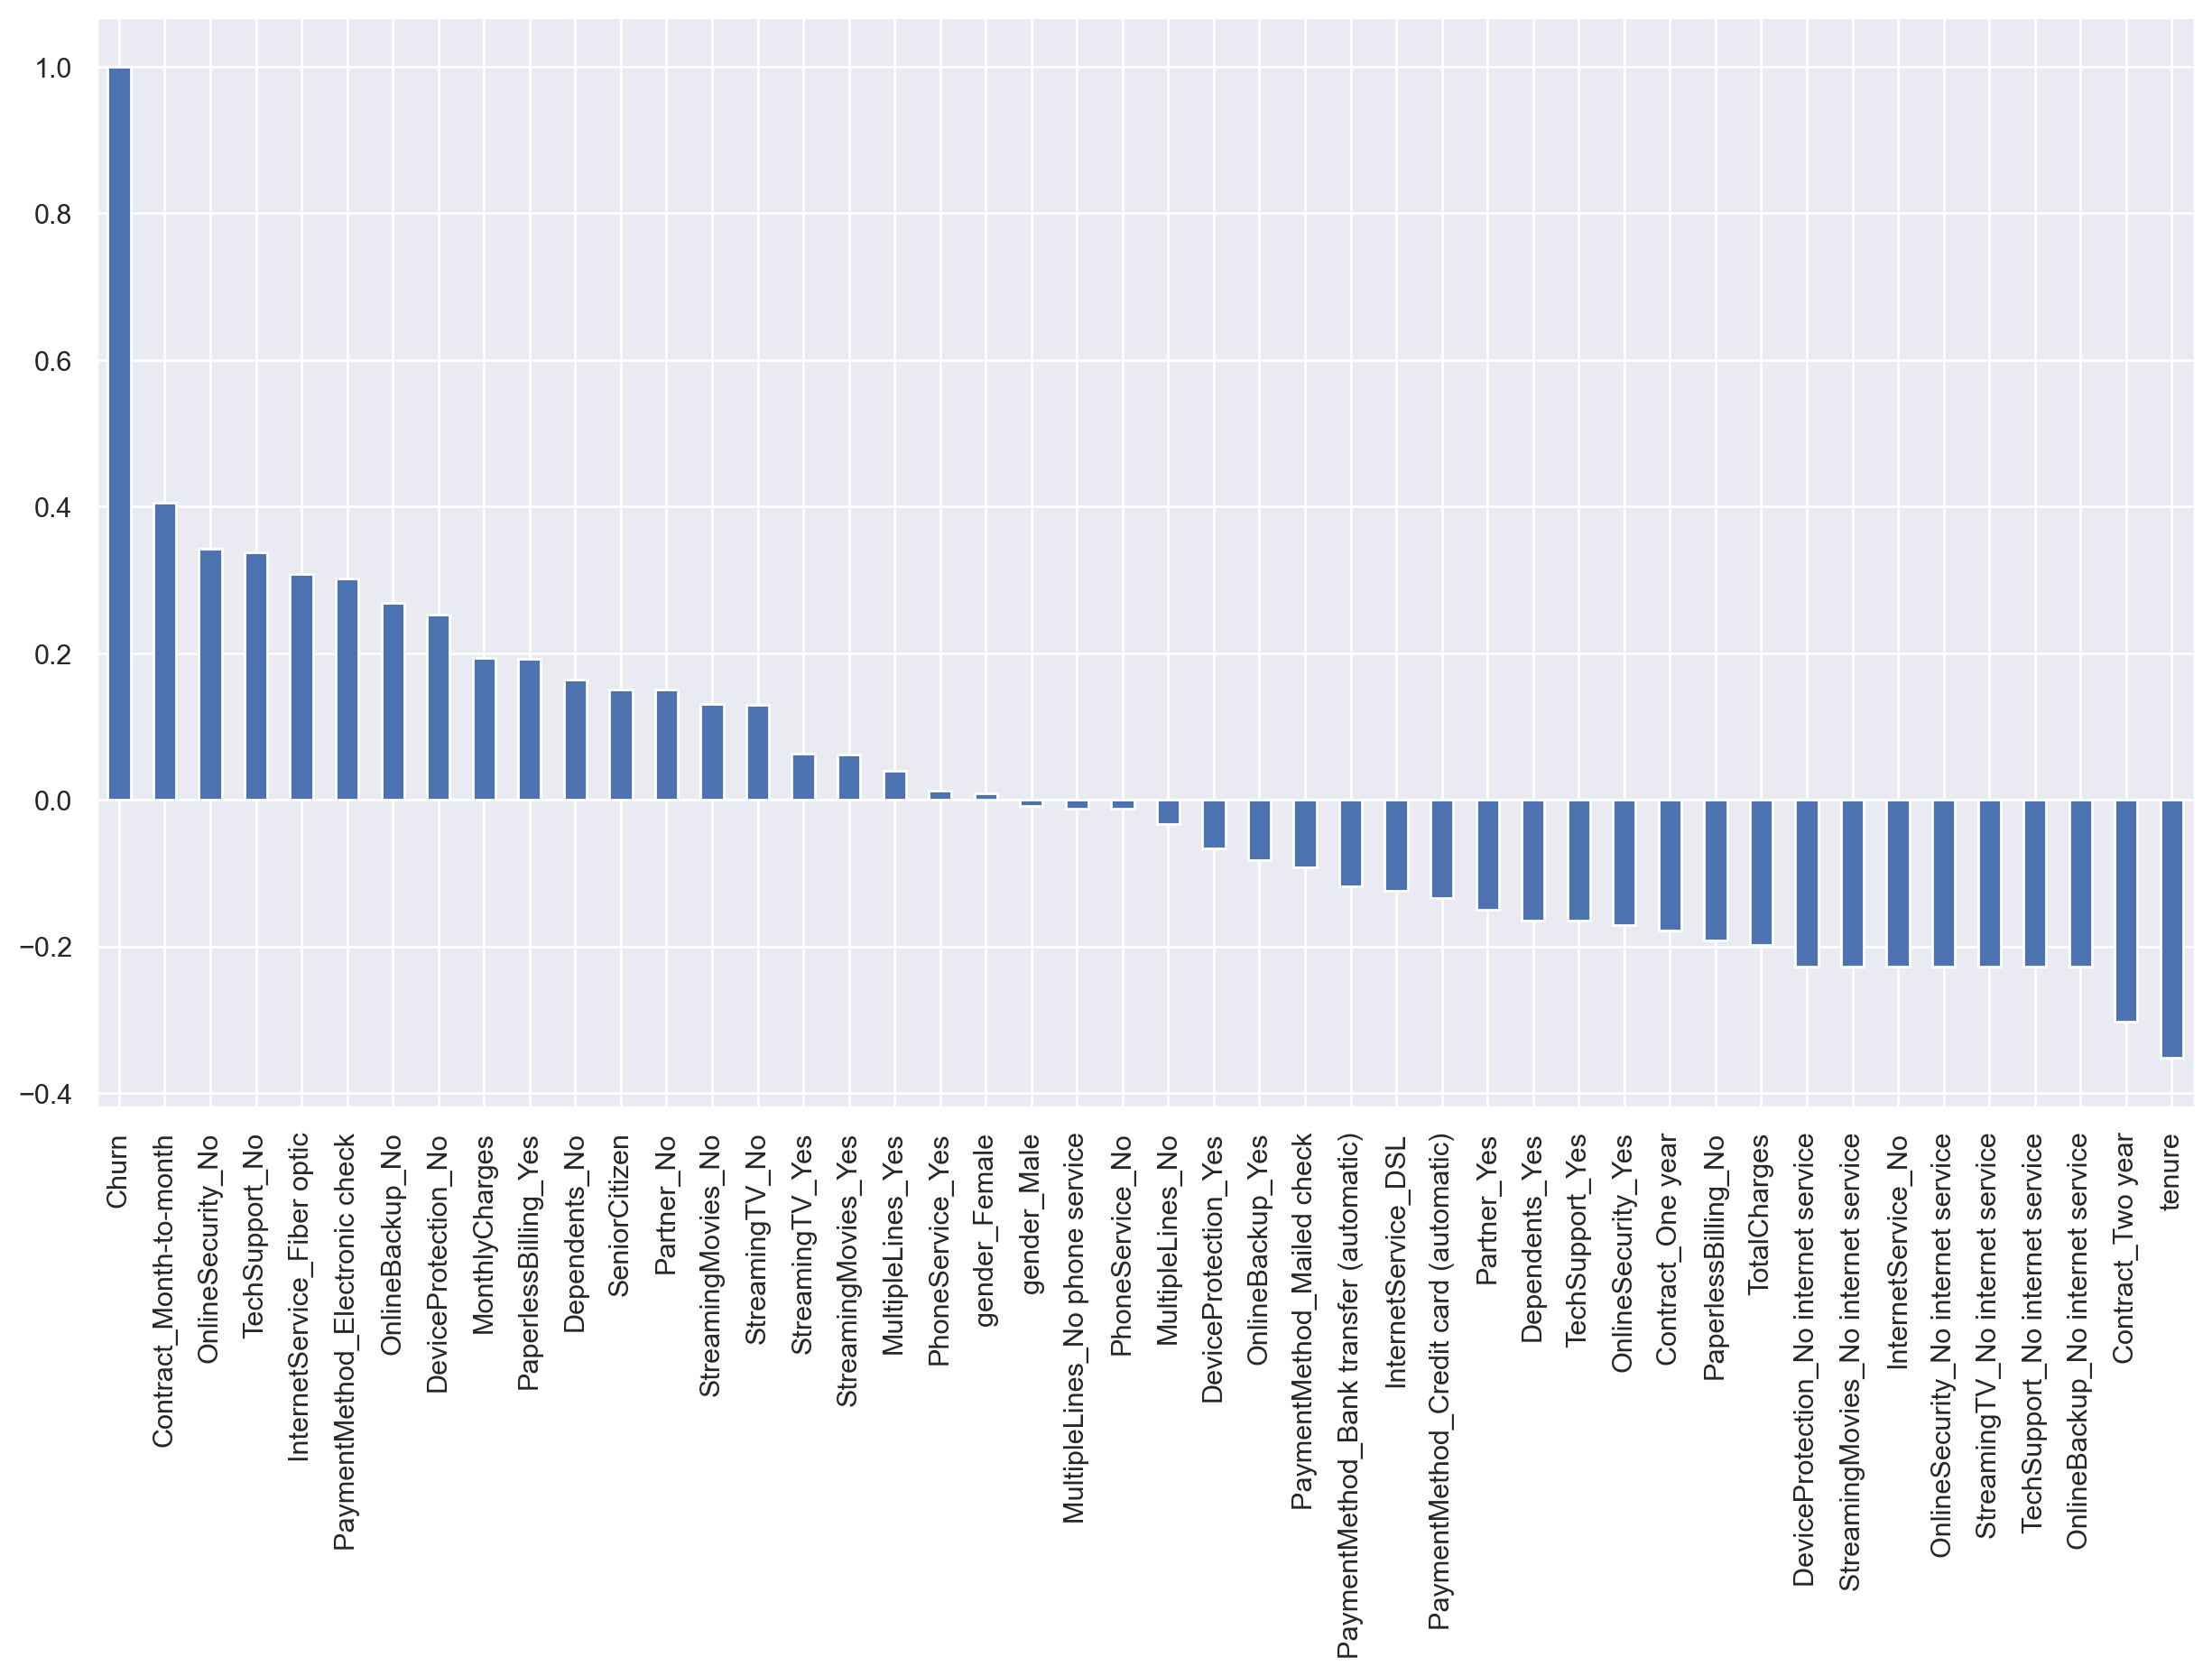

In [217]:
# 剔除ID列
df3 = tcc.iloc[:,1:].copy()

# 将标签Yes/No转化为1/0
df3['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df3['Churn'].replace(to_replace='No',  value=0, inplace=True)

# 将其他所有分类变量转化为哑变量，连续变量保留不变
df_dummies = pd.get_dummies(df3)

# 绘制柱状图
sns.set()
plt.figure(figsize=(15,8), dpi=200)

df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

但除此以外，是否还会有其他的“隐藏规律”呢？例如用户的流失是否会和季节相关、或者和每年的月份相关呢？很明显，若想围绕时序字段进一步深挖这些规律，仅仅凭借此前介绍的特征衍生方法是无法做到的。

&emsp;&emsp;为了更深入的挖掘时许字段的隐藏信息，我们需要补充一些专门用于围绕时序进行特征衍生和规律挖掘的方法。接下来我们将先以tenure字段为例来进行分析。

### 1.时序特征衍生方法

#### 1.1 tenure时序字段分析

&emsp;&emsp;所谓的时序特征，其实就是指记录了时间的特征，例如交易发生时间、用户入网时间等，在Telco数据集中，tenure字段就是时序字段。而对于时序字段来说，也绝不仅仅是一串记录了事件发生时间的数字或者字符串这么简单，其背后往往可能隐藏着非常多极有价值的信息，例如在很多场景下数据集的标签都会具有季节性波动规律，对应到上述数据集就是用户流失很有可能与季节、月份相关。而要围绕这点进行分析，我们首先就需要将tenure数值型字段转化为年-月-季度的基本格式。

- 时间信息的更细粒度周期划分

&emsp;&emsp;假设tenure是以月为时间跨度进行的记录，则tenure的取值范围[0, 72]就表示过去6年（也就是72个月）的时间记录结果。并且我们知道，tenure取值越大代表的记录的时间越久远。假设tenure=0表示的是2020年1月，则tenure=1则代表2019年12月，则tenure=2代表2019年11月依此类推。那么据此，我们可以根据tenure字段衍生出更多的、用于呈现更细粒度时间信息的字段，即衍生出某个用户入网时间所属年、月、季度等，基本过程如下所示：

<center><img src="https://s2.loli.net/2022/02/16/mHYAsbvt6Ewi94V.png" alt="image-20220216174439233" style="zoom:33%;" />

> 由于数据集解释中并未给出实际统计时间跨度，因此此处的2014-2020也仅作示例使用，若统计时间区间为其他时间跨度，也可参照该方法进行计算。

而实际代码实现过程也较为简单，只需要借助numpy的广播特性，围绕tenure列进行除法和取余计算即可。首先我们需要先将tenure字段进行倒序处理，即数值越大代表距离开始统计的时间越远，即tenure=0表示开始统计的第一个月、即2014年1月，而tenure=72则表示结束统计的最后一个月，即2020年1月：

In [218]:
features['tenure'].head()

0     1
1    34
2     2
3    45
4     2
Name: tenure, dtype: int64

In [219]:
(72 - features['tenure']).head()

0    71
1    38
2    70
3    27
4    70
Name: tenure, dtype: int64

在倒序处理后，我们通过取余的运算就能够算出用户入网所属月，此处我们先创建一个[0,72]的数组用于举例，然后再回归到原始数据集上进行计算：

In [220]:
a1 = np.arange(73)
a1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [221]:
a1 % 12

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11,  0], dtype=int32)

In [222]:
# 计算所属月份
a1_month = a1 % 12 + 1
a1_month

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1], dtype=int32)

这里需要注意，因为月份是从1-12进行排布，而任意一个数除以12的余数则是0到11，因此需要在余数基础上进一步加1。并且，在此结果基础上，进一步进行取整运算（相除之后的结果取整数），即可算出每个月份所属季度：

In [223]:
# 计算所属季度
((a1_month-1) // 3) + 1

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
       4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2,
       3, 3, 3, 4, 4, 4, 1], dtype=int32)

In [224]:
a1_quarter = ((a1_month-1) // 3) + 1
a1_quarter

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4,
       4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 2, 2, 2,
       3, 3, 3, 4, 4, 4, 1], dtype=int32)

然后我们再通过取整运算，则可以算出每位用户入网所属年：

In [225]:
(a1 // 12) + 2014

array([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
       2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
       2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019,
       2019, 2019, 2019, 2019, 2019, 2019, 2020], dtype=int32)

In [226]:
a1_year = (a1 // 12) + 2014
a1_year

array([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
       2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
       2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
       2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
       2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2019, 2019, 2019,
       2019, 2019, 2019, 2019, 2019, 2019, 2020], dtype=int32)

> 当然，年份的转化也可以借助等频分箱完成（需要先把tenure=0进行单独提取）。

&emsp;&emsp;接下来，我们在原始数据集的tenure列上进行年、月、季度的特征衍生：

In [227]:
feature_seq = pd.DataFrame()
feature_seq['tenure'] = features['tenure']

In [228]:
# 年份衍生
feature_seq['tenure_year'] = ((72 - features['tenure']) // 12) + 2014

In [229]:
feature_seq.head()

,tenure,tenure_year
0,1,2019
1,34,2017
2,2,2019
3,45,2016
4,2,2019


In [230]:
# 月份衍生
feature_seq['tenure_month'] = (72 - features['tenure']) % 12 + 1

In [231]:
feature_seq.head()

,tenure,tenure_year,tenure_month
0,1,2019,12
1,34,2017,3
2,2,2019,11
3,45,2016,4
4,2,2019,11


In [232]:
# 季度衍生
feature_seq['tenure_quarter'] = ((feature_seq['tenure_month']-1) // 3) + 1

In [233]:
feature_seq.head()

,tenure,tenure_year,tenure_month,tenure_quarter
0,1,2019,12,4
1,34,2017,3,1
2,2,2019,11,4
3,45,2016,4,2
4,2,2019,11,4


至此，我们就根据tenure字段完成了更细粒度的时间划分。接下来我们就从这些更细粒度刻画时间的字段入手进行分析。

- 时间衍生字段分析

&emsp;&emsp;根据此前的分析我们知道，tenure和用户流失呈现明显的负相关，即tenure取值越大（越是老用户），用户流失的概率就越小，接下来我们进一步分析用户流失是否和入网年份、月份和季度有关：

In [234]:
feature_seq['Churn'] = labels
feature_seq.head()

,tenure,tenure_year,tenure_month,tenure_quarter,Churn
0,1,2019,12,4,0
1,34,2017,3,1,0
2,2,2019,11,4,1
3,45,2016,4,2,0
4,2,2019,11,4,1


当然，我们可以首先简单尝试计算相关系数，这里需要注意的是，在未进行独热编码之前，相关系数的计算实际上会将拥有多个取值水平的分类变量视作连续变量来进行计算。例如quarter取值为[1,4]，则相关系数的计算过程是quarter取值越大、流失概率如何变化：

In [235]:
feature_seq.corr()

,tenure,tenure_year,tenure_month,tenure_quarter,Churn
tenure,1.000000,-0.989228,-0.424561,-0.403772,-0.352229
tenure_year,-0.989228,1.000000,0.287452,0.269392,0.337954
tenure_month,-0.424561,0.287452,1.000000,0.975681,0.214367
tenure_quarter,-0.403772,0.269392,0.975681,1.000000,0.198723
Churn,-0.352229,0.337954,0.214367,0.198723,1.000000


&emsp;&emsp;出于更严谨的角度考虑，我们还是需要将年、月、季度等字段进行独热编码，毕竟类似“所在季度越靠后（quarter取值越大）流失概率越大的规律可能并不能完整的表示季度与用户流失率之间的关系。

In [236]:
seq_new = ['tenure_year', 'tenure_month', 'tenure_quarter']

In [237]:
feature_seq_new = feature_seq[seq_new]
feature_seq_new.head()

,tenure_year,tenure_month,tenure_quarter
0,2019,12,4
1,2017,3,1
2,2019,11,4
3,2016,4,2
4,2019,11,4


In [238]:
enc = preprocessing.OneHotEncoder()

In [239]:
enc.fit_transform(feature_seq_new)

<7043x23 sparse matrix of type '<class 'numpy.float64'>'
	with 21129 stored elements in Compressed Sparse Row format>

In [240]:
seq_new

['tenure_year', 'tenure_month', 'tenure_quarter']

In [241]:
# 借助此前定义的列名称提取器进行列名称提取
cate_colName(enc, seq_new, drop=None)

['tenure_year_2014',
 'tenure_year_2015',
 'tenure_year_2016',
 'tenure_year_2017',
 'tenure_year_2018',
 'tenure_year_2019',
 'tenure_year_2020',
 'tenure_month_1',
 'tenure_month_2',
 'tenure_month_3',
 'tenure_month_4',
 'tenure_month_5',
 'tenure_month_6',
 'tenure_month_7',
 'tenure_month_8',
 'tenure_month_9',
 'tenure_month_10',
 'tenure_month_11',
 'tenure_month_12',
 'tenure_quarter_1',
 'tenure_quarter_2',
 'tenure_quarter_3',
 'tenure_quarter_4']

In [242]:
# 创建带有列名称的独热编码之后的df
features_seq_new = pd.DataFrame(enc.fit_transform(feature_seq_new).toarray(), 
                               columns = cate_colName(enc, seq_new, drop=None))

features_seq_new.head(5)

,tenure_year_2014,tenure_year_2015,tenure_year_2016,tenure_year_2017,tenure_year_2018,tenure_year_2019,tenure_year_2020,tenure_month_1,tenure_month_2,tenure_month_3,...,tenure_month_7,tenure_month_8,tenure_month_9,tenure_month_10,tenure_month_11,tenure_month_12,tenure_quarter_1,tenure_quarter_2,tenure_quarter_3,tenure_quarter_4
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [243]:
# 添加标签列
features_seq_new['Churn'] = labels

features_seq_new.head()

,tenure_year_2014,tenure_year_2015,tenure_year_2016,tenure_year_2017,tenure_year_2018,tenure_year_2019,tenure_year_2020,tenure_month_1,tenure_month_2,tenure_month_3,...,tenure_month_8,tenure_month_9,tenure_month_10,tenure_month_11,tenure_month_12,tenure_quarter_1,tenure_quarter_2,tenure_quarter_3,tenure_quarter_4,Churn
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


接下来即可通过柱状图来观察用户不同入网时间与流失率之间的相关关系：

<AxesSubplot:>

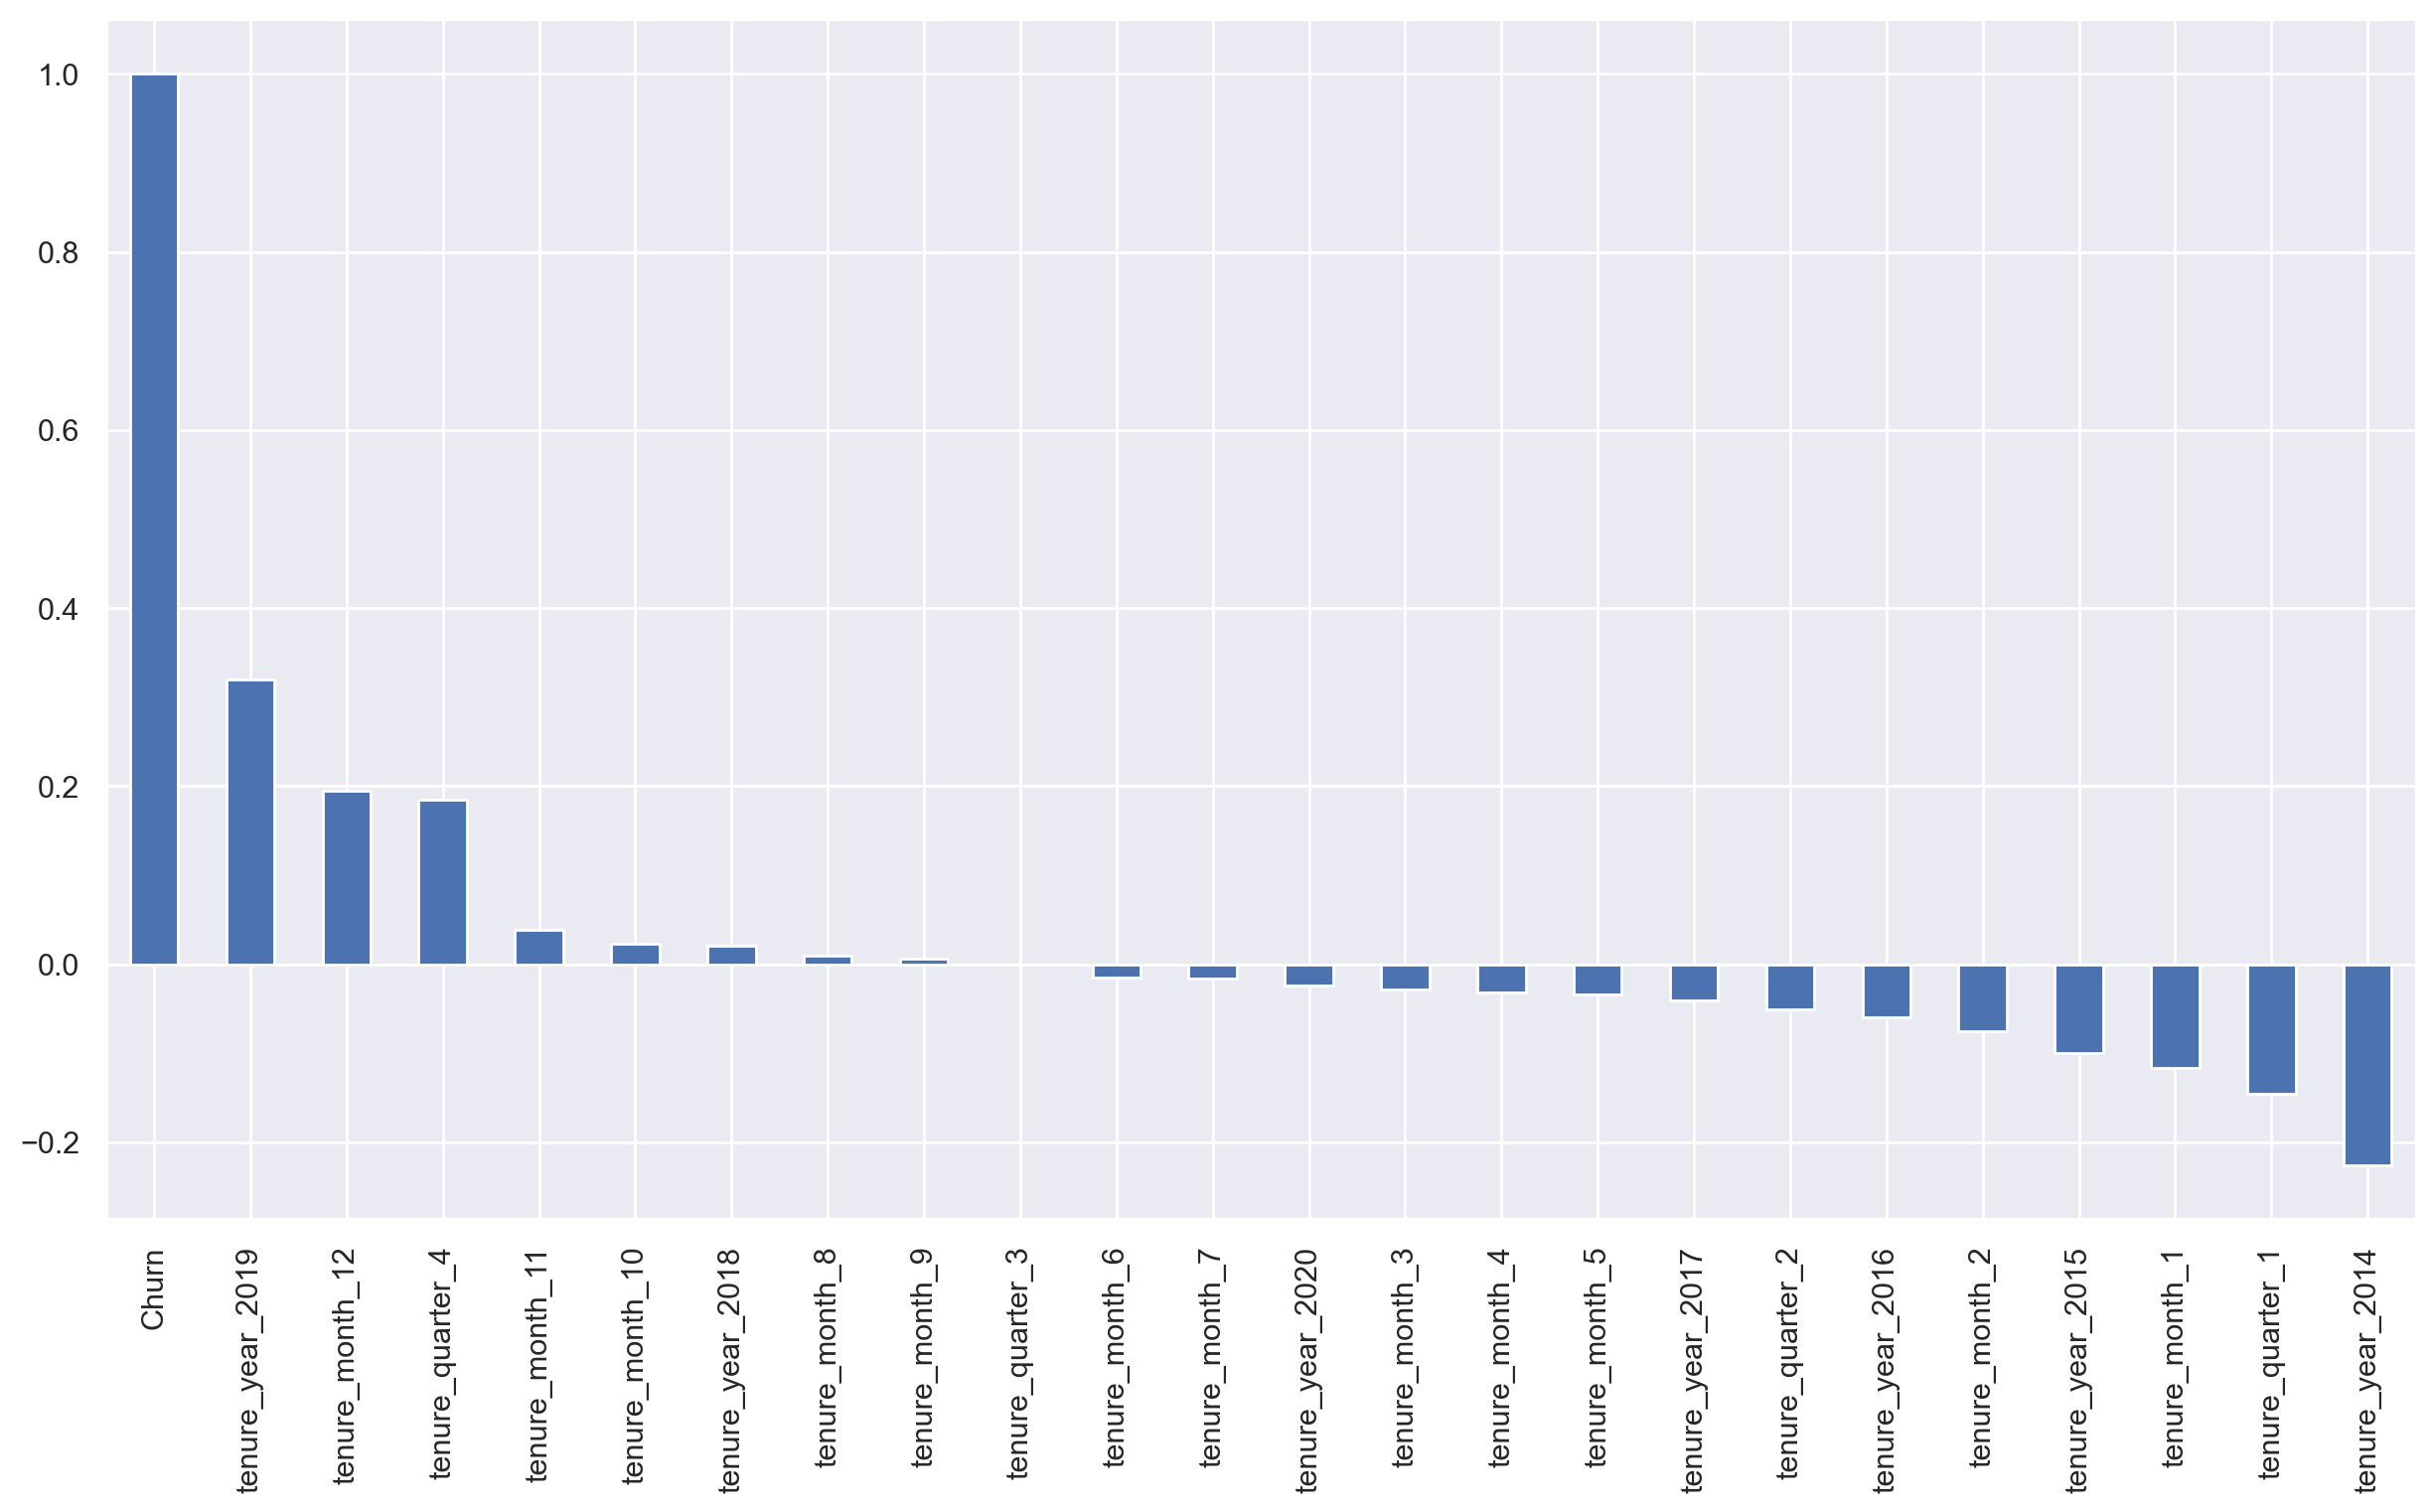

In [244]:
sns.set()
plt.figure(figsize=(15,8), dpi=200)

features_seq_new.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

&emsp;&emsp;能够看出，2019年入网用户普遍流失率更大、而2014年入网用户普遍流失率更小，当然这个和tenure字段与标签的相关性表现出来的规律是一致的，即越是新入网的用户、流失概率越大，尽管该规律真实有效，但在实际使用过程中还是要注意区分场景，如果是针对既有用户（例如过去6年积累下来的所有用户）进行流失率预测，则入网时长就将是重要特征，但如果是要针对每个月入网的新用户进行流失率的实时预测，则入网年份可能就不是那么重要了，此时我们则需要更关注例如12月和第四季度入网用户普遍容易流失、而1月和第一季度入网用户流失率相对较低这类规律。

&emsp;&emsp;但不管怎样，我们都可以将这些相关性较强的字段带入模型进行建模，测试新特征是否会带来模型效果上的提升：

In [245]:
abs(features_seq_new.corr()['Churn']).sort_values(ascending = False)

Churn               1.000000
tenure_year_2019    0.320054
tenure_year_2014    0.225500
tenure_month_12     0.194221
tenure_quarter_4    0.184320
tenure_quarter_1    0.145929
tenure_month_1      0.116592
tenure_year_2015    0.100416
tenure_month_2      0.075770
tenure_year_2016    0.059229
tenure_quarter_2    0.050526
tenure_year_2017    0.040637
tenure_month_11     0.038805
tenure_month_5      0.034115
tenure_month_4      0.032217
tenure_month_3      0.027905
tenure_year_2020    0.023771
tenure_month_10     0.023090
tenure_year_2018    0.020308
tenure_month_7      0.016201
tenure_month_6      0.014609
tenure_month_8      0.008940
tenure_month_9      0.006660
tenure_quarter_3    0.000203
Name: Churn, dtype: float64

首先我们带入2014年和2019年两个关键年份字段进行建模：

In [246]:
abs(features_seq_new.corr()['Churn']).sort_values(ascending = False)[1: 3].index

Index(['tenure_year_2019', 'tenure_year_2014'], dtype='object')

In [247]:
features_new_cols1 = list(abs(features_seq_new.corr()['Churn']).sort_values(ascending = False)[1: 3].index)
features_new_cols1

['tenure_year_2019', 'tenure_year_2014']

In [248]:
features_new1 = features_seq_new[features_new_cols1]
features_new1.head(5)

,tenure_year_2019,tenure_year_2014
0,1.0,0.0
1,0.0,0.0
2,1.0,0.0
3,0.0,0.0
4,1.0,0.0


这里我们尝试使用此前定义的features_test函数，用逻辑回归模型对比测试带入新特征之后的模型效果：

In [249]:
features_test(features_new1,
              features = features, 
              labels = labels, 
              category_cols = category_cols, 
              numeric_cols = numeric_cols)

46.98266673088074 s


(0.8073022312373226,
 {'columntransformer__num': StandardScaler(),
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l1',
  'logit_threshold__solver': 'saga'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.808519      0.681159         0.534496  0.598980   
 test_eval         0.797918      0.636971         0.520000  0.572573   
 
             roc_auc_score  
 train_eval       0.761761  
 test_eval        0.739159  )

能够看出，模型效果有了非常显著的提升（原数据集情况下交叉验证的平均准确率为0.8042）。当然，这里我们进一步来进行分析，其实这两个年份字段的根本作用就是给了新入网和最早入网的用户一个标识，本质上也是强化了越早入网越不容易流失这一规律的外在表现。需要注意的是，这种标识其实也是极大的补充了tenure字段在表现“越早入网越不容易流失”这一规律的不足：对于tenure字段来说，尽管数值越大越不容易流失，但tenure字段取值为0时因为统计周期的原因，并没有用户流失：

In [250]:
tcc[['tenure', 'Churn']][tcc['tenure'] == 0]

,tenure,Churn
488,0,0
753,0,0
936,0,0
1082,0,0
1340,0,0
3331,0,0
3826,0,0
4380,0,0
5218,0,0
6670,0,0


从这个角度来说，因此2014和2019年份字段从某些角度而言能更好的体现越早入网越不容易流失的规律。

&emsp;&emsp;接下来进一步测试第四季度、第一季度以及1月入网这三个新字段对模型效果的影响，在实时预测场景下，相比年份、我们可能更需要关注同一年中的不同月份、不同季节对标签取值的影响：

In [251]:
abs(features_seq_new.corr()['Churn']).sort_values(ascending = False)[4: 7].index

Index(['tenure_quarter_4', 'tenure_quarter_1', 'tenure_month_1'], dtype='object')

In [252]:
features_new_cols2 = list(abs(features_seq_new.corr()['Churn']).sort_values(ascending = False)[4: 7].index)
features_new_cols2

['tenure_quarter_4', 'tenure_quarter_1', 'tenure_month_1']

In [253]:
features_new2 = features_seq_new[features_new_cols2]
features_new2.head(5)

,tenure_quarter_4,tenure_quarter_1,tenure_month_1
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [254]:
features_test(features_new2, 
              features = features, 
              labels = labels, 
              category_cols = category_cols, 
              numeric_cols = numeric_cols)

46.780478954315186 s


(0.8060851926977689,
 {'columntransformer__num': 'passthrough',
  'logit_threshold__C': 0.1,
  'logit_threshold__penalty': 'l2',
  'logit_threshold__solver': 'newton-cg'},
             accuracy_score  recall_score  precision_score  f1_score  \
 train_eval        0.810548      0.675159         0.562547   0.61373   
 test_eval         0.794132      0.619543         0.541818   0.57808   
 
             roc_auc_score  
 train_eval       0.762273  
 test_eval        0.732565  )

能看出，这三个新的特征对模型效果提升也是非常明显的，至于为何12月、第四季度入网用户容易流失，而1月、第一季度入网用户更不容易流失，可能和实际营销策略有关，同时我们也可以将该规律反馈给前端运营人员，或据此提出更进一步优化营销策略，但从最终建模效果来看，更细粒度的时间周期划分衍生出来的新特征，确实能够起到一定的作用。同时这也反映出时序字段确实有很多隐藏信息，而更细粒度的时间周期的划分，能够对这些隐藏信息进行有效挖掘。

- 时序字段的二阶特征衍生

&emsp;&emsp;当我们更细粒度的对时序特征进行划分后，接下来我们也可以进一步围绕衍生时序特征和原始特征进行双变量或多变量特征衍生，这也是所谓的时序字段的二阶特征衍生。例如在上述例子中，我们已经发现在时序字段衍生字段中，季度是相对重要的特征，那么接下来我们接下来我们可以进一步将季度字段与其他原始字段进行交叉组合、分组统计汇总等，去进行进一步的特征衍生。

#### 1.2 更通用的时序字段基本特征衍生方法

&emsp;&emsp;在本案例中，由于时序字段并没有包含更多细节的信息，因此分析过程并不复杂，但在其他很多场景下时序字段的特征衍生与分析可能会非常复杂。因此，为了应对更加复杂场景，我们需要进一步补充一些时序字段的处理方法与特征衍生策略，同时，在对某些包含时序特征的回归问题中，我们还会使用一类仅仅通过时序特征就能够对标签进行预测的模型——时间序列模型，尽管本案例中并不涉及实践序列模型建模，但简单了解其背后的核心思想却是非常有助于我们理解时序特征的重要性，也能够更进一步指导我们进行时序特征的特征衍生。

- Pandas中的时间记录格式

&emsp;&emsp;首先是关于时序字段的展示形式，本案例中tenure字段是经过自然数编码后的字段，时间是以整数形式进行呈现，而对于其他很多数据集，时序字段往往记录的就是时间是真实时间，并且是精确到年-月-日、甚至是小时-分钟-秒的字段，例如"2022-07-01;14:22:01"，此时拿到数据后，首先需要考虑的是如何对这类字段进行处理。

In [255]:
t = pd.DataFrame()

In [256]:
t['time'] = ['2022-01-03;02:31:52',
             '2022-07-01;14:22:01', 
             '2022-08-22;08:02:31', 
             '2022-04-30;11:41:31', 
             '2022-05-02;22:01:27']
t

,time
0,2022-01-03;02:31:52
1,2022-07-01;14:22:01
2,2022-08-22;08:02:31
3,2022-04-30;11:41:31
4,2022-05-02;22:01:27


当然，对于这类object对象，我们可以字符串分割的方式对其进行处理，此外还有一种更简单通用同时也更有效的方法：将其转化为datetime64格式，这也是pandas中专门用于记录时间对象的格式。对于datetime64来说有两种子类型，分别是datetime64[ns]毫秒格式与datetime64[D]日期格式。无论是哪种格式，我们可以通过pd.to_datetime函数对其进行转化，基本过程如下：

In [257]:
pd.to_datetime?

Signature:
pd.to_datetime(
    arg: Union[~DatetimeScalar, List, Tuple, ~ArrayLike, ForwardRef('Series')],
    errors: str = 'raise',
    dayfirst: bool = False,
    yearfirst: bool = False,
    utc: Union[bool, NoneType] = None,
    format: Union[str, NoneType] = None,
    exact: bool = True,
    unit: Union[str, NoneType] = None,
    infer_datetime_format: bool = False,
    origin='unix',
    cache: bool = True,
) -> Union[pandas.core.indexes.datetimes.DatetimeIndex, ForwardRef('Series'), ~DatetimeScalar, ForwardRef('NaTType')]
Docstring:
Convert argument to datetime.

Parameters
----------
arg : int, float, str, datetime, list, tuple, 1-d array, Series, DataFrame/dict-like
    The object to convert to a datetime.
errors : {'ignore', 'raise', 'coerce'}, default 'raise'
    - If 'raise', then invalid parsing will raise an exception.
    - If 'coerce', then invalid parsing will be set as NaT.
    - If 'ignore', then invalid parsing will return the input.
dayfirst : bool, default False


In [258]:
pd.to_datetime(t['time'])

0   2022-01-03 02:31:52
1   2022-07-01 14:22:01
2   2022-08-22 08:02:31
3   2022-04-30 11:41:31
4   2022-05-02 22:01:27
Name: time, dtype: datetime64[ns]

In [259]:
t['time'] = pd.to_datetime(t['time'])
t['time']

0   2022-01-03 02:31:52
1   2022-07-01 14:22:01
2   2022-08-22 08:02:31
3   2022-04-30 11:41:31
4   2022-05-02 22:01:27
Name: time, dtype: datetime64[ns]

> 这里需要注意，一般来说时间字段的记录格式都是用'-'来划分年月日，用':'来分割时分秒，用空格、分号或者换行来分割年月日与时分秒，这是一种通用的记录方法，如果是手动输入时间，也尽可能按照上述格式进行记录。

同时我们发现，该函数会自动将目标对象转化为datetime64[ns]类型，该对象类型是一种高精度、精确到纳秒（10的负九次方秒）的时间记录格式，后面在进行时间差计算时会看到纳秒级运算的结果。当然，如果我们的时间记录格式本身只精确到日期、并没有时分秒，通过pd.to_datetime函数仍然会转化为datetime64[ns]类型，只是此时显示的时间中就没有时分秒：

In [260]:
t1 = pd.DataFrame()
t1['time'] = ['2022-01-03', '2022-07-01',]
t1

,time
0,2022-01-03
1,2022-07-01


In [261]:
t1['time'] = pd.to_datetime(t1['time'])
t1['time']

0   2022-01-03
1   2022-07-01
Name: time, dtype: datetime64[ns]

就类似于浮点数与整数，更高的精度往往会导致更大的计算量，对于本身只是精确到日期的时间记录格式，我们其实可以用另一种只能精确到天的时间数据格式进行记录，也就是datetime64[D]类型。当然在pd.to_datetime函数使用过程中是无法直接创建datetime64[D]类型对象的，我们需要使用.value.astype('datetime64[D]')的方法对其进行转化，但是需要注意，这个过程最终创建的对象类型是array，而不再是Series了：

In [262]:
t1['time'].values

array(['2022-01-03T00:00:00.000000000', '2022-07-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [263]:
t1['time'].values.astype('datetime64[D]')

array(['2022-01-03', '2022-07-01'], dtype='datetime64[D]')

能够看出，array是支持datetime64[ns]和datetime64[D]等多种类型存储的，但对于pandas来说，只支持以datetime64[ns]类型进行存储，哪怕输入的对象类型是datetime64[D]，在转化为Series时仍然会被转化为datetime64[ns]：

In [264]:
t1['time'] = pd.Series(t1['time'].values.astype('datetime64[D]'), dtype='datetime64[D]')

In [265]:
t1['time']

0   2022-01-03
1   2022-07-01
Name: time, dtype: datetime64[ns]

尽管我们无法使用.values.astype('datetime64[D]')方法将Series对象类型进行'datetime64[D]'类型转化，但不同时间格式的转化有的时候有助于我们控制时间记录本身的精度，例如对于t中的time列，如果对其进行精确到天的'datetime64[D]'类型转化，则会自动删除时分秒的数据记录结果：

In [266]:
t['time'].values.astype('datetime64[D]')

array(['2022-01-03', '2022-07-01', '2022-08-22', '2022-04-30',
       '2022-05-02'], dtype='datetime64[D]')

In [267]:
t['time-D'] = t['time'].values.astype('datetime64[D]')
t

,time,time-D
0,2022-01-03 02:31:52,2022-01-03
1,2022-07-01 14:22:01,2022-07-01
2,2022-08-22 08:02:31,2022-08-22
3,2022-04-30 11:41:31,2022-04-30
4,2022-05-02 22:01:27,2022-05-02


有的时候我们无需考虑时分秒的时间时，可以通过上述方法进行精确到天的时间格式转化。当然，此外还有'datetime64[h]'类型可精确到小时、'datetime64[s]'精确到、'datetime64[ms]'精确到毫秒等：

In [268]:
t['time'].values.astype('datetime64[h]')

array(['2022-01-03T02', '2022-07-01T14', '2022-08-22T08', '2022-04-30T11',
       '2022-05-02T22'], dtype='datetime64[h]')

In [269]:
t['time'].values.astype('datetime64[s]')

array(['2022-01-03T02:31:52', '2022-07-01T14:22:01',
       '2022-08-22T08:02:31', '2022-04-30T11:41:31',
       '2022-05-02T22:01:27'], dtype='datetime64[s]')

> 在绝大多数情况下，我们都建议采用pandas中datetime类型记录时间（尽管从表面上来看也可以用字符串来表示时间），这也将极大程度方便我们后续对关键时间信息的提取。

- 时序字段的通用信息提取方式

&emsp;&emsp;在转化为datetime64格式之后，我们就可以通过一些dt.func方式来提取时间中的关键信息，如年、月、日、小时、季节、一年的第几周等，常用方法如下所示：

| 方法 | 作用 |
| ------ | ------ |
| dt.year | 提取年 |
| dt.month | 提取月 |
| dt.day | 提取日 |
| dt.hour | 提取小时 |
| dt.minute | 提取分钟 |
| dt.second | 提取秒 |

In [270]:
t['time'].dt.year

0    2022
1    2022
2    2022
3    2022
4    2022
Name: time, dtype: int64

In [271]:
t['time'].dt.second

0    52
1     1
2    31
3    31
4    27
Name: time, dtype: int64

接下来我们用不同的列记录这些具体时间信息：

In [272]:
t['year']        =  t['time'].dt.year
t['month']       =  t['time'].dt.month
t['day']         =  t['time'].dt.day
t['hour']        =  t['time'].dt.hour
t['minute']      =  t['time'].dt.minute
t['second']      =  t['time'].dt.second

In [273]:
t

,time,time-D,year,month,day,hour,minute,second
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27


- 时序字段的其他自然周期提取方式

&emsp;&emsp;当然，除了用不同的列记录时序字段的年月日、时分秒之外，我们知道，还有一些自然周期也会对结果预测有较大影响，如日期所在季度。这里需要注意的是，对于时序字段，往往我们会尽可能的对其进行自然周期的划分，然后在后续进行特征筛选时再对这些衍生字段进行筛选，对于此前的数据集，我们能够清晰的看到季度特征对标签的影响，而很多时候，除了季度，诸如全年的第几周、一周的第几天，甚至是日期是否在周末，具体事件的时间是在上午、下午还是在晚上等，都会对预测造成影响。对于这些自然周期提取方法，有些自然周期可以通过dt的方法自动计算，另外则需要手动进行计算。首先我们先看能够自动完成计算的自然周期：

| 方法 | 作用 |
| ------ | ------ |
| dt.quarter | 提取季度 |
| dt.weekofyear | 提取年当中的周数 |
| dt.dayofweek, dt.weekday | 提取周几 |

In [274]:
t

,time,time-D,year,month,day,hour,minute,second
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27


In [275]:
t['time'].dt.weekofyear

<ipython-input-275-40c69577c0b6>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  t['time'].dt.weekofyear


0     1
1    26
2    34
3    17
4    18
Name: time, dtype: int64

In [276]:
t['time'].dt.quarter

0    1
1    3
2    3
3    2
4    2
Name: time, dtype: int64

In [277]:
t['time'].dt.dayofweek

0    0
1    4
2    0
3    5
4    0
Name: time, dtype: int64

这里需要注意，每周一是从0开始计数，这里我们可以手动+1，对其进行数值上的修改：

In [278]:
t['time'].dt.dayofweek + 1

0    1
1    5
2    1
3    6
4    1
Name: time, dtype: int64

接下来我们将其拼接到原始数据集中：

In [279]:
t['quarter']     =  t['time'].dt.quarter
t['weekofyear']  =  t['time'].dt.weekofyear
t['dayofweek']   =  t['time'].dt.dayofweek + 1

<ipython-input-279-d6fa2c370bb6>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  t['weekofyear']  =  t['time'].dt.weekofyear


In [280]:
t

,time,time-D,year,month,day,hour,minute,second,quarter,weekofyear,dayofweek
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52,1,1,1
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1,3,26,5
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31,3,34,1
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31,2,17,6
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27,2,18,1


接下来继续创建是否是周末的标识字段：

In [281]:
(t['dayofweek'] > 5).astype(int) 

0    0
1    0
2    0
3    1
4    0
Name: dayofweek, dtype: int32

In [282]:
t['weekend'] = (t['dayofweek'] > 5).astype(int) 

进一步创建小时所属每一天的周期，凌晨、上午、下午、晚上，周期以6小时为划分依据：

In [283]:
(t['hour'] // 6).astype(int) 

0    0
1    2
2    1
3    1
4    3
Name: hour, dtype: int32

In [284]:
t['hour_section'] = (t['hour'] // 6).astype(int) 

其中，0代表凌晨、1代表上午、2代表下午、3代表晚上。接下来查看时间信息衍生后的数据表：

In [285]:
t

,time,time-D,year,month,day,hour,minute,second,quarter,weekofyear,dayofweek,weekend,hour_section
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52,1,1,1,0,0
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1,3,26,5,0,2
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31,3,34,1,0,1
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31,2,17,6,1,1
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27,2,18,1,0,3


至此，我们就完成了围绕时序字段的详细信息衍生（年月日、时分秒单独提取一列），以及基于自然周期划分的时序特征衍生（第几周、周几、是否是周末、一天中的时间段）。

<center><img src="https://s2.loli.net/2022/02/17/y7wctiB4EH3qkMV.png" alt="image-20220217202852046" style="zoom:33%;" />

&emsp;&emsp;当然整个时序字段的特征衍生过程并不复杂，接下来我们重点探讨为何我们需要对时序特征进行周期性划分，或者说，为何对时序特征进行有效的周期性划分是我们进一步挖掘时序特征背后有效信息的必要手段。

#### 1.3 时序字段特征衍生的本质与核心思路

- 时序字段衍生的本质：增加分组

&emsp;&emsp;首先，通过观察我们不难发现，时序特征的衍生其本质上就是对用户进行了更多不同维度的分组，该过程可以通过下图进行解释，在tenure时序特征进行特征衍生后，ID1-6号用户在所属年份列中就被划分到了2019年组中，即他们同为2019年入网的用户，而根据入网的季节进行划分，则ID为0、4、5的三个用户会被划归到第一季度入网用户组中，并且时序特征衍生的字段越多、对用户分组的维度也就越多：

<center><img src="https://s2.loli.net/2022/02/17/TzsoKHnfRZBqaxJ.png" alt="image-20220217201256094" style="zoom:33%;" />

&emsp;&emsp;而对用户进行分组之所以能够帮助模型进行建模与训练，其根本原因也是因为有的时候，同一组内（或者是多组交叉）的用户会表现出相类似的特性（或者规律），从而能够让模型更快速的对标签进行更准确的预测，例如假设数据集如下所示，在原始数据集看来，标签取值毫无规律可言，但当我们对其进行时序特征的特征衍生后，立刻能发掘很多规律，例如第四季度用户都流失了、其二是2019年第一季度用户流失都流失了等等，同样，这些通过观察就能看到的规律，也很快会被模型捕捉到，而这也是时序字段衍生能够帮助模型进行更好更快的预测的直观体现：

<center><img src="https://s2.loli.net/2022/02/17/6A5ySNwgLrsbfFd.png" alt="image-20220217203852083" style="zoom:33%;" />

&emsp;&emsp;当然，很多时候也是因为我们不知道什么样的分组能够有效的帮助到模型进行建模，因此往往需要衍生尽可能多的字段，来进行尽可能多的分组，而这些时序字段的衍生字段，也会在后续的建模过程中接受特征筛选的检验。

- 时序字段衍生的核心思路：自然周期和业务周期

&emsp;&emsp;而如何才能尽可能的进行更多的时序字段衍生呢？在进行了细节时间特征的衍生之后（划分了年月日、时分秒之后），接下来的时序特征衍生就需要同时结合自然周期和业务周期两个方面进行考虑。所谓自然周期，指的是对于时间大家普遍遵照或者约定俗成的一些规定，例如工作日周末、一周七天、一年四个季度等，这也就是此前我们进行的一系列特征衍生工作，此外其实还可以根据一些业务周期来进行时序特征的划分，例如对于部分旅游景点来说，暑假是旅游旺季，并且很多是以家庭为单位进行出游（学生暑假），因此可以考虑单独将8、9月进行标记，期间记录的用户会有许多共性，而组内用户的共性就将成为后续建模效果的保障；再比如6月、11月是打折季，也可以类似的单独设一列对6月、11月进行标记等等，这些需要特征的衍生，则需要结合具体业务情况来进行判断。

&emsp;&emsp;但是，有的时候如果我们能提前判断衍生特征对用户的分组无效，换个更严谨的说法就是，如果我们判断新衍生的特征在对数据分组的过程中，
不同组的数据在标签分布上并没有差别，则分组无效，我们大可不必进行如此特征衍生。例如，对于一家普通电商平台用户交易时间的秒和分，从业务角度出发，我们很难说每分钟第一秒交易的用户有哪些共同的特点，或者每小时第二分钟交易的用户有哪些共同的特点，甚至是每分钟的前30秒用户有哪些共同特点、每小时的前半个小时用户呈现出哪些共同的特点等，而这类特征就不必在衍生过程中进行创建了。但是，在另外一些场景下，例如某线下超市的周五，可能就是一个需要重点关注的时间，不仅是因为临近周末很多客户会在下班后进行集中采购、而且很多超市有“黑五”打折的习惯，如果是进行超市销售额预测，是否是周五可能就需要单独标注出来，形成独立的一列（该列被包含在dayofweek的衍生列中）。

> 大多数情况下关注分和秒都是毫无意义的，某些量化交易场景除外。

&emsp;&emsp;总结来看，一方面，我们需要从自然周期和业务周期两个角度进行尽可能多的特征衍生，来提供更多的备选数据分组依据来辅助模型建模，而另一方当面，我们有需要结合当前实际业务情况来判断哪些时序特征的衍生特征是有效的，提前规避掉一些可能并无太大用处的衍生特征。

- 时序字段的补充衍生方法：关键时间点的时间差值衍生

&emsp;&emsp;对于时序字段的特征衍生来说，除了自然周期和业务周期衍生外，近些年在竞赛中还涌现了一类时序字段的衍生方法：关键时间点的时间差值特征衍衍生。该方法并不复杂，实际操作过程中需要首先人工设置关键时间点，然后计算每条记录和关键时间点之间的时间差，具体时间差的衡量以天和月为主，当然也可以根据数据集整体的时间跨度为前提进行考虑（例如数据集整体时间记录都是一天当中的不同时间，则时间差的计算可以是小时甚至是分钟）。其中，关键时间点一般来说可以是数据集记录的起始时间、结束时间、距今时间，也可以是根据是根据业务或者数据集本身的数据规律，推导出来的关键时间点。

> 当然，此前的tenure字段就是距离统计日期截止前的时间差值按月计算的结果

&emsp;&emsp;在pandas中我们也可以非常快捷的进行时间差值的计算，我们可以直接将datetime64类型的两列进行相减：

In [286]:
t['time'] - t['time']

0   0 days
1   0 days
2   0 days
3   0 days
4   0 days
Name: time, dtype: timedelta64[ns]

当然，如果是用一列时间减去某个时间的话，我们需要先将这个单独的时间转化为时间戳，然后再进行相减。所谓时间戳，可以简单理解为单个时间的记录格式，在pandas中可以借助pd.Timestamp完成时间戳的创建：

In [287]:
p1 = '2022-01-03;02:31:52'
p1

'2022-01-03;02:31:52'

In [288]:
pd.Timestamp(p1)

Timestamp('2022-01-03 02:31:52')

In [289]:
t['time'] - pd.Timestamp(p1)

0     0 days 00:00:00
1   179 days 11:50:09
2   231 days 05:30:39
3   117 days 09:09:39
4   119 days 19:29:35
Name: time, dtype: timedelta64[ns]

其实一个在一个datetime64[ns]类型的Series中，每个元素都是一个时间戳：

In [290]:
t['time']

0   2022-01-03 02:31:52
1   2022-07-01 14:22:01
2   2022-08-22 08:02:31
3   2022-04-30 11:41:31
4   2022-05-02 22:01:27
Name: time, dtype: datetime64[ns]

In [291]:
t['time'][0]

Timestamp('2022-01-03 02:31:52')

因此我们也可以将一个datetime64[ns]类型的Series理解成是若干个时间戳组成的Series。

此外，对于Timestamp对象类型，我们同样也可以用year、month、second等时间信息：

In [292]:
pd.Timestamp(p1).year, pd.Timestamp(p1).second

(2022, 52)

&emsp;&emsp;接下来，我们重点讨论时间相减之后的结果。能够发现，上述时间差分的计算结果中，最后返回结果的对象类型是timedelta64[ns]，其中timedelta表示时间差值计算结果（delta往往也见于实践序列的时间差分计算结果的表示中），ns则表示计算结果的精度仍然是纳秒。而具体的差值计算结果也并不难理解，分别表示相差的天数以及时分秒。

In [293]:
td = t['time'] - pd.Timestamp(p1)
td

0     0 days 00:00:00
1   179 days 11:50:09
2   231 days 05:30:39
3   117 days 09:09:39
4   119 days 19:29:35
Name: time, dtype: timedelta64[ns]

&emsp;&emsp;接下来，我们可以进一步调用timedelta64[ns]的一些属性，来单独提取相差的天数和相差的秒数：

In [294]:
t['time_diff'] = td
t['time_diff']

0     0 days 00:00:00
1   179 days 11:50:09
2   231 days 05:30:39
3   117 days 09:09:39
4   119 days 19:29:35
Name: time_diff, dtype: timedelta64[ns]

In [295]:
td.dt.days

0      0
1    179
2    231
3    117
4    119
Name: time, dtype: int64

In [296]:
td.dt.seconds

0        0
1    42609
2    19839
3    32979
4    70175
Name: time, dtype: int64

据此我们可以借助相差的天数进一步计算相差的月数：

In [297]:
td.dt.days / 30

0    0.000000
1    5.966667
2    7.700000
3    3.900000
4    3.966667
Name: time, dtype: float64

In [298]:
np.round(td.dt.days / 30).astype('int')

0    0
1    6
2    8
3    4
4    4
Name: time, dtype: int32

这里需要注意，相差的天数是完全忽略时分秒的结果，而相差的秒数则是完全忽略了天数的计算结果，即42609秒代表的是11小时50分9秒的差值，而不包括179天：

In [299]:
11 * 60 * 60 + 50 * 60 + 9

42609

然后我们将这两列作为新增列拼接到原始特征矩阵中：

In [300]:
t['time_diff_days'] = td.dt.days
t['time_diff_seconds'] = td.dt.seconds
t

,time,time-D,year,month,day,hour,minute,second,quarter,weekofyear,dayofweek,weekend,hour_section,time_diff,time_diff_days,time_diff_seconds
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52,1,1,1,0,0,0 days 00:00:00,0,0
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1,3,26,5,0,2,179 days 11:50:09,179,42609
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31,3,34,1,0,1,231 days 05:30:39,231,19839
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31,2,17,6,1,1,117 days 09:09:39,117,32979
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27,2,18,1,0,3,119 days 19:29:35,119,70175


当然，在某些情况下，我们可能会希望计算真实时间差的秒数以及小时数，此时应该怎么做呢？

&emsp;&emsp;和datetime类似，timedelta64同样也有timedelta64[h]、timedelta64[s]等对象类型，但pandas中只支持timedelta64[ns]对象类型，我们仍然可以通过.values.astype的方法将时间运算差值转化为timedelta64[h]或timedelta64[s]的array，但再次转化成Series时又会变为timedelta64[ns]：

In [301]:
# 返回纳秒计算结果
td.values

array([                0, 15508209000000000, 19978239000000000,
       10141779000000000, 10351775000000000], dtype='timedelta64[ns]')

In [302]:
td.values.astype('timedelta64[h]')

array([   0, 4307, 5549, 2817, 2875], dtype='timedelta64[h]')

In [303]:
td.values.astype('timedelta64[s]')

array([       0, 15508209, 19978239, 10141779, 10351775],
      dtype='timedelta64[s]')

注意，这里计算的是真实的时间差：

In [304]:
179 * 24 * 60 * 60 + 11 * 60 * 60 + 50 * 60 + 9

15508209

但无法保存为Series

In [305]:
pd.Series(td.values.astype('timedelta64[s]'), dtype='timedelta64[s]')

0     0 days 00:00:00
1   179 days 11:50:09
2   231 days 05:30:39
3   117 days 09:09:39
4   119 days 19:29:35
dtype: timedelta64[ns]

当然，我们可以将这些结果保存为整数，然后再作为差值衍生的衍生特征并入原始特征矩阵：

In [306]:
td.values.astype('timedelta64[h]').astype('int')

array([   0, 4307, 5549, 2817, 2875])

In [307]:
t['time_diff_h'] = td.values.astype('timedelta64[h]').astype('int')
t['time_diff_s'] = td.values.astype('timedelta64[s]').astype('int')
t

,time,time-D,year,month,day,hour,minute,second,quarter,weekofyear,dayofweek,weekend,hour_section,time_diff,time_diff_days,time_diff_seconds,time_diff_h,time_diff_s
0,2022-01-03 02:31:52,2022-01-03,2022,1,3,2,31,52,1,1,1,0,0,0 days 00:00:00,0,0,0,0
1,2022-07-01 14:22:01,2022-07-01,2022,7,1,14,22,1,3,26,5,0,2,179 days 11:50:09,179,42609,4307,15508209
2,2022-08-22 08:02:31,2022-08-22,2022,8,22,8,2,31,3,34,1,0,1,231 days 05:30:39,231,19839,5549,19978239
3,2022-04-30 11:41:31,2022-04-30,2022,4,30,11,41,31,2,17,6,1,1,117 days 09:09:39,117,32979,2817,10141779
4,2022-05-02 22:01:27,2022-05-02,2022,5,2,22,1,27,2,18,1,0,3,119 days 19:29:35,119,70175,2875,10351775


当然，这些已经转化为整数类型的对象是无法（当然也没有必要）进行任何时序方面的操作、如进行自然周期划分、进行时间差值计算等。

&emsp;&emsp;而对于关键时间点的时间戳的提取，如数据集起止时间的计算，可以通过min/max方法实现：

In [308]:
t['time'].max()

Timestamp('2022-08-22 08:02:31')

In [309]:
t['time'].min()

Timestamp('2022-01-03 02:31:52')

同时，我们可以通过如下方式获取当前时间：

In [310]:
import datetime

In [311]:
datetime.datetime.now()

datetime.datetime(2022, 3, 24, 0, 46, 25, 253366)

在默认情况下，获得的是精确到毫秒的结果：

In [312]:
pd.Timestamp(datetime.datetime.now())

Timestamp('2022-03-24 00:46:25.269380')

当然，我们也可以通过如下方式自定义时间输出格式，并借此输出指定精度的时间：

In [313]:
print(datetime.datetime.now().strftime('%Y-%m-%d'))
print(pd.Timestamp(datetime.datetime.now().strftime('%Y-%m-%d')))

2022-03-24
2022-03-24 00:00:00


In [314]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(pd.Timestamp(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

2022-03-24 00:46:25
2022-03-24 00:46:25


&emsp;&emsp;有了自动获取这些关键时间戳的方法，我们就可以进一步带入进行时间差值的计算了。至此，我们就完成了所有时间特征衍生的简单实践。

#### 1.4 时序字段特征衍生方法汇总

&emsp;&emsp;接下来，我们将上述提到的所有方法封装到一个函数中，方便我们后续围绕时序字段进行快速的特征衍生：

In [315]:
def timeSeriesCreation(timeSeries, timeStamp=None, precision_high=False):
    """
    时序字段的特征衍生
    
    :param timeSeries：时序特征，需要是一个Series
    :param timeStamp：手动输入的关键时间节点的时间戳，需要组成字典形式，字典的key、value分别是时间戳的名字与字符串
    :param precision_high：是否精确到时、分、秒
    :return features_new, colNames_new：返回创建的新特征矩阵和特征名称
    """
    
    # 创建衍生特征df
    features_new = pd.DataFrame()
    
    # 提取时间字段及时间字段的名称
    timeSeries = pd.to_datetime(timeSeries)
    colNames = timeSeries.name
    
    # 年月日信息提取
    features_new[colNames+'_year'] = timeSeries.dt.year
    features_new[colNames+'_month'] = timeSeries.dt.month
    features_new[colNames+'_day'] = timeSeries.dt.day
    
    if precision_high != False:
        features_new[colNames+'_hour'] = timeSeries.dt.hour
        features_new[colNames+'_minute'] = timeSeries.dt.minute
        features_new[colNames+'_second'] = timeSeries.dt.second
    
    # 自然周期提取
    features_new[colNames+'_quarter'] = timeSeries.dt.quarter
    features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear
    features_new[colNames+'_dayofweek'] = timeSeries.dt.dayofweek + 1
    features_new[colNames+'_weekend'] = (features_new[colNames+'_dayofweek'] > 5).astype(int) 
    
    if precision_high != False:
        features_new['hour_section'] = (features_new[colNames+'_hour'] // 6).astype(int) 
    
    # 关键时间点时间差计算
    # 创建关键时间戳名称的列表和时间戳列表
    timeStamp_name_l = []
    timeStamp_l = []
    
    if timeStamp != None:
        timeStamp_name_l = list(timeStamp.keys())
        timeStamp_l = [pd.Timestamp(x) for x in list(timeStamp.values())]
    
    # 准备通用关键时间点时间戳
    time_max = timeSeries.max()
    time_min = timeSeries.min()
    time_now = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    timeStamp_name_l.extend(['time_max', 'time_min', 'time_now'])
    timeStamp_l.extend([time_max, time_min, time_now])
    
    # 时间差特征衍生
    for timeStamp, timeStampName in zip(timeStamp_l, timeStamp_name_l):
        time_diff = timeSeries - timeStamp
        features_new['time_diff_days'+'_'+timeStampName] = time_diff.dt.days
        features_new['time_diff_months'+'_'+timeStampName] = np.round(features_new['time_diff_days'+'_'+timeStampName] / 30).astype('int')
        if precision_high != False:
            features_new['time_diff_seconds'+'_'+timeStampName] = time_diff.dt.seconds
            features_new['time_diff_h'+'_'+timeStampName] = time_diff.values.astype('timedelta64[h]').astype('int')
            features_new['time_diff_s'+'_'+timeStampName] = time_diff.values.astype('timedelta64[s]').astype('int')
    
    colNames_new = list(features_new.columns)
    return features_new, colNames_new

In [316]:
datetime.datetime.now()

datetime.datetime(2022, 3, 24, 0, 46, 25, 330436)

In [317]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2022-03-24 00:46:25'

In [318]:
pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Timestamp('2022-03-24 00:46:25')

其中需要注意，timeStamp时间戳需要以字典形式进行参数传入，字典的key是时间戳的名字/解释，value则是具体表示时间的字符串：

In [319]:
timeStamp = {'p1':'2022-03-25 23:21:52', 'p2':'2022-02-15 08:51:02'}

In [320]:
timeStamp.keys()

dict_keys(['p1', 'p2'])

In [321]:
timeStamp.values()

dict_values(['2022-03-25 23:21:52', '2022-02-15 08:51:02'])

则可通过如下表达式创建一个包含了values转换成Timestamp后所组成的list：

In [322]:
[pd.Timestamp(x) for x in list(timeStamp.values())]

[Timestamp('2022-03-25 23:21:52'), Timestamp('2022-02-15 08:51:02')]

同时，函数定义中用到的zip方法进行的双序列循环，基本过程如下：

In [323]:
a = [1, 2]
b = [3, 4]

In [324]:
for i, j in zip(a, b):
    print(i, j)

1 3
2 4


In [325]:
list(zip(a, b))

[(1, 3), (2, 4)]

接下来测试函数效果：

In [326]:
t = pd.DataFrame()
t['time'] = ['2022-01-03;02:31:52',
             '2022-07-01;14:22:01', 
             '2022-08-22;08:02:31', 
             '2022-04-30;11:41:31', 
             '2022-05-02;22:01:27']
t

,time
0,2022-01-03;02:31:52
1,2022-07-01;14:22:01
2,2022-08-22;08:02:31
3,2022-04-30;11:41:31
4,2022-05-02;22:01:27


In [327]:
timeStamp = {'p1':'2022-03-25 23:21:52', 'p2':'2022-02-15 08:51:02'}

In [328]:
features_new, colNames_new = timeSeriesCreation(timeSeries=t['time'], timeStamp=timeStamp, precision_high=True)

<ipython-input-315-cde0d08dda31>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear


In [329]:
colNames_new

['time_year',
 'time_month',
 'time_day',
 'time_hour',
 'time_minute',
 'time_second',
 'time_quarter',
 'time_weekofyear',
 'time_dayofweek',
 'time_weekend',
 'hour_section',
 'time_diff_days_p1',
 'time_diff_months_p1',
 'time_diff_seconds_p1',
 'time_diff_h_p1',
 'time_diff_s_p1',
 'time_diff_days_p2',
 'time_diff_months_p2',
 'time_diff_seconds_p2',
 'time_diff_h_p2',
 'time_diff_s_p2',
 'time_diff_days_time_max',
 'time_diff_months_time_max',
 'time_diff_seconds_time_max',
 'time_diff_h_time_max',
 'time_diff_s_time_max',
 'time_diff_days_time_min',
 'time_diff_months_time_min',
 'time_diff_seconds_time_min',
 'time_diff_h_time_min',
 'time_diff_s_time_min',
 'time_diff_days_time_now',
 'time_diff_months_time_now',
 'time_diff_seconds_time_now',
 'time_diff_h_time_now',
 'time_diff_s_time_now']

In [330]:
features_new

,time_year,time_month,time_day,time_hour,time_minute,time_second,time_quarter,time_weekofyear,time_dayofweek,time_weekend,...,time_diff_days_time_min,time_diff_months_time_min,time_diff_seconds_time_min,time_diff_h_time_min,time_diff_s_time_min,time_diff_days_time_now,time_diff_months_time_now,time_diff_seconds_time_now,time_diff_h_time_now,time_diff_s_time_now
0,2022,1,3,2,31,52,1,1,1,0,...,0,0,0,0,0,-80,-3,6327,-1919,-6905673
1,2022,7,1,14,22,1,3,26,5,0,...,179,6,42609,4307,15508209,99,3,48936,2389,8602536
2,2022,8,22,8,2,31,3,34,1,0,...,231,8,19839,5549,19978239,151,5,26166,3631,13072566
3,2022,4,30,11,41,31,2,17,6,1,...,117,4,32979,2817,10141779,37,1,39306,898,3236106
4,2022,5,2,22,1,27,2,18,1,0,...,119,4,70175,2875,10351775,39,1,76502,957,3446102


当然，我们也可以进行时间精度更低一级的时序特征衍生：

In [331]:
features_new, colNames_new = timeSeriesCreation(timeSeries=t['time'], timeStamp=timeStamp, precision_high=False)

<ipython-input-315-cde0d08dda31>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear


In [332]:
colNames_new

['time_year',
 'time_month',
 'time_day',
 'time_quarter',
 'time_weekofyear',
 'time_dayofweek',
 'time_weekend',
 'time_diff_days_p1',
 'time_diff_months_p1',
 'time_diff_days_p2',
 'time_diff_months_p2',
 'time_diff_days_time_max',
 'time_diff_months_time_max',
 'time_diff_days_time_min',
 'time_diff_months_time_min',
 'time_diff_days_time_now',
 'time_diff_months_time_now']

In [333]:
features_new

,time_year,time_month,time_day,time_quarter,time_weekofyear,time_dayofweek,time_weekend,time_diff_days_p1,time_diff_months_p1,time_diff_days_p2,time_diff_months_p2,time_diff_days_time_max,time_diff_months_time_max,time_diff_days_time_min,time_diff_months_time_min,time_diff_days_time_now,time_diff_months_time_now
0,2022,1,3,1,1,1,0,-82,-3,-44,-1,-232,-8,0,0,-80,-3
1,2022,7,1,3,26,5,0,97,3,136,5,-52,-2,179,6,99,3
2,2022,8,22,3,34,1,0,149,5,187,6,0,0,231,8,151,5
3,2022,4,30,2,17,6,1,35,1,74,2,-114,-4,117,4,37,1
4,2022,5,2,2,18,1,0,37,1,76,3,-112,-4,119,4,39,1


&emsp;&emsp;至此，我们就完整执行了关于时序特征衍生的全过程。

#### 1.5 时序字段特征的二阶段衍生

&emsp;&emsp;所谓时序字段的二阶段衍生，指的是在衍生的时序字段基础上，再次进行特征衍生。不过一般来说，衍生时序字段彼此之间的交叉衍生往往意义不大，例如月份和时间交叉组合衍生，其效果就和以起止日期作为关键时间点计算月份差值效果相同。因此，时序衍生字段的二阶衍生，往往是结合其他字段共同进行，并且，由于时序衍生字段往往变量取值较多，因此往往以分组统计汇总为主，即以时序衍生字段为keycol，对其他字段进行分组汇总统计，往往能起到较好的效果。

&emsp;&emsp;更多的时序字段和其他字段的交叉衍生，我们将在后续实践过程中逐步介绍。

---

### <center>时间序列模型简介

&emsp;&emsp;尽管此前我们已经用到了time series这个专业名词，但我们对时序特征进行的处理，并不是time series这个专业名词所代表的真正含义，既时间序列。尽管本阶段我们并不会讲解时间序列模型，但既然讨论了时序特征，对时间序列略加了解，也是能够增加对时序特征处理方法理解的。因此以下部分作为补充内容，简单介绍下到底什么是时间序列模型。

> 注，此处仅对时间序列分析模型进行简单介绍，而时间序列分析模型本身也只是针对时序数据进行分析的诸多模型中的一种，其他能够进行时序规律挖掘的模型还包括RNN、LSTM等。

- 什么是时间序列模型

&emsp;&emsp;首先时间序列模型是一类拥有非常强统计背景的模型，尽管也属于有监督学习范畴，但其建模过程和机器学习的有监督学习算法大相径庭。时间序列是一种用于进行回归问题建模的模型，整个建模过程只有时间这一个特征，也就是说时间序列的模型预测过程就是希望通过时间这一个特征去对标签进行连续型数值预测。

- 时间序列模型的建模过程

&emsp;&emsp;为了更好的理解时间序列模型，我们通过一组简单的例子来展示时间序列模型的一般建模过程。首先假设有如下数据集，特征只有月份这一个时间，标签是销售额，具体数值如下所示：

<center><img src="https://s2.loli.net/2022/02/19/v4AMaBuz1UI9oRQ.png" alt="image-20220219145718243" style="zoom:50%;" />

&emsp;&emsp;对于上述数据集，时间序列模型是如何进行模型训练的呢？既然是回归类问题、标签是连续型变量，相信大家首先会想到相关性，我们能不能通过挖掘时间和标签的相关关系来进行判断是否可以建模呢？例如上述极简示例中，时间特征和标签的相关系数就是1，二者呈现完全相同的变化规律，这是否说明只要通过相关性的判断就能判断是否能构建时间序列模型呢？

&emsp;&emsp;当然，上述例子纯属特殊情况，在实际建模过程中，我们更常见的时间序列是类似于如下形式的数据：

<center><img src="https://s2.loli.net/2022/02/19/1tfVAqhEHzvOU7I.png" alt="image-20220219150222389" style="zoom:50%;" />

&emsp;&emsp;对于上述数据集，特征和标签就不是简单的相关关系了。通过观察我们不难看出，标签的取值呈周期性变化，并且如果我们进一步将月份按照自然周期进行季度的划分，则会发现有如下规律：

<center><img src="https://s2.loli.net/2022/02/19/fhvKpRTqwicDJBP.png" alt="image-20220219150928213" style="zoom:50%;" />

即销售额不再和月份相关，而是和每个季度的第几个月呈现出相关关系，那么也就是说，如果是围绕上述数据集进行预测，我们只需要将自然周期的月按照季度来进行划分，然后创建“季度中的第几个月”字段，即可利用该字段对销售额进行预测。当然，这种相关性还有另一种能够更加深刻的描述其本质的概念：自相关。

&emsp;&emsp;所谓自相关，指的是标签自己和自己相关，并且指的是某个时间点的自己和之前一段时间的自己是相关的。例如在上述数据集中，每个标签的取值，其实就和一个季度前的自己有极大的相关性（甚至取值都是一样的）：

<center><img src="https://s2.loli.net/2022/02/19/KlwpYVSXINDQB19.png" alt="image-20220219151728745" style="zoom:50%;" />

而标签一定要在时间维度上呈现出一定的自相关性，才能进一步带入时间序列模型进行建模预测。此外，这里的三个月时间差，也被称为按月计算的三阶差分，这里的销售额受到季节影响，也被称为销售额呈现季节性波动。

> 此处介绍的自相关性并不是自相关性概念的严谨定义、而自相关的概念也不仅仅出现在时间序列技术范畴内，望知悉。

&emsp;&emsp;当然，类似上述例举的，完全的自相关的情况还是比较少，更常见的情况是存在自相关、但也并不是完全自相关，例如如下数据集情况：

<center><img src="https://s2.loli.net/2022/02/19/HTWcsyuRYwqFMIn.png" alt="image-20220219152649516" style="zoom:50%;" />

能够看出，该数据集的标签在时间特征上仍然呈现出一定的自相关性，但这种相关性只存在于一个季度内，“三个月前的自己”和“现在的自己”都呈现出季度内稳步增长的情况，但也只是变化的趋势相同，Q2、Q1季度之间每月都相差1，而Q3和Q2之间每月则相差2，Q4和Q3之间每月相差3，哪怕间隔时间相同，随着时间变化，“过去的自己”和“现在的自己”差异也在逐渐增加，这种变化，也被称为时间序列中的趋势。对应到当前数据中来，就是整体序列的变化趋势是稳步增加的，即销售额尽管受到不同季度的季度周期影响，但整体是呈现上涨趋势的。

&emsp;&emsp;而时间序列中存在一些“趋势”，也是非常常见的一种情况。当然，除了一些季节性波动、长期趋势以外，有些时候还会出现一些偶然因素导致的时间序列发生变化，例如数据集如下所示：

<center><img src="https://s2.loli.net/2022/02/19/jK5EkcotRxFOyP2.png" alt="image-20220219153424397" style="zoom:50%;" />

&emsp;&emsp;首先，该数据的销售额仍然存在季节性波动，同时呈现整体上涨的趋势，但其中6月、11月两个月的销售额稍显异常，通过和之前的数据集对比不难发现，该数据集的6月、11月销售额都增长了6万，这很可能是商家在6月和11月分别举办了“618”和“双11”促销活动所导致的销售额增加，而这些事件，也被称为不确定事件（并不是通过自然周期划分所决定的），往往在进行时间序列预测时，我们都需要把这些对时间序列有明显影响的随机事件找出来，合理评估其对标签的影响，然后利用再对预测的时间序列进行修正。

&emsp;&emsp;此外，在某些长期的预测项目中，还有可能出现一些循环的变动，例如某些行业受到经济周期影响，每个五到十年就会进行类似循环的变化，这也就是所谓的时间序列中的循环趋势。而对于时间序列模型来说，其根本作用就是去捕捉目标变量（标签）在时间维度中所呈现出来的季节波动、长期规律以及循环规律，然后再使用一些随机事件对标签取值进行修正，最后得出预测结果。当然，判断某数据集是否适合进行时间序列的建模，首先我们需要对其进行自相关性（以及偏自相关性）检验。

> 从另一个角度来说，时序特征的周期划分就是捕捉周期性、关键时间差值就是趋势性与不规则规律挖掘。

- 时间序列模型本身的有效性

&emsp;&emsp;最后，我们来简单讨论时间序列模型本身的有效性。长期钻研机器学习的小伙伴肯定对只需要时间维度、这么一丁点数据就可以完成对标签数值预测的算法怀有迟疑态度，但实际上在我们的生产生活中，是存在很大一部分预测场景、能用且只能用时间序列模型来进行预测的。例如（很多小伙伴感兴趣的）股票预测，以及我个人曾经主导的四川省卫计委区域患病人次预测项目，也就是预测某地区的患病总人次。

&emsp;&emsp;在这些预测场景中，我们很难采用一般的机器学习模型进行建模，其中最难的地方在于无法有效的提取特征。对于区域患病人次预测项目来说，影响一个地区患病总人数的有效特征是非常难以提取及评估的，患病总人次可能和当地卫生状况、人口结构、气候、出行、节假日等诸多因素有关，而这些特征，要么受到随机事件影响根本无法提取（如大规模出行所导致的交叉感染）、要么根本无法量化评估（如卫生状况），而如果要通过气候变化对未来的一周甚至数周的患病人次进行预测，则还要依赖高度准确的天气预测结果。因此通过提取特征的方法进行机器学习预测，可以说是难上加难。

&emsp;&emsp;而另一方面，尽管区域患病总人次会受到诸多不确定因素影响，但在一个较长的时间段中，整体患病人次在时间维度上的分布还是有一定规律的，如下所示：（下图为2013-2016年四川省某地区14岁以下非特慢疾病接诊人次序列）

<center><img src="https://s2.loli.net/2022/02/19/tZm5xM9WsYP8vg1.png" alt="image-20220219121605237" style="zoom:66%;" />

据此，我们可以进一步对其进行自相关性检测、时间序列建模、随机事件修正等，最终模型的实时预测（按月）平均误差率仅在5%以内，可以说是非常高精度的预测结果了。

- 时间序列的模型局限

&emsp;&emsp;当然，时间序列本身的局限也非常明显，或者说时间序列本身就是一种只适用于谋者特殊情况的模型，即当一系列的不确定性因素产生了某种综合性的确定性的影响之后，时间序列能够非常快速的对其进行规律挖掘，但如果预测项目可以有效提取特征，那么机器学习模型肯定是潜力更大的模型。同样是患病人次预测，谷歌通过借助搜索引擎的搜索结果来进行的全美冬季流感人数预测，就会更加先进、更加高效、更加精准。此外，如果标签并未在时间维度上呈现周期性波动、趋势性变化，也没有自相关性，那么时间序列模型也是无法构建的。

<center><img src="https://s2.loli.net/2022/02/19/3DeSiWvpRfXdxM1.png" alt="image-20220219162356588" style="zoom:70%;" />

&emsp;&emsp;当然，哪怕是数据分布规律符合时间序列模型建模要求，时间序列的预测周期也会极大受到既有数据时间跨度影响，例如我们要预测接下来一个季度每个月的患病人次，那么可能就需要有过去两年的历史数据的支持，而如果要预测半年的患病人次，则需要有至少3-4年的历史数据支持，而在很多信息化建设较晚的领域，如此时间跨度的历史数据的获取，本身可能也是不小的难度。

<center><img src="https://s2.loli.net/2022/02/19/ArTHhnSFXjp5NeZ.png" alt="image-20220219162247070" style="zoom: 70%;" />

---

### 2.文本特征衍生方法

&emsp;&emsp;接下来，我们进一步讨论关于文本字段的特征衍生方法，也被称为NLP（自然语言处理）特征衍生。当然这里所谓的NLP特征衍生并不是真的去处理文本字段，而是借助文本字段的处理方法与思想，来处理数值型的字段，来衍生出更多有效特征。

> 关于文本数据的处理技术，我们会在深度学习领域内进行重点探讨。

#### 2.1 语义分析简例

- 词向量转化

&emsp;&emsp;在NLP领域中，有一个极为普遍的建模分析场景——语言分析，例如分析一条评论的情感倾向，有文本数据如下：

<center><img src="https://s2.loli.net/2022/02/19/wYbPyECKZkeOJ7W.png" alt="image-20220219173909724" style="zoom: 50%;" />

当然，要让计算机来进行情感倾向的识别，我们就需要考虑把这些文本用数值进行表示，例如我们可以用1表示正面情感、0表示负面情感，也就是说数据集标签是一个二分类的离散变量。那么数据集的特征，也就是一条条文本评论，应该如何表示成一串数字呢？或者换而言之，就是我们如何通过一串数字来描述一段文字呢？最常见的方法就是词袋法，用一个词向量来表示一条文本。

&emsp;&emsp;我们都知道，构成一句话语义的基本单位就是单词，而词袋法的基本思想是通过对每段文本进行不同单词的计数，然后用这些计数的结果来构成一个词向量，并借此来表示一个文本。这个过程其实并不复杂，其基本流程是先对原始文本进行分词，找出每段文本或者每句文本都包含哪些单词，然后将这些单词构成语料库，并根据这些计数结果来构建词向量。例如对于上述简短的文本，词向量转化过程如下：

<center><img src="https://s2.loli.net/2022/02/19/EqY5z6KeQNdCJnm.png" alt="image-20220219203804055" style="zoom:50%;" />

有了这个转化我们就将原来的文本语义识别变成了一个二分类问题，而数据集也转化为了结构化数据，其中特征就是每个出现在文本中的单词，而特征的取值就是单词出现的频率。而后我们即可带该数据集进入模型进行训练与预测。

> 实际在进行词向量转化的过程中，还会遇到例如文本如何读取、语句应该如何分词等具体技术问题，这些内容并不是本节讨论的重点。

- CountVectorizer与词向量转化

&emsp;&emsp;上述词向量的转化方式，也被称为CountVectorizer，词频词向量转化方法。而在NLP领域中，所有依据分词结果转化为向量的过程都被称为词向量转化，因此CountVectorizer也可以理解为词向量转化方式的一种。同时，我们通过观察不难发现，词向量的转化过程其本质就是一个对序列进行有效信息提取的过程，这里指的有效信息实际上就是指对后续建模有帮助的信息。在很多NLP的情境下下，词频其实就代表着语义的倾向，例如出现了“很好”时（“很好”词频为1）时则表示用户对产品的正面肯定，而出现了“一般”时则表示用户对产品并不满意。此外，如果一句话（也就是一段文本）中重复出现了某些单词，则很有可能表示强调的含义。不管怎样，我们对不同单词的词频的统计，其实是希望从一段文本中提取有效信息，或者说提取有效信息，是所有词向量化共同的目标。

- CountVectorizer的sklearn实现

&emsp;&emsp;当然，CountVectorizer的过程也可以在sklearn中快速实现：

In [334]:
from sklearn.feature_extraction.text import CountVectorizer

In [335]:
vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [336]:
CountVectorizer?

Init signature:
CountVectorizer(
    *,
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=<class 'numpy.int64'>,
)
Docstring:     
Convert a collection of text documents to a matrix of token counts

This implementation produces a sparse representation of the counts using
scipy.sparse.csr_matrix.

If you do not provide an a-priori dictionary and you do not use an analyzer
that does some kind of feature selection then the number of features will
be equal to the vocabulary size found by analyzing the data.

Read more in the :ref:`User Guide <text_feature_extraction>`.

Parameters
----------
input : string {'filename', 'file', 'content'}, default='content'
    If 'filename', the se

In [337]:
corpus = ['This is the first document.',
          'This is the second second document.',
          'And the third one.',
          'Is this the first document?']

直接调用fit_transform方法即可对输入的序列进行词频统计

In [338]:
X = vectorizer.fit_transform(corpus)

In [339]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

当然，我们还可以调用vectorizer评估器的get_feature_names属性来查看每一列统计的是哪个单词：

In [340]:
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

最终，我们可以将其转化为一个列名称为单词名称、数字为单词出现的次数、行数代表每个文本的DataFrame:

In [341]:
c1 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
c1

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,1,0
3,0,1,1,1,0,0,1,0,1


- TF-IDF：词频-逆向词频统计

&emsp;&emsp;除了CountVectorizer外，词向量化的常用方法还有IF-IDF，也就是所谓的词频-逆向词频统计。我们知道，CountVectorizer是简单的单词计数，单词出现的次数越高、我们往往就认为该单词对文本的表意就起到了越关键的作用。但有的时候情况恰好相反，例如一些语气助词，“啊、呀”等，再比如中文里面的“的”，这些在文本经常出现的单词，可能恰好对文本表意的识别起不到任何有效作用，也就是说，有的时候简单的词频统计结果无法体现单词对文本表意的重要性。若要降低这些出现频率很高但又没什么用的单词的数值权重，就需要使用另一种词向量转化方法——TF-IDF。

> 在很多时候，我们都会用term代表分词的结果（即一个个单词），用document代表一段文本

&emsp;&emsp;TF-IDF也同样是基于单词的词向量转化，同样也需要对文本进行分词，所不同的是分词后的计算过程。我们通过如下示例来介绍IF-IDF的计算过程。同样还是基于此前定义的文本：

In [342]:
corpus = ['This is the first document.',
          'This is the second second document.',
          'And the third one.',
          'Is this the first document?']
corpus

['This is the first document.',
 'This is the second second document.',
 'And the third one.',
 'Is this the first document?']

通过调用sklearn中的TfidfTransformer评估器来完成TF-IDF的计算。sklearn中TF-IDF计算过程和CountVectorizer计算过程完全一致，我们先看下计算结果，然后再来介绍计算公式：

In [343]:
from sklearn.feature_extraction.text import TfidfTransformer

In [344]:
TfidfTransformer?

Init signature:
TfidfTransformer(
    *,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
)
Docstring:     
Transform a count matrix to a normalized tf or tf-idf representation

Tf means term-frequency while tf-idf means term-frequency times inverse
document-frequency. This is a common term weighting scheme in information
retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a
token in a given document is to scale down the impact of tokens that occur
very frequently in a given corpus and that are hence empirically less
informative than features that occur in a small fraction of the training
corpus.

The formula that is used to compute the tf-idf for a term t of a document d
in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is
computed as idf(t) = log [ n / df(t) ] + 1 (if ``smooth_idf=False``), where
n is the total number of documents in the document set

In [345]:
transformer = TfidfTransformer(smooth_idf=False)

tfidf = transformer.fit_transform(c1)

tfidf.toarray()

array([[0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685],
       [0.        , 0.24014568, 0.        , 0.24014568, 0.        ,
        0.89006176, 0.18649454, 0.        , 0.24014568],
       [0.56115953, 0.        , 0.        , 0.        , 0.56115953,
        0.        , 0.23515939, 0.56115953, 0.        ],
       [0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685]])

In [346]:
tfidf.toarray()[0]

array([0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
       0.        , 0.33631504, 0.        , 0.43306685])

&emsp;&emsp;能够看出，TF-IDF同样也是针对每个单词进行的某种统计量的计算，也就是说tfidf.toarray()[0]同样也是针对第一条文本、总共九个不同单词的某种统计量的计算，只不过此时计算的不再是单词出现的次数。TF-IDF的计算总共分为两部分，其一是TF（term frequency），也就是每个单词出现的次数，和vectorizer结果一致，这里用$tf(d,t)$表示；第二部分是IDF（inverse document frequency），也就是所谓的逆向文件频率，指的是包含该单词的文本占总文本的比例的倒数，用$idf(t)$表示。而TF-IDF就是二者的乘积：

$$TF-IDF=tf(d,t)*idf(t)$$

&emsp;&emsp;$tf(d,t)$的计算过程无需多言，我们重点看下$idf(t)$的计算过程：

$$idf(t) = log[\frac{n}{df(t)}]$$

其中n表示文本总数（也就是总行数），$𝑑𝑓(𝑡)$表示单词t出现的次数，$𝑑𝑓(𝑡) / n$表示的是包含t单词的文本出现的频率，反过来则是逆向频率，而外面嵌套log则是为了一定程度上进行数值压缩。这是一般情况下的$idf(t)$计算过程，但需要注意的是，sklearn中$idf(t)$过程会在log结果后加1，过程如下：

$$idf(t) = log [ \frac{n}{df(t)} ] + 1$$

此时，若$𝑑𝑓(𝑡)$趋近n，即$\frac{n}{df(t)}$趋近1时，$log[\frac{n}{df(t)}]+1$仍然可以输出一个大于1的值。

&emsp;&emsp;据此，我们手动复现上述TF-IDF计算过程。其中c1就是原文本$tf(d,t)$的计算结果：

In [347]:
c1

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,1,0
3,0,1,1,1,0,0,1,0,1


而$idf(t)$可以通过如下方式进行计算。首先，c1中总共是n行m个特征，即n个文本、m个单词：

In [348]:
n, m = c1.shape
n, m

(4, 9)

然后我们可以通过如下方式计算每个单词所在文本出现的次数：

In [349]:
(c1.values[:, 0] != 0).sum()

1

In [350]:
[(c1.values[:, i] != 0).sum() for i in range(m)]

[1, 3, 2, 3, 1, 1, 4, 1, 3]

In [351]:
df = np.array([(c1.values[:, i] != 0).sum() for i in range(m)])

则idf计算结果如下：

In [352]:
idf = (np.log(n / df)) + 1
idf

array([2.38629436, 1.28768207, 1.69314718, 1.28768207, 2.38629436,
       2.38629436, 1.        , 2.38629436, 1.28768207])

TF-IDF计算结果如下：

In [353]:
tfidf1 = c1 * idf
tfidf1

,and,document,first,is,one,second,the,third,this
0,0.000000,1.287682,1.693147,1.287682,0.000000,0.000000,1.0,0.000000,1.287682
1,0.000000,1.287682,0.000000,1.287682,0.000000,4.772589,1.0,0.000000,1.287682
2,2.386294,0.000000,0.000000,0.000000,2.386294,0.000000,1.0,2.386294,0.000000
3,0.000000,1.287682,1.693147,1.287682,0.000000,0.000000,1.0,0.000000,1.287682


注意这里用到了一个广播运算，即c1是(4,9)的二维数组，而idf是(9,)的一维数组，在进行计算时，会自动将c1中的每一行与idf相乘。

&emsp;&emsp;但通过观察我们发现，手动计算的tfidf1与sklearn此前的tfidf略有差异：

In [354]:
tfidf.toarray()

array([[0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685],
       [0.        , 0.24014568, 0.        , 0.24014568, 0.        ,
        0.89006176, 0.18649454, 0.        , 0.24014568],
       [0.56115953, 0.        , 0.        , 0.        , 0.56115953,
        0.        , 0.23515939, 0.56115953, 0.        ],
       [0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685]])

原因是在sklearn中TF-IDF的计算过程还需对最后的计算结果进行归一化操作，也就是normalize处理。注意这里的归一化并不是此前所说的标准化，而是按行进行l1正则化或者l2正则化，默认情况下是进行l2正则化：

In [355]:
from sklearn.preprocessing import normalize

In [356]:
normalize(tfidf1)

array([[0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685],
       [0.        , 0.24014568, 0.        , 0.24014568, 0.        ,
        0.89006176, 0.18649454, 0.        , 0.24014568],
       [0.56115953, 0.        , 0.        , 0.        , 0.56115953,
        0.        , 0.23515939, 0.56115953, 0.        ],
       [0.        , 0.43306685, 0.56943086, 0.43306685, 0.        ,
        0.        , 0.33631504, 0.        , 0.43306685]])

能够看到，处理后的结果即和评估器输出结果一致了。这里需要注意，所谓的按行进行l2正则化，实际计算过程如下：

$$v_{norm} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v{_1}^2 +
v{_2}^2 + \dots + v{_n}^2}}$$

> 这里之所以需要按行进行归一化处理，表面上来看是为了进一步控制每一行数据的取值，实际上是对每个词向量的长度转化为单位范数，方便后续进行词向量的相似度衡量等计算。

&emsp;&emsp;此外，sklearn的TF-IDF的计算过程中还有额外的平滑性选项，即可以在实例化评估器时选择smooth_idf为True：

In [357]:
transformer = TfidfTransformer(smooth_idf=True)

&emsp;&emsp;此时idf计算过程如下：

$$idf(t) = log [ \frac{n+1}{df(t)+1} ] + 1$$

其目的是一定程度上削弱分子分母的数值差异，从而让idf整体输出的数值结果更加平稳：

In [358]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(c1)

tfidf.toarray()

array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.27230147, 0.        , 0.27230147, 0.        ,
        0.85322574, 0.22262429, 0.        , 0.27230147],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

In [359]:
pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777
1,0.000000,0.272301,0.000000,0.272301,0.000000,0.853226,0.222624,0.000000,0.272301
2,0.552805,0.000000,0.000000,0.000000,0.552805,0.000000,0.288477,0.552805,0.000000
3,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777


In [360]:
c1

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,1,0
3,0,1,1,1,0,0,1,0,1


接下来我们简单对比原始文本在CountVectorizer和TF-IDF下的计算结果：

In [361]:
corpus

['This is the first document.',
 'This is the second second document.',
 'And the third one.',
 'Is this the first document?']

In [362]:
c1

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,1,0
3,0,1,1,1,0,0,1,0,1


In [363]:
pd.DataFrame(tfidf.toarray(), columns=c1.columns)

,and,document,first,is,one,second,the,third,this
0,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777
1,0.000000,0.272301,0.000000,0.272301,0.000000,0.853226,0.222624,0.000000,0.272301
2,0.552805,0.000000,0.000000,0.000000,0.552805,0.000000,0.288477,0.552805,0.000000
3,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777


能够发现，经过TF-IDF处理之后，某些高频词汇在每一行文本中的相对权重确实有所降低。

&emsp;&emsp;此外，我们也可以直接针对原始文本进行TF-IDF进行计算，此时需要使用TfidfVectorizer评估器：

In [364]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [365]:
TfidfVectorizer?

Init signature:
TfidfVectorizer(
    *,
    input='content',
    encoding='utf-8',
    decode_error='strict',
    strip_accents=None,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    analyzer='word',
    stop_words=None,
    token_pattern='(?u)\\b\\w\\w+\\b',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=None,
    vocabulary=None,
    binary=False,
    dtype=<class 'numpy.float64'>,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=False,
)
Docstring:     
Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to :class:`CountVectorizer` followed by
:class:`TfidfTransformer`.

Read more in the :ref:`User Guide <text_feature_extraction>`.

Parameters
----------
input : {'filename', 'file', 'content'}, default='content'
    If 'filename', the sequence passed as an argument to fit is
    expected to be a list of filenames that need reading to fetch
    the raw content to analyze.

    If 'file', the

In [366]:
transformer = TfidfVectorizer()

tfidf = transformer.fit_transform(corpus)

tfidf.toarray()

array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.27230147, 0.        , 0.27230147, 0.        ,
        0.85322574, 0.22262429, 0.        , 0.27230147],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

In [367]:
transformer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [368]:
pd.DataFrame(tfidf.toarray(), columns=transformer.get_feature_names())

,and,document,first,is,one,second,the,third,this
0,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777
1,0.000000,0.272301,0.000000,0.272301,0.000000,0.853226,0.222624,0.000000,0.272301
2,0.552805,0.000000,0.000000,0.000000,0.552805,0.000000,0.288477,0.552805,0.000000
3,0.000000,0.438777,0.541977,0.438777,0.000000,0.000000,0.358729,0.000000,0.438777


#### 2.2 NLP特征衍生的简单应用

&emsp;&emsp;正所谓“他山之石、可以攻玉”，很多时候NLP特征衍生能够在结构化数据处理中起到意想不到的效果。在了解了NLP中基本的CountVectorizer和TF-IDF方法之后，接下来进一步考虑如何将这些方法应用到结构化数据的特征衍生中。

##### 2.2.1 CountVectorizer与分组统计特征衍生

- 基本原理

&emsp;&emsp;先看一个最简单的应用场景，即CountVectorizer在分组统计特征衍生中的应用。我们先从一个例子入手进行观察特征衍生的过程，然后再讨论其背后的本质及原理。当然，在这个例子中，与其说是借助了CountVectorizer进行了特征衍生，不如说CountVectorizer和我们此前介绍的方法殊途同归。

&emsp;&emsp;在电信用户数据集中，存在一些彼此“类似”但又相互补充的离散字段，即用户购买服务字段，这些字段记录了用户此前购买的一系列服务，包括是否开通网络安全服务（OnlineSecurity）、是否开通在线备份服务（OnlineBackup）、是否开通设备安全服务（DeviceProtection）等，这些字段都是二分类字段，假设有如下极简数据集：

<center><img src="https://s2.loli.net/2022/02/23/qeXDcR7IOUhpojS.png" alt="image-20220223165413377" style="zoom: 50%;" />

&emsp;&emsp;接下来，我们将上述数据集类比于一个文本。这里首先将OnlineSecurity、OnlineBackup和DeviceProtection视作文本中的不同单词（Term），并根据tenure不同取值对用户进行分组，每个分组视作一个Document，则可将原数据集转化为文本数据，然后再使用CountVectorizer进行计算，该过程也非常简单，就是对每个文件进行词频的汇总，也就是分成两组后进行OnlineSecurity、OnlineBackup和DeviceProtection三个字段的汇总，基本过程如下：

<center><img src="https://s2.loli.net/2022/02/23/osv7ECDTV8zmNZX.png" alt="image-20220223175816675" style="zoom:50%;" />

最终，即可衍生出分组统计量OnlineSecurity_count、OnlineBackup_count和DeviceProtection_count。当然，这只是一个非常见的示例，并且如果从最后的结果上来看，其实就是分组求和的结果，但我们仍然需要熟悉这个先把结构化数据转化为文本数据、然后再使用NLP方法进行统计量计算的过程，以便于我们后续在这个过程中引入其他NLP方法以及进行其他形式的分组。

- 代码实现

&emsp;&emsp;具体的代码实现过程也非常简单，我们只需要对其进行分组求和集合，可以通过group过程快速实现。

&emsp;&emsp;首先先进行数据集的准备工作：

In [369]:
tar_col = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
keycol = 'tenure'
tar_col

['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

In [370]:
features[tar_col].head(5)

,OnlineSecurity,OnlineBackup,DeviceProtection
0,No,Yes,No
1,Yes,No,Yes
2,Yes,Yes,No
3,Yes,No,Yes
4,No,No,No


但根据此前介绍，这些特征其实都有三个取值：

In [371]:
features[tar_col].nunique()

OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
dtype: int64

In [372]:
features['OnlineSecurity'].explode().value_counts().to_dict()

{'No': 3498, 'Yes': 2019, 'No internet service': 1526}

我们需要将购买了服务标记为1，其他标记为0，可以通过如下操作实现：

In [373]:
(features['OnlineSecurity'] == 'Yes') * 1

0       0
1       1
2       1
3       1
4       0
       ..
7038    1
7039    0
7040    1
7041    0
7042    1
Name: OnlineSecurity, Length: 7043, dtype: int32

然后需要将这些列放到一个df中：

In [374]:
features_OE = pd.DataFrame()
features_OE[keycol] = features[keycol]

for col in tar_col:
    features_OE[col] = (features[col] == 'Yes') * 1

In [375]:
features_OE.head(5)

,tenure,OnlineSecurity,OnlineBackup,DeviceProtection
0,1,0,1,0
1,34,1,0,1
2,2,1,1,0
3,45,1,0,1
4,2,0,0,0


&emsp;&emsp;在准备好数据集之后，接下来使用groupby的方法、通过sum的方式计算组内求和结果：

In [376]:
count = features_OE.groupby(keycol).sum()
count

,OnlineSecurity,OnlineBackup,DeviceProtection
tenure,,,
0,4,4,4
1,37,47,41
2,27,38,30
3,20,35,33
4,24,32,26
...,...,...,...
68,51,65,58
69,38,50,49
70,66,77,78


整体过程并不复杂，和分组汇总统计特征一样，稍后我们将这些特征以tenure为主键拼接回原特征矩阵即可形成衍生特征。

##### 2.2.2 T-IDF与分组统计特征衍生

- 特征衍生过程

&emsp;&emsp;既然有CountVectorizer计算结果，自然而然我们就会联想到，接下来可以继续进行TF-IDF计算。该计算过程也并不复杂，直接在CountVectorizer结果上进行计算即可。对于上述极简示例，计算结果如下：

In [377]:
c2 = np.array([[1, 2, 2], [2, 1, 0]])
c2

array([[1, 2, 2],
       [2, 1, 0]])

In [378]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(c2)

tfidf.toarray()

array([[0.27840869, 0.55681737, 0.78258739],
       [0.89442719, 0.4472136 , 0.        ]])

<center><img src="https://s2.loli.net/2022/02/23/IWZx31Nnv2utKgR.png" alt="image-20220223201700208" style="zoom:50%;" />

据此又可以衍生出新的特征。当然，上述基于原数据集的count结果也可以进行TF-IDF计算：

In [379]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(count)

tfidf.toarray()[:5]

array([[0.57735027, 0.57735027, 0.57735027],
       [0.51021138, 0.64810634, 0.56536936],
       [0.48706002, 0.68549188, 0.5411778 ],
       [0.38390615, 0.67183577, 0.63344515],
       [0.50306617, 0.67075489, 0.54498835]])

&emsp;&emsp;据此，我们就又完成了基于TF-IDF的特征衍生。

#### 2.3 NLP特征衍生的本质及方法有效性讨论

&emsp;&emsp;NLP特征衍生过程并不复杂，接下来我们进一步在理论层面进行NLP特征有效性的探讨。尽管在特征衍生阶段，我们可以遵照“多多益善”的原则尽创建尽可能多的特征，但一定程度的预判特征是否有效，则可大幅缩短不断尝试创建与筛选特征所耗费的时间。同时对于NLP特征衍生本质的理解，也将有助于实现对这一高级方法的活学活用。

- 序列对象的信息提取

&emsp;&emsp;通过观察此前的计算过程我们不难发现，其实无论是CountVectorizer和TF-IDF，归根结底都是对某个序列进行某种层面的信息提取，在文本情况下，就是对分词的结果进行某种层面的统计计算、如果是针对数值变量，则是针对数值变量本身进行某种统计，这两种过程并无本质的区别，这也是CountVectorizer和TF-IDF方法能够迁移的根本原因。

- CountVectorizer特征衍生

&emsp;&emsp;那么具体到CountVectorizer方法，我们知道，CountVectorizer的提取的是单词的频次信息，对应到此前举例的数值型离散变量时，CountVectorizer提取的就是组内离散变量取值为1时的累加结果。对于文本对象来说，单词出现的频率越高则很有可能代表该单词对文本的表意越重要，这也是CountVectorizer经常被使用的最根本原因。但需要注意的是，这一点在数值型对象上不一定成立。从最终结果上来看，分组统计CountVectorizer其本质就是进行分组sum计算（前提是原特征必须是二分类变量），而sum指标会极大程度收到本组样本数量影响，在很多情况下统计结果的数值分布并不规律。因此，此前介绍分组特征统计衍生时，尽管sum也是一个统计量，但我们并未将其列为通用的统计指标。

&emsp;&emsp;例如，我们在原始数据集的count结果上就能发现这一现象，tenure越大组内样本数量越多、三个特征的sum统计结果也越大:

In [380]:
features_OE.groupby(keycol).sum()

,OnlineSecurity,OnlineBackup,DeviceProtection
tenure,,,
0,4,4,4
1,37,47,41
2,27,38,30
3,20,35,33
4,24,32,26
...,...,...,...
68,51,65,58
69,38,50,49
70,66,77,78


而特征本身数值分布较大是会很大程度影响模型效果的，正因如此，sum指标并不是一个常见指标。

> 此处需要注意，有同学可能会觉得如果每一组的样本数量接近，就可以解决sum统计指标的这一缺陷，实际上如果分组的不同组样本数量接近，则均值统计量的效果就和sum效果类似（二者统计量只相差固定倍数）。

> 此外，count和sum并不是相同的统计量，count是出现总数的计数，相当于是分组样本总数，而sum则是值的累计。

&emsp;&emsp;不过，这也并非绝对，有的时候，如果我们希望分组统计的统计量能够一定程度上体现出分组的样本数量大小，则受到样本数量大小影响的统计量，就是值得考虑的分组汇总统计量。例如还是在电信用户数据集中，如果给出的数据不再是一个用户ID对应一行数据，而是一个用户ID对应着多条历史消费记录数据，则在特征工程环节，我们需要对同一个用户的多条记录进行汇总，此时该用户的消费次数本身就变成了一个值得被统计的信息，此时sum指标就应该在考虑范畴内。

- TF-IDF特征衍生

&emsp;&emsp;相比CountVectorizer，基于TF-IDF的特征衍生就要常见很多。从该方法原生的NLP环境中来看，TF-IDF本质上也是对一段文本的单词的重要性进行评估，只不过方法不再是只进行简单的计数，而是同时兼顾单词计数结果和单词所在文本出现频率，这种计算方法其实会“科学”很多，例如，如果某单词出现频率很高、并且大多数文本都出现了该单词，则该单词对文本表意的重要性应该也不是很重要。类似的情况也完全适用于表格数据中。还是以上述数据集为例，当我们在进行分组汇总统计时，其实是希望分组的统计量能够更好的表现出本组数据的特点，因此才有类似均值、方差等统计量的计算，同样，TF-IDF也能很好的计算出每一组数据每个二分类离散特征对本组的重要性，例如，OnlineBackup和DeviceProtection对于组1（黄色组）的计数结果都是2，但相比组2（绿色组），很明显DeviceProtection的计数结果更能作为两组的区分（组2的DeviceProtection计数结果为0，换而言之，DeviceProtection是组1独有的），因此最终TF-IDF的计算结果中DeviceProtection的得分比OnlineBackup更高。

<center><img src="https://s2.loli.net/2022/02/24/LBlQavVCDPj8ucp.png" alt="image-20220224153430573" style="zoom:50%;" />

&emsp;&emsp;也正因如此，TF-IDF的特征衍生应该是优先考虑的特征衍生方法。

#### 2.4 NLP特征衍生使用场景汇总

&emsp;&emsp;接下来我们对分组NLP特征衍生的使用场景进行汇总。当然，这就需要我们首先简单总结NLP特征衍生过程的关键环节。参照此前的极简示例，我们知道，在将NLP方法作用于结构化数据的过程中，我们需要考虑两个关键环节，其一是选择单词（Term）所对应的特征，其二则是划分这些特征的统计范畴，也就是找出单词所在的文本的范畴。例如，在上述极简示例中，我们选择的单词就是'OnlineSecurity'、'OnlineBackup'和'DeviceProtection'这三个字段，而文本划分则是根据tenure的不同取值进行的划分：

<center><img src="https://s2.loli.net/2022/02/24/Mjp9Zbc6wX5dThJ.png" alt="image-20220224154521568" style="zoom:33%;" />

&emsp;&emsp;这其实是一种非常典型的NLP特征衍生的使用场景，即针对分组后的二分类变量进行统计特征衍生。不过这里有两点需要注意，其一是对变量的选择，如果所选择的变量是二分类变量（或者可以转化为二分类变量的变量），那么这些变量最好是一个事件的不同角度的统计结果，例如上述三个字段其实都是用户某次购买行为在三项不同服务上的记录结果，三个字段相互补充、共同记录了用户购买行为的最终结果（当然，如果是原始数据集，则是要带入所有记录了用户购买服务的字段），这就类似一段文本的不同单词，其出现的频次、相互组合的方式，最终都是为了达到某种表意的效果。此外，有时我们也可以选择多分类的名义变量进行分组统计计算，例如购买商品的品类，可以进行如下类型特征衍生：

<center><img src="https://s2.loli.net/2022/02/24/iAaNMqJeRUQb2DK.png" alt="image-20220224170102972" style="zoom:33%;" />

In [381]:
cc = np.array([[2, 1, 1],
               [2, 3, 1]])
cc

array([[2, 1, 1],
       [2, 3, 1]])

In [382]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(cc)

tfidf.toarray()

array([[0.81649658, 0.40824829, 0.40824829],
       [0.53452248, 0.80178373, 0.26726124]])

此时，CountVectorizer的特征衍生结果记录着不同时间段用户对于不同类型商品的喜好程度，而TF-IDF的计算结果则是不同时间段用户独特品味（只有某商品在该时间段频繁出现、而别的时间段没出现，才能在TF-IDF的计算结果中获得高分），当然这肯定也是一个值得统计的特征。

> 需要注意的是，由于NLP特征衍生都是基于计数的结果，因此如果带入的是有序分类变量，则也会将其视作离散变量进行处理。

&emsp;&emsp;第二点需要注意的就是文本划分，不同于其他分组汇总统计特征衍生需要控制分组的数量，NLP特征衍生其实会更适用于分组更多的情况，或者说在单词数量（划分的特征数量）有限的情况下，较短的文本相比较长的文本，更适合使用NLP方法进行处理。（试想一下使用NLP方法对总共只有三个单词、但每个单词都重复出现上百次的文本进行分类。）这也就是说，NLP特征衍生比较适合配合多变量分组特征衍生（或者分组较多的双变量特征衍生）共同进行。这里需要注意一种极端情况，即所有单词在所有文本中都出现，此时TF-IDF的计算结果就是count后normalize的结果，例如此前的例子中，其实就因为分组较少、所有的特征在个分组内的取值都不为0，因此TF-IDF的计算结果和count后normalize的结果一致，该情况下并不能体现TF-IDF的核心优势：

In [383]:
cc

array([[2, 1, 1],
       [2, 3, 1]])

In [384]:
tfidf.toarray()

array([[0.81649658, 0.40824829, 0.40824829],
       [0.53452248, 0.80178373, 0.26726124]])

In [385]:
normalize(cc)

array([[0.81649658, 0.40824829, 0.40824829],
       [0.53452248, 0.80178373, 0.26726124]])

此外对于TF-IDF来说，除了可以进行分组统计，也可以直接对单行数据进行统计和计算，不过此时CountVectorizer过程返回的结果就是原始数据，该部分无需重复计算。

<center><img src="https://s2.loli.net/2022/02/24/LhbsCKam5kH7Y8X.png" alt="image-20220224211131174" style="zoom:50%;" />

In [386]:
cc = np.array([[0, 0, 1], 
               [0, 1, 1], 
               [1, 1, 0], 
               [1, 0, 1], 
               [1, 1, 0], 
               [0, 1, 1]])
cc

array([[0, 0, 1],
       [0, 1, 1],
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 0],
       [0, 1, 1]])

In [387]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(cc)

tfidf.toarray()

array([[0.        , 0.        , 1.        ],
       [0.        , 0.70710678, 0.70710678],
       [0.7593387 , 0.65069558, 0.        ],
       [0.7593387 , 0.        , 0.65069558],
       [0.7593387 , 0.65069558, 0.        ],
       [0.        , 0.70710678, 0.70710678]])

最后，需要注意的是，对单独的列进行TF-IDF计算也是毫无意义的，最终的计算结果是0值归0，其他所有取值都归为1：

In [388]:
cc = np.array([0, 1, 5000]).reshape(-1, 1)
cc

array([[   0],
       [   1],
       [5000]])

In [389]:
transformer = TfidfTransformer(smooth_idf=True)

tfidf = transformer.fit_transform(cc)

tfidf.toarray()

array([[0.],
       [1.],
       [1.]])

#### 2.5 NLP特征衍生函数编写

&emsp;&emsp;接下来考虑通过函数编写，封装整个NLP特征衍生过程。NLP特征衍生过程并不复杂，借助sklearn中相关评估器就能快速实现。定义函数如下：

In [390]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [391]:
def NLP_Group_Statistics(features, 
                         col_cat, 
                         keyCol=None,
                         tfidf=True, 
                         countVec=True):
    """
    多变量分组统计特征衍生函数
    
    :param features: 原始数据集
    :param col_cat: 参与衍生的离散型变量，只能带入多个列
    :param keyCol: 分组参考的关键变量，输入字符串时代表按照单独列分组，输入list代表按照多个列进行分组
    :param tfidf: 是否进行tfidf计算  
    :param countVec: 是否进行CountVectorizer计算

    :return：NLP特征衍生后的新特征和新特征的名称
    """
    
    # 提取所有需要带入计算的特征名称和特征
    if keyCol != None:
        if type(keyCol) == str:
            keyCol = [keyCol]    
        colName_temp = keyCol.copy()
        colName_temp.extend(col_cat)
        features = features[colName_temp]
    else:
        features = features[col_cat]
    
    # 定义CountVectorizer计算和TF-IDF计算过程
    def NLP_Stat(features=features, 
                 col_cat=col_cat, 
                 keyCol=keyCol, 
                 countVec=countVec, 
                 tfidf=tfidf):
        """
        CountVectorizer计算和TF-IDF计算函数
        
        参数和外层函数参数完全一致
        返回结果需要注意，此处返回带有keyCol的衍生特征矩阵及特征名称
        """
        n = len(keyCol)
        col_cat = [x +'_' + '&'.join(keyCol) for x in col_cat]
        if tfidf == True:
            # 计算CountVectorizer
            features_new_cntv = features.groupby(keyCol).sum().reset_index()
            colNames_new_cntv = keyCol.copy()
            colNames_new_cntv.extend([x + '_cntv' for x in col_cat])
            features_new_cntv.columns = colNames_new_cntv
            
            # 计算TF-IDF
            transformer = TfidfTransformer()
            tfidf = transformer.fit_transform(features_new_cntv.iloc[:, n: ]).toarray()
            colNames_new_tfv = [x + '_tfidf' for x in col_cat]
            features_new_tfv = pd.DataFrame(tfidf, columns=colNames_new_tfv)
            
            if countVec == True:
                features_new = pd.concat([features_new_cntv, features_new_tfv], axis=1)
                colNames_new_cntv.extend(colNames_new_tfv)
                colNames_new = colNames_new_cntv
            else:
                colNames_new = pd.concat([features_new_cntv[:, :n], features_new_tfv], axis=1)
                features_new = keyCol + features_new_tfv
        
        # 如果只计算CountVectorizer时
        elif countVec == True:
            features_new_cntv = features.groupby(keyCol).sum().reset_index()
            colNames_new_cntv = keyCol.copy()
            colNames_new_cntv.extend([x + '_cntv' for x in col_cat])
            features_new_cntv.columns = colNames_new_cntv     
            
            colNames_new = colNames_new_cntv
            features_new = features_new_cntv
        
        return features_new, colNames_new
    
    # keyCol==None时对原始数据进行NLP特征衍生
    # 此时无需进行CountVectorizer计算
    if keyCol == None:
        if tfidf == True:
            transformer = TfidfTransformer()
            tfidf = transformer.fit_transform(features).toarray()
            colNames_new = [x + '_tfidf' for x in col_cat]
            features_new = pd.DataFrame(tfidf, columns=colNames_new)
    
    # keyCol!=None时对分组汇总后的数据进行NLP特征衍生
    else:
        n = len(keyCol)
        # 如果是依据单个特征取值进行分组
        if n == 1:
            features_new, colNames_new = NLP_Stat()
            # 将分组统计结果拼接回原矩阵
            features_new = pd.merge(features[keyCol[0]], features_new, how='left',on=keyCol[0])
            features_new = features_new.iloc[:, n: ]
            colNames_new = features_new.columns
            
        # 如果是多特征交叉分组
        else:
            features_new, colNames_new = NLP_Stat()
            # 在原数据集中生成合并主键
            features_key1, col1 = Multi_Cross_Combination(keyCol, features, OneHot=False)
            # 在衍生特征数据集中创建合并主键
            features_key2, col2 = Multi_Cross_Combination(keyCol, features_new, OneHot=False)
            features_key2 = pd.concat([features_key2, features_new], axis=1)
            # 将分组统计结果拼接回原矩阵
            features_new = pd.merge(features_key1, features_key2, how='left',on=col1)
            features_new = features_new.iloc[:, n+1: ]
            colNames_new = features_new.columns
            
    return features_new, colNames_new

上述函数的列表推导式计算结果如下：

In [392]:
col_cat = ['OnlineBackup', 'DeviceProtection']
keycol = ['tenure', 'OnlineSecurity']

In [393]:
[x +'_' + '&'.join(keycol) for x in col_cat]

['OnlineBackup_tenure&OnlineSecurity',
 'DeviceProtection_tenure&OnlineSecurity']

而在使用Multi_Cross_Combination函数进行合并主键创建的过程如下所示：

In [394]:
features_OE.head()

,tenure,OnlineSecurity,OnlineBackup,DeviceProtection
0,1,0,1,0
1,34,1,0,1
2,2,1,1,0
3,45,1,0,1
4,2,0,0,0


In [395]:
Multi_Cross_Combination(keycol, features_OE, OneHot=False)

(     tenure&OnlineSecurity
 0                      1&0
 1                     34&1
 2                      2&1
 3                     45&1
 4                      2&0
 ...                    ...
 7038                  24&1
 7039                  72&0
 7040                  11&1
 7041                   4&0
 7042                  66&1
 
 [7043 rows x 1 columns],
 'tenure&OnlineSecurity')

接下来，验证该函数的实际使用效果，首先是同时使用'tenure'和'OnlineSecurity'进行多变量分组，对'OnlineBackup'、'DeviceProtection'进行NLP特征衍生过程，计算结果如下：

In [396]:
features_new, colNames_new = NLP_Group_Statistics(features_OE, col_cat, keycol)

In [397]:
features_new.head()

,OnlineBackup_tenure&OnlineSecurity_cntv,DeviceProtection_tenure&OnlineSecurity_cntv,OnlineBackup_tenure&OnlineSecurity_tfidf,DeviceProtection_tenure&OnlineSecurity_tfidf
0,41,38,0.733430,0.679765
1,11,10,0.739940,0.672673
2,9,4,0.913812,0.406138
3,13,15,0.654931,0.755689
4,29,26,0.744569,0.667545


In [398]:
colNames_new

Index(['OnlineBackup_tenure&OnlineSecurity_cntv',
       'DeviceProtection_tenure&OnlineSecurity_cntv',
       'OnlineBackup_tenure&OnlineSecurity_tfidf',
       'DeviceProtection_tenure&OnlineSecurity_tfidf'],
      dtype='object')

当然，我们也可以验证单变量的衍生效果：

In [399]:
col_cat = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
keycol = 'tenure'

In [401]:
features_new, colNames_new = NLP_Group_Statistics(features_OE, col_cat, keycol)

In [402]:
features_new.head()

,OnlineSecurity_tenure_cntv,OnlineBackup_tenure_cntv,DeviceProtection_tenure_cntv,OnlineSecurity_tenure_tfidf,OnlineBackup_tenure_tfidf,DeviceProtection_tenure_tfidf
0,37,47,41,0.510211,0.648106,0.565369
1,18,25,27,0.439417,0.610301,0.659125
2,27,38,30,0.487060,0.685492,0.541178
3,27,24,30,0.574989,0.511101,0.638877
4,27,38,30,0.487060,0.685492,0.541178


In [403]:
colNames_new

Index(['OnlineSecurity_tenure_cntv', 'OnlineBackup_tenure_cntv',
       'DeviceProtection_tenure_cntv', 'OnlineSecurity_tenure_tfidf',
       'OnlineBackup_tenure_tfidf', 'DeviceProtection_tenure_tfidf'],
      dtype='object')

以及如果不进行分组，只计算TF-IDF的话结果如下：

In [404]:
col_cat = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']

In [406]:
features_new, colNames_new = NLP_Group_Statistics(features_OE, col_cat)

In [407]:
features_new.head()

,OnlineSecurity_tfidf,OnlineBackup_tfidf,DeviceProtection_tfidf
0,0.000000,1.000000,0.000000
1,0.736254,0.000000,0.676705
2,0.736725,0.676193,0.000000
3,0.736254,0.000000,0.676705
4,0.000000,0.000000,0.000000


In [408]:
colNames_new

['OnlineSecurity_tfidf', 'OnlineBackup_tfidf', 'DeviceProtection_tfidf']

&emsp;&emsp;至此，我们即完成了所有NLP特征衍生的内容介绍。

&emsp;&emsp;当然，本部分的所有内容也就是目前常用的特征衍生方法的汇总，在本阶段我们介绍而来非常多的特征衍生的方法，其中也定义了非常多的函数。正如此前所说，截止目前，其实并没有非常完整详细的特征衍生的第三方库，因此用好上面定义的函数，后续的建模和实践环节也将如虎添翼。但由于此前定义的函数众多、彼此相互调用的关系也较为复杂，因此我们还将花点时间对上述函数的使用方法、使用过程中的注意事项进行说明，并且在适当的地方进行更高层次的封装，以方便后续调用，同时，我们也将汇总此前介绍的各类方法的使用场景，方便大家参照总结内容按图索骥、也帮助大家加深理解、以进一步做到活学活用。

## 五、特征衍生模块封装与功能优化

&emsp;&emsp;为了方便后续调用此前定义的一系列种类繁多的特征衍生方法，我们考虑将所有的函数代码封装到一个名叫“feature_creation”的模块中，同时后续所有和特征衍生相关的代码也将一并写入该模块内。

### 1.特征衍生模块封装

- 模块代码结构

&emsp;&emsp;从一个更标准模块定义角度考虑，我们首先在模块的开头进行必要的标注，包括模块编译环境、编码格式、模块内容说明、以及作者和版本号等：

<center><img src="https://s2.loli.net/2022/02/26/JrHTfwdOIvtbCK8.png" alt="image-20220226145638491" style="zoom:50%;" />

然后进入到代码部分。这里需要注意的是，由于我们会将所有的代码写到一个模块内，而不同的函数彼此之间会存在相互调用关系，因此不同层的函数需要进行简单标记从而完成代码阅读层面上的分割。这里我们用#号分割大的代码模块，然后模块的Part 1是自定义特征衍生函数的依赖库，这里记录了所有需要导入的第三方库：

<center><img src="https://s2.loli.net/2022/02/26/wF1rVfULYE25gXW.png" alt="image-20220226150137157" style="zoom:50%;" />

第二部分则是此前我们定义的所有的函数，这些函数我们统一划归为基本方法的实现函数部分，后续我们还将围绕这些“基本”函数进行更高层次的封装，以补充一些实用功能同时简化调用过程：

<center><img src="https://s2.loli.net/2022/02/26/zV2R4nPA1sNJXKw.png" alt="image-20220226151623657" style="zoom: 50%;" />

封装完成后即可简单测试封装结果：

In [409]:
import features_creation as fc

In [410]:
fc?

Type:        module
String form: <module 'features_creation' from 'D:\\Work\\jupyter\\telco\\正式课程\\features_creation.py'>
File:        d:\work\jupyter\telco\正式课程\features_creation.py
Docstring:  
自动化批量特征衍生模块

总共分为四个板块：
Part 1.相关第三方库
Part 2.基本方法实现函数
Part 3.高阶函数辅助函数
Part 4.高阶函数

使用过程中最常调用高阶函数进行批量自动化特征衍生。
高阶函数能够区分执行训练集和测试集的特征衍生过程，
并且支持测试集特征自动补全、目标编码等额外功能，
具体包括：

交叉组合特征衍生函数：
Cross_Combination

多项式特征衍生函数：
Polynomial_Features

分组统计特征衍生函数：
Group_Statistics

目标编码函数：
Target_Encode

时序字段特征衍生函数：
timeSeries_Creation

NLP特征衍生函数：
NLP_Group_Stat


In [411]:
fc.__version__

'0.1'

In [412]:
fc.Binary_Cross_Combination?

Signature: fc.Binary_Cross_Combination(colNames, features, OneHot=True)
Docstring:
分类变量两两组合交叉衍生函数

:param colNames: 参与交叉衍生的列名称
:param features: 原始数据集
:param OneHot: 是否进行独热编码

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [413]:
fc.Multi_Cross_Combination?

Signature: fc.Multi_Cross_Combination(colNames, features, OneHot=True)
Docstring:
多变量组合交叉衍生

:param colNames: 参与交叉衍生的列名称
:param features: 原始数据集
:param OneHot: 是否进行独热编码

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


当然也可以采用如下方法，一次性导入模块内的所有函数：

In [414]:
from features_creation import *

In [415]:
Multi_Cross_Combination?

Signature: Multi_Cross_Combination(colNames, features, OneHot=True)
Docstring:
多变量组合交叉衍生

:param colNames: 参与交叉衍生的列名称
:param features: 原始数据集
:param OneHot: 是否进行独热编码

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


### 2.特征衍生模块功能优化

&emsp;&emsp;接下来，我们考虑对特征衍生模块进行优化。这里我们重点考虑从三个方面对模块功能进行优化，其一是函数调用的便捷性，此前我们是分方法进行的函数定义，每个函数实现的是一种特征衍生方法，尽管这么划分能够让函数的目标更加清晰明确，但同时由于特征衍生方法众多，从而导致了函数名称众多，在调用的过程中并不方便。因此这里我们可以化繁为简，将双变量和多变量的相同目标的函数合而为一，从而简化调用过程：

<center><img src="https://s2.loli.net/2022/02/26/7oWXRYuxT1pSO9N.png" alt="image-20220226161857651" style="zoom:50%;" />

&emsp;&emsp;其二，在实际建模过程中，是需要划分训练集和测试集的，而根据训练集/测试集的定义，某些特征衍生方法在训练集和测试集的执行过程并无差异，但有些特征衍生方法（主要是基于分组统计特征衍生）则需要严格的执行在训练集上训练、在测试集上测试的过程，也就是说测试集上的分组统计衍生，必须填入训练集上分组汇总的结果（就类似于标准化过程中用训练集上统计的

<center><img src="https://s2.loli.net/2022/02/26/W71hy4owDULqiu6.png" alt="image-20220226165812514" style="zoom: 50%;" />

&emsp;&emsp;其三，仍然还是分组统计汇总特征衍生，此前我们只介绍了带入数据集特征进行分组汇总，此外，有的时候我们也能带入标签进行分组统计，即根据keyCol对标签进行分组统计，该过程也被称为目标编码。目标编码强大而危险，在很多时候目标编码能够有效的提升模型效果但同时极容易造成模型过拟合，因此目标编码的过程往往也需要配合交叉验证共同执行。接下来我们也将在分组统计汇总特征衍生中补充这部分内容。

<center><img src="https://s2.loli.net/2022/02/27/vWKrFhDHOMEVpcR.png" alt="image-20220227131112073" style="zoom:50%;" />

&emsp;&emsp;接下来，我们分不同大类的函数进行优化和改写。需要注意的是，接下来定义的函数都是基于此前定义的基础函数创建而来，因此在模块中我们将其称作高阶封装函数。

#### 2.1 交叉组合特征衍生函数

&emsp;&emsp;首先我们将交叉组合衍生的两个函数封装到一个函数Cross_Combination中，该函数能够灵活调用双变量交叉衍生函数Binary_Cross_Combination和多变量交叉衍生函数的功能，并在实际执行过程中根据输入的训练集、测试集的不同进行不同数据的特征衍生，整体过程并不复杂，函数定义如下。

- 基础函数功能测试

In [416]:
Binary_Cross_Combination?

Signature: Binary_Cross_Combination(colNames, features, OneHot=True)
Docstring:
分类变量两两组合交叉衍生函数

:param colNames: 参与交叉衍生的列名称
:param features: 原始数据集
:param OneHot: 是否进行独热编码

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [417]:
# 参数定义
colNames = ['SeniorCitizen', 'Partner', 'Dependents']

# 函数执行
features_new, colNames_new = Binary_Cross_Combination(colNames, features)

# 结果查看
features_new.head(5)

,SeniorCitizen&Partner_0&No,SeniorCitizen&Partner_0&Yes,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [418]:
Multi_Cross_Combination?

Signature: Multi_Cross_Combination(colNames, features, OneHot=True)
Docstring:
多变量组合交叉衍生

:param colNames: 参与交叉衍生的列名称
:param features: 原始数据集
:param OneHot: 是否进行独热编码

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [419]:
# 参数定义
colNames = ['SeniorCitizen', 'Partner', 'Dependents']

# 函数执行
features_new, colNames_new = Multi_Cross_Combination(colNames, features)

# 结果查看
features_new.head(5)

,SeniorCitizen&Partner&Dependents_0&No&No,SeniorCitizen&Partner&Dependents_0&No&Yes,SeniorCitizen&Partner&Dependents_0&Yes&No,SeniorCitizen&Partner&Dependents_0&Yes&Yes,SeniorCitizen&Partner&Dependents_1&No&No,SeniorCitizen&Partner&Dependents_1&No&Yes,SeniorCitizen&Partner&Dependents_1&Yes&No,SeniorCitizen&Partner&Dependents_1&Yes&Yes
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 高阶函数封装

&emsp;&emsp;接下来，进一步将上述交叉衍生函数封装为一个更高阶的函数，并实现训练集、测试集分开输入、输出的目的。对于交叉组合特征来说，我们并不需要“在训练集上进行训练、在测试集上进行测试”，因此我们完全可以分别单独在训练集和测试集上分别进行完全相同的交叉组合衍生。但需要注意的是，有的时候由于训练集和测试集的数据本身存在差异，导致组合出来的特征有些差异，例如：

<center><img src="https://s2.loli.net/2022/02/26/yqbI3xNg2vjchJW.png" alt="image-20220226173516166" style="zoom:50%;" />

此时，如果从更严格的角度出发，应该现在训练集上进行特征不同取值的组合，然后根据这些组合的结果，查看测试集是否有相应的取值，如果有的话可以直接填入，没有的话则记为缺失值或者0，以此避免有时测试集不存在部分特征取值组合的情况。我们可以通过如下过程完成测试集特征少于训练集时的测试集特征创建：

In [420]:
# 创建数据集
X_train = pd.DataFrame({'Partner': [0, 0, 1, 1], 'SerniorCitizen': [0, 1, 0, 1]})
X_test = pd.DataFrame({'Partner': [1, 1], 'SerniorCitizen': [1, 0]})

In [421]:
X_train

,Partner,SerniorCitizen
0,0,0
1,0,1
2,1,0
3,1,1


In [422]:
# 尝试进行交叉组合
features_train_new, colNames_train_new = Binary_Cross_Combination(colNames=list(X_train.columns), features=X_train)
features_test_new, colNames_test_new = Binary_Cross_Combination(colNames=list(X_test.columns), features=X_test)

In [423]:
colNames_train_new

['Partner&SerniorCitizen_0&0',
 'Partner&SerniorCitizen_0&1',
 'Partner&SerniorCitizen_1&0',
 'Partner&SerniorCitizen_1&1']

In [424]:
colNames_test_new

['Partner&SerniorCitizen_1&0', 'Partner&SerniorCitizen_1&1']

接下来，首先通过集合运算，求得训练集比测试集多的列：

In [425]:
set(colNames_train_new) - set(colNames_test_new)

{'Partner&SerniorCitizen_0&0', 'Partner&SerniorCitizen_0&1'}

In [426]:
sub_colNames = list(set(colNames_train_new) - set(colNames_test_new))
sub_colNames

['Partner&SerniorCitizen_0&1', 'Partner&SerniorCitizen_0&0']

然后在test中创建两个全是0值的列。在pandas中我们直接将新的列复制为0即可：

In [427]:
features_test_new

,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0.0,1.0
1,1.0,0.0


In [428]:
features_test_new['Partner&SerniorCitizen_0&0'] = 0
features_test_new

,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1,Partner&SerniorCitizen_0&0
0,0.0,1.0,0
1,1.0,0.0,0


In [429]:
for col in sub_colNames:
    features_test_new[col] = 0

In [430]:
features_test_new

,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1
0,0.0,1.0,0,0
1,1.0,0.0,0,0


最后，我们需要调整测试集衍生特征的列顺序，保持和训练集一致：

In [431]:
features_test_new[colNames_train_new]

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0,0,0.0,1.0
1,0,0,1.0,0.0


In [432]:
features_test_new = features_test_new[colNames_train_new]
features_test_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0,0,0.0,1.0
1,0,0,1.0,0.0


当然，这里需要注意的是，如果情况相反，即测试集特征数量多于训练集特征数，则上述过程相反即可。不过如果测试集中衍生出了训练集中不存在的特征，在交叉组合特征衍生情况下，则说明测试集的变量取值水平多于训练集，此时不仅特征衍生过程会受到影响，模型训练过程也将收到很大影响。接下来，我们将上述过程封装为一个完整的函数：

In [433]:
def Features_Padding(features_train_new, 
                     features_test_new, 
                     colNames_train_new, 
                     colNames_test_new):
    """
    特征零值填补函数
    
    :param features_train_new: 训练集衍生特征
    :param features_test_new: 测试集衍生特征
    :param colNames_train_new: 训练集衍生列名称
    :param colNames_test_new: 测试集衍生列名称
    
    :return：0值填补后的新特征和特征名称
    """
    if len(colNames_train_new) > len(colNames_test_new):
        sub_colNames = list(set(colNames_train_new) - set(colNames_test_new))
        
        for col in sub_colNames:
            features_test_new[col] = 0
        
        features_test_new = features_test_new[colNames_train_new]
        colNames_test_new = list(features_test_new.columns)
            
    elif len(colNames_train_new) < len(colNames_test_new):
        sub_colNames = list(set(colNames_test_new) - set(colNames_train_new))
        
        for col in sub_colNames:
            features_train_new[col] = 0
        
        features_train_new = features_train_new[colNames_test_new]
        colNames_train_new = list(features_train_new.columns)    
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new        

简单测试该函数效果：

In [434]:
# 创建数据集
X_train = pd.DataFrame({'Partner': [0, 0, 1, 1], 'SerniorCitizen': [0, 1, 0, 1]})
X_test = pd.DataFrame({'Partner': [1, 1], 'SerniorCitizen': [1, 0]})

In [435]:
# 尝试进行交叉组合
features_train_new, colNames_train_new = Binary_Cross_Combination(colNames=list(X_train.columns), features=X_train)
features_test_new, colNames_test_new = Binary_Cross_Combination(colNames=list(X_test.columns), features=X_test)

In [436]:
features_train_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


In [437]:
features_test_new

,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0.0,1.0
1,1.0,0.0


In [438]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Features_Padding(features_train_new = features_train_new, 
                                                                                                features_test_new = features_test_new, 
                                                                                                colNames_train_new = colNames_train_new, 
                                                                                                colNames_test_new = colNames_test_new)

In [439]:
features_train_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


In [440]:
features_test_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0,0,0.0,1.0
1,0,0,1.0,0.0


这里我们统一将这些辅助函数写入模块的Part 3.高阶函数辅助函数部分。

&emsp;&emsp;借助这些辅助函数，我们再将整个交叉组合特征衍生封装为一个完整的函数：

In [441]:
def Cross_Combination(colNames, 
                      X_train,
                      X_test,
                      multi=False,
                      OneHot=True):
    """
    交叉组合特征衍生函数
    
    :param colNames: 参与交叉衍生的列名称
    :param X_train: 训练集特征
    :param X_test: 测试集特征
    :param multi: 是否进行多变量交叉组合
    :param OneHot: 是否进行独热编码
    
    :return：交叉衍生后的新特征和特征名称
    """
    # 首先，训练集和测试集单独进行交叉组合特征衍生
    if multi == False:
        features_train_new, colNames_train_new = Binary_Cross_Combination(colNames=colNames, features=X_train, OneHot=OneHot)
        features_test_new, colNames_test_new = Binary_Cross_Combination(colNames=colNames, features=X_test, OneHot=OneHot)
    else:
        features_train_new, colNames_train_new = Multi_Cross_Combination(colNames=colNames, features=X_train, OneHot=OneHot)
        features_test_new, colNames_test_new = Multi_Cross_Combination(colNames=colNames, features=X_test, OneHot=OneHot)
        
    # 然后判断训练集和测试集的衍生特征是否存在差异
    if colNames_train_new != colNames_test_new:
        features_train_new, features_test_new, colNames_train_new, colNames_test_new = Features_Padding(features_train_new = features_train_new, 
                                                                                                        features_test_new = features_test_new, 
                                                                                                        colNames_train_new = colNames_train_new, 
                                                                                                        colNames_test_new = colNames_test_new)
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

&emsp;&emsp;接下来测试函数效果：

In [442]:
colNames=list(X_train.columns)

In [443]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Cross_Combination(colNames, X_train, X_test)

In [444]:
features_train_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


In [445]:
features_test_new

,Partner&SerniorCitizen_0&0,Partner&SerniorCitizen_0&1,Partner&SerniorCitizen_1&0,Partner&SerniorCitizen_1&1
0,0,0,0.0,1.0
1,0,0,1.0,0.0


接下来，进一步带入完整telco数据集进行测试：

In [446]:
X_train, X_test = train_test_split(features)

In [447]:
# 参数定义
colNames = ['SeniorCitizen', 'Partner', 'Dependents']

# 执行双变量两两交叉组合衍生
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Cross_Combination(colNames, X_train, X_test, multi=False)

# 结果查看
features_train_new.head(5)

,SeniorCitizen&Partner_0&No,SeniorCitizen&Partner_0&Yes,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [448]:
features_test_new.head(5)

,SeniorCitizen&Partner_0&No,SeniorCitizen&Partner_0&Yes,SeniorCitizen&Partner_1&No,SeniorCitizen&Partner_1&Yes,SeniorCitizen&Dependents_0&No,SeniorCitizen&Dependents_0&Yes,SeniorCitizen&Dependents_1&No,SeniorCitizen&Dependents_1&Yes,Partner&Dependents_No&No,Partner&Dependents_No&Yes,Partner&Dependents_Yes&No,Partner&Dependents_Yes&Yes
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [449]:
features_train_new.shape

(5282, 12)

In [450]:
features_test_new.shape

(1761, 12)

在后续进行交叉组合分组时，我们将优先考虑使用该函数。

#### 2.2 多项式特征衍生函数

&emsp;&emsp;接下来，进一步考虑多项式特征衍生函数。

- 基础函数功能测试

In [451]:
Binary_PolynomialFeatures?

Signature: Binary_PolynomialFeatures(colNames, degree, features)
Docstring:
连续变量两变量多项式衍生函数

:param colNames: 参与交叉衍生的列名称
:param degree: 多项式最高阶
:param features: 原始数据集

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [452]:
# 参数定义
colNames = ['tenure', 'MonthlyCharges', 'TotalCharges']
degree = 3

# 函数执行
features_new, colNames_new = Binary_PolynomialFeatures(colNames, degree, features)

# 结果查看
features_new.head(5)

,tenure**2*MonthlyCharges**0,tenure**1*MonthlyCharges**1,tenure**0*MonthlyCharges**2,tenure**3*MonthlyCharges**0,tenure**2*MonthlyCharges**1,tenure**1*MonthlyCharges**2,tenure**0*MonthlyCharges**3,tenure**2*TotalCharges**0,tenure**1*TotalCharges**1,tenure**0*TotalCharges**2,...,tenure**2*TotalCharges**1,tenure**1*TotalCharges**2,tenure**0*TotalCharges**3,MonthlyCharges**2*TotalCharges**0,MonthlyCharges**1*TotalCharges**1,MonthlyCharges**0*TotalCharges**2,MonthlyCharges**3*TotalCharges**0,MonthlyCharges**2*TotalCharges**1,MonthlyCharges**1*TotalCharges**2,MonthlyCharges**0*TotalCharges**3
0,1.0,29.85,891.0225,1.0,29.85,891.0225,26597.021625,1.0,29.85,8.910225e+02,...,29.85,8.910225e+02,2.659702e+04,891.0225,891.0225,8.910225e+02,26597.021625,2.659702e+04,2.659702e+04,2.659702e+04
1,1156.0,1936.30,3243.3025,39304.0,65834.20,110272.2850,184706.077375,1156.0,64243.00,3.570210e+06,...,2184262.00,1.213871e+08,6.745912e+09,3243.3025,107607.0250,3.570210e+06,184706.077375,6.128220e+06,2.033235e+08,6.745912e+09
2,4.0,107.70,2899.8225,8.0,215.40,5799.6450,156155.441625,4.0,216.30,1.169642e+04,...,432.60,2.339285e+04,1.264968e+06,2899.8225,5823.8775,1.169642e+04,156155.441625,3.136158e+05,6.298524e+05,1.264968e+06
3,2025.0,1903.50,1789.2900,91125.0,85657.50,80518.0500,75686.967000,2025.0,82833.75,3.388361e+06,...,3727518.75,1.524762e+08,6.237125e+09,1789.2900,77863.7250,3.388361e+06,75686.967000,3.293636e+06,1.433277e+08,6.237125e+09
4,4.0,141.40,4998.4900,8.0,282.80,9996.9800,353393.243000,4.0,303.30,2.299772e+04,...,606.60,4.599545e+04,3.487605e+06,4998.4900,10721.6550,2.299772e+04,353393.243000,7.580210e+05,1.625939e+06,3.487605e+06


In [453]:
Multi_PolynomialFeatures?

Signature: Multi_PolynomialFeatures(colNames, degree, features)
Docstring:
连续变量多变量多项式衍生函数

:param colNames: 参与交叉衍生的列名称
:param degree: 多项式最高阶
:param features: 原始数据集

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [454]:
# 参数定义
colNames = ['tenure', 'MonthlyCharges', 'TotalCharges']
degree = 3

# 函数执行
features_new, colNames_new = Multi_PolynomialFeatures(colNames, degree, features)

# 结果查看
features_new.head(5)

,tenure&MonthlyCharges&TotalCharges_200,tenure&MonthlyCharges&TotalCharges_110,tenure&MonthlyCharges&TotalCharges_101,tenure&MonthlyCharges&TotalCharges_020,tenure&MonthlyCharges&TotalCharges_011,tenure&MonthlyCharges&TotalCharges_002,tenure&MonthlyCharges&TotalCharges_300,tenure&MonthlyCharges&TotalCharges_210,tenure&MonthlyCharges&TotalCharges_201,tenure&MonthlyCharges&TotalCharges_120,tenure&MonthlyCharges&TotalCharges_111,tenure&MonthlyCharges&TotalCharges_102,tenure&MonthlyCharges&TotalCharges_030,tenure&MonthlyCharges&TotalCharges_021,tenure&MonthlyCharges&TotalCharges_012,tenure&MonthlyCharges&TotalCharges_003
0,1.0,29.85,29.85,891.0225,891.0225,8.910225e+02,1.0,29.85,29.85,891.0225,8.910225e+02,8.910225e+02,26597.021625,2.659702e+04,2.659702e+04,2.659702e+04
1,1156.0,1936.30,64243.00,3243.3025,107607.0250,3.570210e+06,39304.0,65834.20,2184262.00,110272.2850,3.658639e+06,1.213871e+08,184706.077375,6.128220e+06,2.033235e+08,6.745912e+09
2,4.0,107.70,216.30,2899.8225,5823.8775,1.169642e+04,8.0,215.40,432.60,5799.6450,1.164776e+04,2.339285e+04,156155.441625,3.136158e+05,6.298524e+05,1.264968e+06
3,2025.0,1903.50,82833.75,1789.2900,77863.7250,3.388361e+06,91125.0,85657.50,3727518.75,80518.0500,3.503868e+06,1.524762e+08,75686.967000,3.293636e+06,1.433277e+08,6.237125e+09
4,4.0,141.40,303.30,4998.4900,10721.6550,2.299772e+04,8.0,282.80,606.60,9996.9800,2.144331e+04,4.599545e+04,353393.243000,7.580210e+05,1.625939e+06,3.487605e+06


- 高阶函数封装

&emsp;&emsp;很明显，对于多项式特征衍生来说，并不存在“在训练集上进行训练，在测试集上进行测试”的过程，我们只需要针对训练集和测试集分别进行独立的特征衍生即可。接下来将这两个函数封装到一个Polynomial_Features函数中，同样我们通过参数multi来控制是否是执行多特征的多项式计算，并且参照Cross_Combination来完成训练数据和测试数据分开输出的目的。

In [455]:
def Polynomial_Features(colNames, 
                        degree, 
                        X_train, 
                        X_test, 
                        multi=False):   
    
    """
    多项式衍生函数
    
    :param colNames: 参与交叉衍生的列名称
    :param degree: 多项式最高阶
    :param X_train: 训练集特征
    :param X_test: 测试集特征
    :param multi: 是否进行多变量多项式组衍生
    
    :return：多项式衍生后的新特征和新列名称
    """
    if multi == False:
        features_train_new, colNames_train_new = Binary_PolynomialFeatures(colNames=colNames, degree=degree, features=X_train)
        features_test_new, colNames_test_new = Binary_PolynomialFeatures(colNames=colNames, degree=degree, features=X_test)
    else:
        features_train_new, colNames_train_new = Multi_PolynomialFeatures(colNames=colNames, degree=degree, features=X_train)
        features_test_new, colNames_test_new = Multi_PolynomialFeatures(colNames=colNames, degree=degree, features=X_test)
        
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

In [456]:
# 参数定义
colNames = ['tenure', 'MonthlyCharges', 'TotalCharges']
degree = 3

# 执行多变量多项式特征衍生
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Polynomial_Features(colNames, degree, X_train, X_test, multi=True)

# 结果查看
features_train_new.head(5)

,tenure&MonthlyCharges&TotalCharges_200,tenure&MonthlyCharges&TotalCharges_110,tenure&MonthlyCharges&TotalCharges_101,tenure&MonthlyCharges&TotalCharges_020,tenure&MonthlyCharges&TotalCharges_011,tenure&MonthlyCharges&TotalCharges_002,tenure&MonthlyCharges&TotalCharges_300,tenure&MonthlyCharges&TotalCharges_210,tenure&MonthlyCharges&TotalCharges_201,tenure&MonthlyCharges&TotalCharges_120,tenure&MonthlyCharges&TotalCharges_111,tenure&MonthlyCharges&TotalCharges_102,tenure&MonthlyCharges&TotalCharges_030,tenure&MonthlyCharges&TotalCharges_021,tenure&MonthlyCharges&TotalCharges_012,tenure&MonthlyCharges&TotalCharges_003
0,3249.0,3405.75,196658.55,3570.0625,206146.4625,1.190354e+07,185193.0,194127.75,11209537.35,203493.5625,1.175035e+07,6.785015e+08,213311.234375,1.231725e+07,7.112362e+08,4.106898e+10
1,225.0,291.75,5112.75,378.3025,6629.5325,1.161787e+05,3375.0,4376.25,76691.25,5674.5375,9.944299e+04,1.742681e+06,7357.983625,1.289444e+05,2.259676e+06,3.959952e+07
2,5184.0,6490.80,483584.40,8127.0225,605487.9675,4.511070e+07,373248.0,467337.60,34818076.80,585145.6200,4.359513e+07,3.247970e+09,732651.078375,5.458474e+07,4.066730e+09,3.029838e+11
3,4489.0,5071.90,339076.95,5730.4900,383106.3450,2.561220e+07,300763.0,339817.30,22718155.65,383942.8300,2.566813e+07,1.716018e+09,433798.093000,2.900115e+07,1.938844e+09,1.296195e+11
4,5041.0,1775.00,124463.00,625.0000,43825.0000,3.073009e+06,357911.0,126025.00,8836873.00,44375.0000,3.111575e+06,2.181836e+08,15625.000000,1.095625e+06,7.682522e+07,5.386985e+09


In [457]:
features_test_new.head(5)

,tenure&MonthlyCharges&TotalCharges_200,tenure&MonthlyCharges&TotalCharges_110,tenure&MonthlyCharges&TotalCharges_101,tenure&MonthlyCharges&TotalCharges_020,tenure&MonthlyCharges&TotalCharges_011,tenure&MonthlyCharges&TotalCharges_002,tenure&MonthlyCharges&TotalCharges_300,tenure&MonthlyCharges&TotalCharges_210,tenure&MonthlyCharges&TotalCharges_201,tenure&MonthlyCharges&TotalCharges_120,tenure&MonthlyCharges&TotalCharges_111,tenure&MonthlyCharges&TotalCharges_102,tenure&MonthlyCharges&TotalCharges_030,tenure&MonthlyCharges&TotalCharges_021,tenure&MonthlyCharges&TotalCharges_012,tenure&MonthlyCharges&TotalCharges_003
0,4.0,180.00,380.10,8100.0000,17104.5000,3.611900e+04,8.0,360.00,760.20,16200.0000,3.420900e+04,7.223801e+04,729000.000000,1.539405e+06,3.250710e+06,6.864416e+06
1,64.0,361.20,3507.20,2038.5225,19793.7600,1.921946e+05,512.0,2889.60,28057.60,16308.1800,1.583501e+05,1.537556e+06,92039.290875,8.936883e+05,8.677584e+06,8.425810e+07
2,9.0,150.45,482.55,2515.0225,8066.6275,2.587272e+04,27.0,451.35,1447.65,7545.0675,2.419988e+04,7.761817e+04,126128.378375,4.045414e+05,1.297517e+06,4.161627e+06
3,1600.0,1010.00,40276.00,637.5625,25424.2250,1.013848e+06,64000.0,40400.00,1611040.00,25502.5000,1.016969e+06,4.055390e+07,16098.453125,6.419617e+05,2.559965e+07,1.020843e+09
4,16.0,297.40,1061.40,5527.9225,19728.7725,7.041062e+04,64.0,1189.60,4245.60,22111.6900,7.891509e+04,2.816425e+05,411001.037875,1.466834e+06,5.235030e+06,1.868346e+07


In [458]:
features_train_new.shape

(5282, 16)

In [459]:
features_test_new.shape

(1761, 16)

#### 2.3 分组统计特征衍生

&emsp;&emsp;接下来我们继续改写分组统计特征衍生函数，我们需要借助基础函数编写两个高阶函数，其一是创建能实现训练集和测试集独立特征衍生的Group_Statistics函数，其二则是实现目标编码的Targer_Encode函数。

- 基础函数功能测试

首先我们先简单测试基础函数功能：

In [460]:
Binary_Group_Statistics?

Signature:
Binary_Group_Statistics(
    keyCol,
    features,
    col_num=None,
    col_cat=None,
    num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'],
    cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'],
    quant=True,
)
Docstring:
双变量分组统计特征衍生函数

:param keyCol: 分组参考的关键变量
:param features: 原始数据集
:param col_num: 参与衍生的连续型变量
:param col_cat: 参与衍生的离散型变量
:param num_stat: 连续变量分组统计量
:param cat_num: 离散变量分组统计量  
:param quant: 是否计算分位数  

:return：交叉衍生后的新特征和新特征的名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [461]:
# 参数定义
col_num = ['MonthlyCharges']
col_cat = ['SeniorCitizen']
keyCol = 'tenure'

# 函数执行
features_new, colNames_new = Binary_Group_Statistics(keyCol, features, col_num, col_cat)

# 结果查看
features_new.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_var,SeniorCitizen_tenure_max,SeniorCitizen_tenure_min,SeniorCitizen_tenure_median,SeniorCitizen_tenure_count,SeniorCitizen_tenure_nunique,MonthlyCharges_tenure_q1,MonthlyCharges_tenure_q2,SeniorCitizen_tenure_q1,SeniorCitizen_tenure_q2
0,50.485808,610.791587,102.45,18.80,0.092226,49.750,0.140294,0.120808,1,0,0,613,2,20.9,71.35,0,0.0
1,69.644615,866.891416,116.25,19.60,-0.384323,73.950,0.184615,0.152885,1,0,0,65,2,50.2,94.25,0,0.0
2,57.206303,634.068336,104.40,18.75,-0.220111,61.075,0.180672,0.148654,1,0,0,238,2,34.8,79.15,0,0.0
3,71.245902,938.289858,115.65,18.85,-0.481543,81.000,0.196721,0.160656,1,0,0,61,2,50.9,96.75,0,0.0
4,57.206303,634.068336,104.40,18.75,-0.220111,61.075,0.180672,0.148654,1,0,0,238,2,34.8,79.15,0,0.0


In [462]:
Multi_Group_Statistics?

Signature:
Multi_Group_Statistics(
    keyCol,
    features,
    col_num=None,
    col_cat=None,
    num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'],
    cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'],
    quant=True,
)
Docstring:
多变量分组统计特征衍生函数

:param keyCol: 分组参考的关键变量
:param features: 原始数据集
:param col_num: 参与衍生的连续型变量
:param col_cat: 参与衍生的离散型变量
:param num_stat: 连续变量分组统计量
:param cat_num: 离散变量分组统计量  
:param quant: 是否计算分位数  

:return：交叉衍生后的新特征和新特征的名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [463]:
# 参数定义
col_num = ['MonthlyCharges']
keyCol = ['tenure', 'SeniorCitizen']

# 函数执行
features_new, colNames_new = Multi_Group_Statistics(keyCol, features, col_num)

# 结果查看
features_new.head(5)

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_var,MonthlyCharges_tenure&SeniorCitizen_max,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_skew,MonthlyCharges_tenure&SeniorCitizen_median,MonthlyCharges_tenure&SeniorCitizen_q1,MonthlyCharges_tenure&SeniorCitizen_q2
0,48.329127,607.729345,102.45,18.80,0.227341,45.85,20.450,70.55
1,66.715094,966.247845,116.25,19.60,-0.198674,67.65,40.550,90.05
2,54.951538,652.720616,104.40,18.75,-0.099830,55.05,24.875,76.15
3,69.703061,1008.318063,115.65,18.85,-0.363734,78.80,50.250,95.95
4,54.951538,652.720616,104.40,18.75,-0.099830,55.05,24.875,76.15


In [464]:
Group_Statistics_Extension?

Signature: Group_Statistics_Extension(colNames, keyCol, features)
Docstring:
双变量分组统计二阶特征衍生函数

:param colNames: 参与衍生的特征
:param keyCol: 分组参考的关键变量
:param features: 原始数据集

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [465]:
# 参数定义
colNames = ['MonthlyCharges', 'SeniorCitizen']
keyCol = 'tenure'

# 函数执行
features_new, colNames_new = Group_Statistics_Extension(colNames, keyCol, features)

# 结果查看
features_new.head(5)

,MonthlyCharges_dive1_MonthlyCharges_tenure_mean,MonthlyCharges_dive2_MonthlyCharges_tenure_median,SeniorCitizen_dive1_SeniorCitizen_tenure_mean,SeniorCitizen_dive2_SeniorCitizen_tenure_median,MonthlyCharges_minus1_MonthlyCharges_tenure_mean,MonthlyCharges_minus2_MonthlyCharges_tenure_mean,SeniorCitizen_minus1_SeniorCitizen_tenure_mean,SeniorCitizen_minus2_SeniorCitizen_tenure_mean,MonthlyCharges_norm_tenure,SeniorCitizen_norm_tenure,MonthlyCharges_gap_tenure,SeniorCitizen_gap_tenure,MonthlyCharges_mag1_tenure,MonthlyCharges_mag2_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,MonthlyCharges_cv_tenure,SeniorCitizen_cv_tenure
0,0.019808,0.020100,7.127399,100000.0,-49.485808,-49.485808,0.859706,0.859706,-2.002322,2.473370,50.45,0.0,-0.735808,0.985425,-0.140294,0.0,0.489528,2.477306
1,0.488193,0.459770,184.156692,3400000.0,-35.644615,-35.644615,33.815385,33.815385,-1.210630,86.481125,44.05,0.0,4.305385,1.061819,-0.184615,0.0,0.422761,2.117827
2,0.034961,0.032747,11.069155,200000.0,-55.206303,-55.206303,1.819328,1.819328,-2.192403,4.718574,44.35,0.0,3.868697,1.067627,-0.180672,0.0,0.440174,2.133896
3,0.631615,0.555555,228.738372,4500000.0,-26.245902,-26.245902,44.803279,44.803279,-0.856826,111.776586,45.85,0.0,9.754098,1.136907,-0.196721,0.0,0.429941,2.037392
4,0.034961,0.032747,11.069155,200000.0,-55.206303,-55.206303,1.819328,1.819328,-2.192403,4.718574,44.35,0.0,3.868697,1.067627,-0.180672,0.0,0.440174,2.133896


#### 2.3.1 分组统计特征衍生函数

- 基本实现方法

&emsp;&emsp;接下来，我们进入到高阶函数的编写环节中。首先是能够实现训练集、测试集独立特征衍生的Group_Statistics函数。这里有两点需要注意，其一是同样可能出现测试集中衍生特征少于训练集的情况（测试集的关键变量分组水平少于训练集），其二则是我们需要“在训练集上进行训练、在测试集上进行测试”，即将训练集上的结果填补至测试集中：

<center><img src="https://s2.loli.net/2022/02/26/W71hy4owDULqiu6.png" alt="image-20220226165812514" style="zoom: 50%;" />

关于测试集和训练集特征数量不一致的情况，我们可以通过调用Features_Padding函数来完成零值填充，而采用训练集上的统计结果填充测试集的过程，该过程我们能够通过如下代码实现：

In [466]:
train = pd.DataFrame({'tenure':[1, 1, 2, 2], 'SeniorCitizen':[1, 0, 1, 1]})
train

,tenure,SeniorCitizen
0,1,1
1,1,0
2,2,1
3,2,1


In [467]:
test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0]})
test

,tenure,SeniorCitizen
0,1,1
1,2,0
2,1,0


借助Binary_Group_Statistics函数完成分组均值特征衍生：

In [468]:
tf, tc = Binary_Group_Statistics('tenure', train, col_cat=['SeniorCitizen'], cat_stat=['mean'], quant=False)
tf

,SeniorCitizen_tenure_mean
0,0.5
1,0.5
2,1.0
3,1.0


In [469]:
tc

['SeniorCitizen_tenure_mean']

接下来，在衍生的特征矩阵中添加tenure列：

In [470]:
tf['tenure'] = train['tenure']
tf

,SeniorCitizen_tenure_mean,tenure
0,0.5,1
1,0.5,1
2,1.0,2
3,1.0,2


然后对衍生列进行分组求均值，此时因为组内的统计结果一致，因此求均值的结果其实也就是相当于按行去重之后的结果：

In [471]:
tf.groupby('tenure').mean().reset_index()

,tenure,SeniorCitizen_tenure_mean
0,1,0.5
1,2,1.0


In [472]:
tf.drop_duplicates()

,SeniorCitizen_tenure_mean,tenure
0,0.5,1
2,1.0,2


然后我们将分组求均值之后的结果以tenure为主键拼接到test数据集中：

> 当然这里也可以采用map方法进行操作，但相比之下map方法在多列合并过程中的效率并不高。

> 此外，这里也可以不去重直接拼接，merge会取主键的第一个值进行拼接。但为了整体代码逻辑与可读性，建议加上去重的代码。

In [473]:
tf_temp = tf.groupby('tenure').mean().reset_index()
tf_temp

,tenure,SeniorCitizen_tenure_mean
0,1,0.5
1,2,1.0


In [474]:
test

,tenure,SeniorCitizen
0,1,1
1,2,0
2,1,0


In [475]:
pd.merge(test, tf_temp, on='tenure', how='left')

,tenure,SeniorCitizen,SeniorCitizen_tenure_mean
0,1,1,0.5
1,2,0,1.0
2,1,0,0.5


至此，我们就完成了在训练集上分组统计、然后填补到测试集的全过程。同样，我们继续尝试在更复杂的情况下执行该流程，并尝试对这个流程进行优化，以适应后续函数封装过程。此处我们继续尝试多变量交叉组合、同时统计多个统计量的情况：

In [476]:
train = pd.DataFrame({'tenure':[1, 1, 2, 2, 2], 'SeniorCitizen':[1, 0, 1, 0, 1], 'MonthlyCharges':[1, 2, 3, 4, 5]})
train

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,1,0,2
2,2,1,3
3,2,0,4
4,2,1,5


In [477]:
test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0], 'MonthlyCharges':[1, 2, 3]})
test

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,2,0,2
2,1,0,3


注意此时test中的tenure与SeniorCitizen的交叉组合情况比train数据集更少。

In [478]:
# 定义关键参数
keyCol = ['tenure', 'SeniorCitizen']
col_num = ['MonthlyCharges']
num_stat=['mean','max']

In [479]:
features_train_new, colNames_train_new = Multi_Group_Statistics(keyCol, train, col_num, num_stat=num_stat, quant=False)

In [480]:
features_train_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1,1
1,2,2
2,4,5
3,4,4
4,4,5


然后尝试创建数据表合并的主键，相当于此前的keyCol：

In [481]:
train_key, train_col = Multi_Cross_Combination(colNames=keyCol, features=train, OneHot=False)
test_key, test_col = Multi_Cross_Combination(colNames=keyCol, features=test, OneHot=False)

In [482]:
train_key

,tenure&SeniorCitizen
0,1&1
1,1&0
2,2&1
3,2&0
4,2&1


In [483]:
test_key

,tenure&SeniorCitizen
0,1&1
1,2&0
2,1&0


然后在训练集的衍生特征中添加主键列：

In [484]:
train_col, test_col

('tenure&SeniorCitizen', 'tenure&SeniorCitizen')

In [485]:
train_key[train_col]

0    1&1
1    1&0
2    2&1
3    2&0
4    2&1
Name: tenure&SeniorCitizen, dtype: object

在后续目标编码中，需要用到如下过程，对主键列进行reset_index()，在当前情况下并无影响:

In [486]:
train_key[train_col].reset_index()[train_col]

0    1&1
1    1&0
2    2&1
3    2&0
4    2&1
Name: tenure&SeniorCitizen, dtype: object

In [487]:
features_train_new[train_col] = train_key[train_col] 
features_train_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max,tenure&SeniorCitizen
0,1,1,1&1
1,2,2,1&0
2,4,5,2&1
3,4,4,2&0
4,4,5,2&1


然后进行去重：

In [488]:
features_train_new.groupby(train_col).mean().reset_index()

,tenure&SeniorCitizen,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1&0,2,2
1,1&1,1,1
2,2&0,4,4
3,2&1,4,5


In [489]:
features_test_or = features_train_new.groupby(train_col).mean().reset_index()

然后将features_test_or与test_key进行merge：

In [490]:
pd.merge(test_key, features_test_or, on=train_col, how='left')

,tenure&SeniorCitizen,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1&1,1,1
1,2&0,4,4
2,1&0,2,2


然后单独保存衍生的特征和特征名称：

In [491]:
features_test_new = pd.merge(test_key, features_test_or, on=train_col, how='left')

In [492]:
features_test_new.drop([train_col], axis=1, inplace=True)
features_train_new.drop([train_col], axis=1, inplace=True)

In [493]:
features_test_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1,1
1,4,4
2,2,2


In [494]:
features_train_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1,1
1,2,2
2,4,5
3,4,4
4,4,5


至此，我们即完成了将训练集上分组统计的结果带入测试集的全过程，整个过程并不复杂，唯一需要注意的是关于添加keyCol和merge的过程。接下来我们将上述过程封装到一个完整的函数中，即利用训练集输出结果对测试集衍生特征进行填充的函数：

In [495]:
def test_features(keyCol,
                  X_train, 
                  X_test,
                  features_train_new,
                  multi=False):
    """
    测试集特征填补函数
    
    :param keyCol: 分组参考的关键变量
    :param X_train: 训练集特征
    :param X_test: 测试集特征
    :param features_train_new: 训练集衍生特征
    :param multi: 是否多变量参与分组
    
    :return：分组统计衍生后的新特征和新特征的名称
    """
    
    # 创建主键
    # 创建带有主键的训练集衍生特征df
    # 创建只包含主键的test_key
    if multi == False:
        keyCol = keyCol
        features_train_new[keyCol] = X_train[keyCol].reset_index()[keyCol]
        test_key = pd.DataFrame(X_test[keyCol])
    else:
        train_key, train_col = Multi_Cross_Combination(colNames=keyCol, features=X_train, OneHot=False)
        test_key, test_col = Multi_Cross_Combination(colNames=keyCol, features=X_test, OneHot=False)
        assert train_col == test_col
        keyCol = train_col
        features_train_new[keyCol] = train_key[train_col].reset_index()[train_col]
        
    # 利用groupby进行去重
    features_test_or = features_train_new.groupby(keyCol).mean().reset_index()
    
    # 和测试集进行拼接
    features_test_new = pd.merge(test_key, features_test_or, on=keyCol, how='left')
    
    # 删除keyCol列，只保留新衍生的列
    features_test_new.drop([keyCol], axis=1, inplace=True)
    features_train_new.drop([keyCol], axis=1, inplace=True)
    
    # 输出列名称
    colNames_train_new = list(features_train_new.columns)
    colNames_test_new = list(features_test_new.columns)
    
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

测试函数效果，当multi=False时：

In [496]:
X_train = pd.DataFrame({'tenure':[1, 1, 2, 2], 'SeniorCitizen':[1, 0, 1, 1]})
X_train

,tenure,SeniorCitizen
0,1,1
1,1,0
2,2,1
3,2,1


In [497]:
X_test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0]})
X_test

,tenure,SeniorCitizen
0,1,1
1,2,0
2,1,0


In [498]:
keyCol = 'tenure'

features_train_new, colNames_train_new = Binary_Group_Statistics('tenure', 
                                                                 X_train, 
                                                                 col_cat=['SeniorCitizen'], 
                                                                 cat_stat=['mean'], 
                                                                 quant=False)
features_train_new

,SeniorCitizen_tenure_mean
0,0.5
1,0.5
2,1.0
3,1.0


In [499]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol, 
                                                                                             X_train, 
                                                                                             X_test, 
                                                                                             features_train_new,
                                                                                             multi=False)

In [500]:
features_train_new

,SeniorCitizen_tenure_mean
0,0.5
1,0.5
2,1.0
3,1.0


In [501]:
features_test_new

,SeniorCitizen_tenure_mean
0,0.5
1,1.0
2,0.5


然后考虑multi=True的情况：

In [502]:
X_train = pd.DataFrame({'tenure':[1, 1, 2, 2, 2], 'SeniorCitizen':[1, 0, 1, 0, 1], 'MonthlyCharges':[1, 2, 3, 4, 5]})
X_train

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,1,0,2
2,2,1,3
3,2,0,4
4,2,1,5


In [503]:
X_test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0], 'MonthlyCharges':[1, 2, 3]})
X_test

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,2,0,2
2,1,0,3


In [504]:
# 定义关键参数
keyCol = ['tenure', 'SeniorCitizen']
col_num = ['MonthlyCharges']
num_stat=['mean','max']

In [505]:
features_train_new, colNames_train_new = Multi_Group_Statistics(keyCol, X_train, col_num, num_stat=num_stat, quant=False)

In [506]:
features_train_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1,1
1,2,2
2,4,5
3,4,4
4,4,5


In [507]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol, 
                                                                                             X_train, 
                                                                                             X_test, 
                                                                                             features_train_new,
                                                                                             multi=True)

In [508]:
features_test_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1,1
1,4,4
2,2,2


测试集填补结果和手动实现过程结果一致。接下来，我们将test_features也同样填入Part 2.5中，作为高阶函数重要的辅助函数。

&emsp;&emsp;接下来，我们借助test_features辅助函数，来定义能够对测试集特征进行填补的分组统计衍生特征的高阶函数：

In [509]:
Group_Statistics_Extension?

Signature: Group_Statistics_Extension(colNames, keyCol, features)
Docstring:
双变量分组统计二阶特征衍生函数

:param colNames: 参与衍生的特征
:param keyCol: 分组参考的关键变量
:param features: 原始数据集

:return：交叉衍生后的新特征和新列名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [510]:
def Group_Statistics(keyCol, 
                     X_train, 
                     X_test, 
                     col_num=None, 
                     col_cat=None, 
                     num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'], 
                     cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'], 
                     quant=True, 
                     multi=False, 
                     extension=False):
    """
    分组统计特征衍生函数
    
    :param keyCol: 分组参考的关键变量
    :param X_train: 训练集特征
    :param X_test: 测试集特征
    :param col_num: 参与衍生的连续型变量
    :param col_cat: 参与衍生的离散型变量
    :param num_stat: 连续变量分组统计量
    :param cat_num: 离散变量分组统计量  
    :param quant: 是否计算分位数  
    :param multi: 是否进行多变量的分组统计特征衍生
    :param extension: 是否进行二阶特征衍生

    :return：分组统计衍生后的新特征和新特征的名称
    """
    
    # 进行训练集的特征衍生
    if multi == False:
        # 进行双变量的交叉衍生
        features_train_new, colNames_train_new = Binary_Group_Statistics(keyCol = keyCol, 
                                                                         features = X_train, 
                                                                         col_num = col_num, 
                                                                         col_cat = col_cat, 
                                                                         num_stat = num_stat, 
                                                                         cat_stat = cat_stat, 
                                                                         quant = quant)
        # 是否进一步进行二阶特征衍生
        if extension == True:
            if col_num == None:
                colNames = col_cat
            elif col_cat == None:
                colNames = col_num
            else:
                colNames = col_num + col_cat
                
            features_train_new_ex, colNames_train_new_ex = Group_Statistics_Extension(colNames = colNames,
                                                                                      keyCol = keyCol,
                                                                                      features = X_train)
            
            features_train_new = pd.concat([features_train_new, features_train_new_ex], axis=1)
            colNames_train_new.extend(colNames_train_new_ex)
            
        
    else:
        # 进行多变量的交叉衍生
        features_train_new, colNames_train_new = Multi_Group_Statistics(keyCol = keyCol, 
                                                                        features = X_train, 
                                                                        col_num = col_num, 
                                                                        col_cat = col_cat, 
                                                                        num_stat = num_stat, 
                                                                        cat_stat = cat_stat, 
                                                                        quant = quant)

    
    # 对测试集结果进行填补
    features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol, 
                                                                                                 X_train, 
                                                                                                 X_test, 
                                                                                                 features_train_new,
                                                                                                 multi=multi)
    # 如果特征不一致，则进行0值填补
    # 对于分组统计特征来说一般不会出现该情况
    if colNames_train_new != colNames_test_new:
        features_train_new, features_test_new, colNames_train_new, colNames_test_new = Features_Padding(features_train_new = features_train_new, 
                                                                                                        features_test_new = features_test_new, 
                                                                                                        colNames_train_new = colNames_train_new, 
                                                                                                        colNames_test_new = colNames_test_new)
        
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

---

> 此外，我们也可以借助map过程实现，相关代码如下，函数输出结果完全一致，同学们可以课后自行参阅：

---

接下来测试函数性能，首先带入前述简单示例中的数据进行测试：

In [511]:
X_train = pd.DataFrame({'tenure':[1, 1, 2, 2], 'SeniorCitizen':[1, 0, 1, 1]})
X_train

,tenure,SeniorCitizen
0,1,1
1,1,0
2,2,1
3,2,1


In [512]:
X_test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0]})
X_test

,tenure,SeniorCitizen
0,1,1
1,2,0
2,1,0


In [513]:
keyCol = 'tenure'
col_cat = ['SeniorCitizen']
cat_stat = ['mean']

In [514]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Group_Statistics(keyCol, 
                                                                                                X_train=X_train, 
                                                                                                X_test=X_test, 
                                                                                                col_cat=col_cat, 
                                                                                                cat_stat=cat_stat, 
                                                                                                quant=False, 
                                                                                                extension=True)

In [515]:
features_train_new

,SeniorCitizen_tenure_mean,SeniorCitizen_dive1_SeniorCitizen_tenure_mean,SeniorCitizen_dive2_SeniorCitizen_tenure_median,SeniorCitizen_minus1_SeniorCitizen_tenure_mean,SeniorCitizen_minus2_SeniorCitizen_tenure_mean,SeniorCitizen_norm_tenure,SeniorCitizen_gap_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,SeniorCitizen_cv_tenure
0,0.5,1.99996,1.99996,0.5,0.5,0.707097,0.5,0.0,0.99998,1.414185
1,0.5,1.99996,1.99996,0.5,0.5,0.707097,0.5,0.0,0.99998,1.414185
2,1.0,1.99998,1.99998,1.0,1.0,100000.000000,0.0,0.0,0.99999,0.000000
3,1.0,1.99998,1.99998,1.0,1.0,100000.000000,0.0,0.0,0.99999,0.000000


In [516]:
features_test_new

,SeniorCitizen_tenure_mean,SeniorCitizen_dive1_SeniorCitizen_tenure_mean,SeniorCitizen_dive2_SeniorCitizen_tenure_median,SeniorCitizen_minus1_SeniorCitizen_tenure_mean,SeniorCitizen_minus2_SeniorCitizen_tenure_mean,SeniorCitizen_norm_tenure,SeniorCitizen_gap_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,SeniorCitizen_cv_tenure
0,0.5,1.99996,1.99996,0.5,0.5,0.707097,0.5,0.0,0.99998,1.414185
1,1.0,1.99998,1.99998,1.0,1.0,100000.000000,0.0,0.0,0.99999,0.000000
2,0.5,1.99996,1.99996,0.5,0.5,0.707097,0.5,0.0,0.99998,1.414185


和手动实现结果完全一致，接下来带入第二组数据：

In [517]:
X_train = pd.DataFrame({'tenure':[1, 1, 2, 2], 'SeniorCitizen':[1, 0, 0, 0], 'MonthlyCharges':[1, 2, 3, 4]})
X_train

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,1,0,2
2,2,0,3
3,2,0,4


In [518]:
X_test = pd.DataFrame({'tenure':[1, 2, 1], 'SeniorCitizen':[1, 0, 0], 'MonthlyCharges':[1, 2, 3]})
X_test

,tenure,SeniorCitizen,MonthlyCharges
0,1,1,1
1,2,0,2
2,1,0,3


In [519]:
keyCol = ['tenure', 'SeniorCitizen']
col_num = ['MonthlyCharges']
num_stat = ['mean', 'max']

In [520]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Group_Statistics(keyCol, 
                                                                                                X_train=X_train, 
                                                                                                X_test=X_test, 
                                                                                                col_num=col_num,
                                                                                                num_stat=num_stat, 
                                                                                                quant=False, 
                                                                                                multi=True)

In [521]:
features_train_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1.0,1
1,2.0,2
2,3.5,4
3,3.5,4


In [522]:
features_test_new

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_max
0,1.0,1
1,3.5,4
2,2.0,2


最后，尝试带入telco数据集中数据进行测试：

In [523]:
X_train, X_test = train_test_split(features, random_state=42)

In [524]:
# 参数定义
col_num = ['MonthlyCharges']
col_cat = ['SeniorCitizen']
keyCol = 'tenure'

# 函数执行
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Group_Statistics(keyCol, 
                                                                                                X_train=X_train, 
                                                                                                X_test=X_test, 
                                                                                                col_num=col_num, 
                                                                                                col_cat=col_cat, 
                                                                                                quant=False, 
                                                                                                extension=True)

# 结果查看
features_train_new.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_var,SeniorCitizen_tenure_max,SeniorCitizen_tenure_min,...,MonthlyCharges_norm_tenure,SeniorCitizen_norm_tenure,MonthlyCharges_gap_tenure,SeniorCitizen_gap_tenure,MonthlyCharges_mag1_tenure,MonthlyCharges_mag2_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,MonthlyCharges_cv_tenure,SeniorCitizen_cv_tenure
0,50.411173,588.487707,102.45,18.80,0.084045,49.850,0.141593,0.121814,1,0,...,-2.036837,2.459419,49.6375,0.0,-0.561173,0.988868,-0.141593,0.0,0.481218,2.464769
1,59.638021,695.780618,101.95,18.95,-0.296994,69.175,0.197917,0.160417,1,0,...,-1.995553,16.982685,44.7500,0.0,9.536979,1.159914,-0.197917,0.0,0.442296,2.023580
2,55.741852,728.755456,100.20,18.85,-0.086588,56.500,0.148148,0.127142,1,0,...,-1.916686,10.802214,54.7500,0.0,0.758148,1.013601,-0.148148,0.0,0.484294,2.406684
3,60.873148,806.125067,100.55,19.10,-0.275190,69.800,0.148148,0.128581,1,0,...,-1.122596,80.458603,52.9500,0.0,8.926852,1.146647,-0.148148,0.0,0.466418,2.420269
4,57.941503,742.691112,107.95,18.80,-0.079753,64.500,0.137255,0.119195,1,0,...,-2.016027,8.291651,47.6000,0.0,6.558497,1.113191,-0.137255,0.0,0.470343,2.515183


In [525]:
features_test_new.head(5)

,MonthlyCharges_tenure_mean,MonthlyCharges_tenure_var,MonthlyCharges_tenure_max,MonthlyCharges_tenure_min,MonthlyCharges_tenure_skew,MonthlyCharges_tenure_median,SeniorCitizen_tenure_mean,SeniorCitizen_tenure_var,SeniorCitizen_tenure_max,SeniorCitizen_tenure_min,...,MonthlyCharges_norm_tenure,SeniorCitizen_norm_tenure,MonthlyCharges_gap_tenure,SeniorCitizen_gap_tenure,MonthlyCharges_mag1_tenure,MonthlyCharges_mag2_tenure,SeniorCitizen_mag1_tenure,SeniorCitizen_mag2_tenure,MonthlyCharges_cv_tenure,SeniorCitizen_cv_tenure
0,50.411173,588.487707,102.45,18.80,0.084045,49.850,0.141593,0.121814,1,0,...,-2.036837,2.459419,49.6375,0.0,-0.561173,0.988868,-0.141593,0.0,0.481218,2.464769
1,72.769444,952.362398,114.50,19.30,-0.523364,76.525,0.129630,0.114955,1,0,...,-1.029457,120.540400,46.7000,0.0,3.755556,1.051609,-0.129630,0.0,0.424084,2.615323
2,69.503922,898.413484,111.25,19.65,-0.366270,79.750,0.156863,0.134902,1,0,...,-0.583979,141.146567,48.4250,0.0,10.246078,1.147417,-0.156863,0.0,0.431250,2.341325
3,50.411173,588.487707,102.45,18.80,0.084045,49.850,0.141593,0.121814,1,0,...,-2.036837,2.459419,49.6375,0.0,-0.561173,0.988868,-0.141593,0.0,0.481218,2.464769
4,75.016447,976.391893,118.35,19.40,-0.479268,81.775,0.144737,0.125439,1,0,...,-0.256549,188.759035,50.7125,0.0,6.758553,1.090094,-0.144737,0.0,0.416539,2.446845


In [526]:
# 参数定义
keyCol = ['tenure', 'SeniorCitizen']
col_num = ['MonthlyCharges']

# 函数执行
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Group_Statistics(keyCol, 
                                                                                                X_train, 
                                                                                                X_test, 
                                                                                                col_num=col_num,
                                                                                                multi=True)

# 结果查看
features_train_new.head()

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_var,MonthlyCharges_tenure&SeniorCitizen_max,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_skew,MonthlyCharges_tenure&SeniorCitizen_median,MonthlyCharges_tenure&SeniorCitizen_q1,MonthlyCharges_tenure&SeniorCitizen_q2
0,48.312887,595.126113,102.45,18.80,0.234818,46.075,20.5000,70.2625
1,55.372727,695.854970,100.40,18.95,-0.131912,62.800,24.7000,75.1500
2,52.900000,697.762851,100.20,18.85,0.020971,50.850,22.4250,77.2500
3,56.078261,749.614850,100.55,19.10,-0.119118,62.425,25.3875,78.1750
4,55.593182,735.650640,107.95,18.80,0.018858,57.425,28.5000,75.5875


In [527]:
features_test_new.head()

,MonthlyCharges_tenure&SeniorCitizen_mean,MonthlyCharges_tenure&SeniorCitizen_var,MonthlyCharges_tenure&SeniorCitizen_max,MonthlyCharges_tenure&SeniorCitizen_min,MonthlyCharges_tenure&SeniorCitizen_skew,MonthlyCharges_tenure&SeniorCitizen_median,MonthlyCharges_tenure&SeniorCitizen_q1,MonthlyCharges_tenure&SeniorCitizen_q2
0,48.312887,595.126113,102.45,18.80,0.234818,46.075,20.500,70.2625
1,69.191489,943.808187,114.50,19.30,-0.405632,74.550,47.625,94.6000
2,65.188372,862.706647,111.25,19.65,-0.272458,66.250,39.500,91.4250
3,48.312887,595.126113,102.45,18.80,0.234818,46.075,20.500,70.2625
4,73.135385,1060.790525,118.35,19.40,-0.371152,75.500,50.550,104.6000


至此，划分训练集和测试集的分组统计函数就定义好了。接下来我们进一步讨论目标编码的相关实现方法。

- 目标编码

&emsp;&emsp;这里的目标编码，就是指将标签在某特征上的分组统计结果作为特征。尽管这个过程看起来并不复杂，无非就是将标签带入进行分组即可，但实际上有两点需要注意，其一是由于目标编码带入了标签数据，而测试集标签未知，因此目标编码是一定需要划分训练集和测试集的，并且将训练集上的编码结果带入测试集。其二需要注意的是，带入标签信息进行特征衍生是极容易造成模型过拟合的。例如极端情况下一条数据一个编码，则目标编码结果如下：

<center><img src="https://s2.loli.net/2022/02/26/5IqomGYduJTsOLB.png" alt="image-20220226210927293" style="zoom:50%;" />

此时训练集准确率为100%，但测试集的标签分布未必和训练集中标签在tenure字段上的分布保持一致，因此模型会有极大的过拟合风险。因此，为了避免目标编码可能导致的过拟合问题，一方面我们要尽可能控制分组时分组的数量（即计量避免过多特征的交叉组合），其二则是可以借助K折交叉统计方法来执行目标编码，以期尽量避免标签的直接泄露。交叉验证统计过程如下。首先假设原始数据如下：

<center><img src="https://s2.loli.net/2022/02/26/X67neFAgdTwRlmY.png" alt="image-20220226220600606" style="zoom:50%;" />

然后对训练集进行5折等分，分为fold1-5，每一折数据包含两条原始数据，此处我们假设ID=1、2的数据划分在fold1内，ID=3、4的数据划分在fold2内，以此类推。然后我们进行五轮运算：第一轮（1st iter）计算时将fold1数据视作验证集（深绿色），仅对fold2-4中的数据（浅绿色）进行Churn在tenure上的分组均值计算，此时计算结果为tenure取值为1时churn均值为0.75，取值为0时churn均值为0.25，并将0.75、0.25作为测试集的预估结果填入fold1的churn列中；然后进行第二轮（2nd iter）运算，仍然重复第一轮的计算过程，只不过此时验证集变为了fold2中数据，我们利用fold1、fold3-5中的数据进行churn在tenure不同取值下的均值计算，并将计算结果填入fold2中；后面三轮计算也以此类推，最终计算结果如下：

<center><img src="https://s2.loli.net/2022/02/26/SyGZVeNFmoB4jlQ.png" alt="image-20220226220604377" style="zoom:50%;" />

最后，我们提取上图中深蓝色框体内的数据，也就是每一轮验证集上的结果组合出新的一列拼在原始数据集中，也就是下图的Churn_tenure_mean_kfold列，当然上图五轮的测试集最终拼接出来的只有训练集上的结果：

<center><img src="https://s2.loli.net/2022/02/27/tBp49kXNOmelJcg.png" alt="image-20220227115816413" style="zoom:50%;" />

&emsp;&emsp;接下来，围绕训练集上的Churn_tenure_mean_kfold对tenure进行分组求均值，然后将算得按照测试集的tenure取值结果填入测试集的Churn_tenure_mean_kfold列中：

<center><img src="https://s2.loli.net/2022/02/27/lKo98urN4pji2Ad.png" alt="image-20220227120356377" style="zoom:50%;" />

至此我们就完成了借助K折交叉统计进行目标编码的基本过程。不难发现，其实相比原始的分组汇总过程，借助K折交叉统计相当于是先在验证集上进行了一轮间接的统计，然后用这些交叉统计的统计结果作为训练集的分组汇总结果，然后再在训练集的分组汇总结果上进行分组统计，并最终将统计结果填入测试集中。相比不带交叉统计过程的分组统计汇总，上述过程相当于添加了一个间接统计的过程，以此来消除目标编码可能带来的过拟合问题。

> 上述过程和K折交叉验证非常类似，只不过上述过程衍生的是K折统计结果，而非建模结果。

> 此外，对于测试集的填充运算，可以利用训练集衍生特征求均值，也可以直接对标签分组求均值，二者并无差异。

&emsp;&emsp;接下来我们通过代码来实现上述过程，首先创建训练集和测试集：

In [528]:
a = np.array([[1, 2]*5, [0, 1, 1, 1, 1, 0, 0, 0, 1, 0]]).T
train = pd.DataFrame(a, columns=['tenure', 'Churn'])
train

,tenure,Churn
0,1,0
1,2,1
2,1,1
3,2,1
4,1,1
5,2,0
6,1,0
7,2,0
8,1,1
9,2,0


In [529]:
test = pd.DataFrame([[1],[2]], columns=['tenure'])
test

,tenure
0,1
1,2


&emsp;&emsp;然后我们可以借助sklearn中的KFold来执行K折交叉统计过程:

In [530]:
from sklearn.model_selection import KFold

In [531]:
KFold?

Init signature: KFold(n_splits=5, *, shuffle=False, random_state=None)
Docstring:     
K-Folds cross-validator

Provides train/test indices to split data in train/test sets. Split
dataset into k consecutive folds (without shuffling by default).

Each fold is then used once as a validation while the k - 1 remaining
folds form the training set.

Read more in the :ref:`User Guide <k_fold>`.

Parameters
----------
n_splits : int, default=5
    Number of folds. Must be at least 2.

    .. versionchanged:: 0.22
        ``n_splits`` default value changed from 3 to 5.

shuffle : bool, default=False
    Whether to shuffle the data before splitting into batches.
    Note that the samples within each split will not be shuffled.

random_state : int, RandomState instance or None, default=None
    When `shuffle` is True, `random_state` affects the ordering of the
    indices, which controls the randomness of each fold. Otherwise, this
    parameter has no effect.
    Pass an int for reproducible out

In [532]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

KFold进行数据集划分实际上是进行的训练集和验证集的index的划分，五折划分结果如下：

In [533]:
for trn_idx, val_idx in folds.split(train):
    print("train_index:", trn_idx)
    print("validation_index:", val_idx)

train_index: [0 2 3 4 5 6 7 9]
validation_index: [1 8]
train_index: [1 2 3 4 6 7 8 9]
validation_index: [0 5]
train_index: [0 1 3 4 5 6 8 9]
validation_index: [2 7]
train_index: [0 1 2 3 5 6 7 8]
validation_index: [4 9]
train_index: [0 1 2 4 5 7 8 9]
validation_index: [3 6]


然后我们尝试进行一轮计算，即利用上述划分结果，通过训练集的交叉统计结果给验证集赋值，这里我们尝试使用map方法进行操作：

In [534]:
trn_idx, val_idx

(array([0, 1, 2, 4, 5, 7, 8, 9]), array([3, 6]))

In [535]:
trn_temp = train.iloc[trn_idx]
trn_temp

,tenure,Churn
0,1,0
1,2,1
2,1,1
4,1,1
5,2,0
7,2,0
8,1,1
9,2,0


In [536]:
val_temp = train.iloc[val_idx]
val_temp

,tenure,Churn
3,2,1
6,1,0


In [537]:
# 在训练集集上进行分组求均值
order_label = trn_temp.groupby('tenure')['Churn'].mean()
order_label

tenure
1    0.75
2    0.25
Name: Churn, dtype: float64

In [538]:
# 然后利用训练集上计算结果给验证集赋值
df1 = val_temp['tenure'].map(order_label)
df1

3    0.25
6    0.75
Name: tenure, dtype: float64

据此，我们就算出了3号、6号样本的交叉验证的统计结果，按照该过程循环5次，即可计算训练集上全部样本的交叉验证统计结果：

In [539]:
df_l = []

for trn_idx, val_idx in folds.split(train):
    trn_temp = train.iloc[trn_idx]
    val_temp = train.iloc[val_idx]
    order_label = trn_temp.groupby('tenure')['Churn'].mean()
    df_temp = val_temp['tenure'].map(order_label)
    df_l.append(df_temp)

In [540]:
df_l[0]

1    0.25
8    0.50
Name: tenure, dtype: float64

In [541]:
df_l[2]

2    0.5
7    0.5
Name: tenure, dtype: float64

In [542]:
pd.concat(df_l).sort_index(ascending=True) 

0    0.75
1    0.25
2    0.50
3    0.25
4    0.50
5    0.50
6    0.75
7    0.50
8    0.50
9    0.50
Name: tenure, dtype: float64

将训练集上交叉验证的统计结果单独创建一列，取名为Churn_tenure_mean_kfold

In [543]:
colname = 'Churn_tenure_mean' + '_kfold'

train[colname] = pd.concat(df_l).sort_index(ascending=True) 

In [544]:
train

,tenure,Churn,Churn_tenure_mean_kfold
0,1,0,0.75
1,2,1,0.25
2,1,1,0.50
3,2,1,0.25
4,1,1,0.50
5,2,0,0.50
6,1,0,0.75
7,2,0,0.50
8,1,1,0.50
9,2,0,0.50


然后，我们再围绕Churn_tenure_mean_kfold这一列进行分组均值计算，并借助该结果对测试集进行填充：

In [545]:
order_label = train.groupby(['tenure'])['Churn'].mean()
test[colname] = test['tenure'].map(order_label)

In [546]:
test

,tenure,Churn_tenure_mean_kfold
0,1,0.6
1,2,0.4


当然，一种更为简便的方法，则是借助刚刚定义的Group_Statistics函数，实现借助一部分数据的统计结果给另一部分数据的特征赋值的功能：

In [547]:
# 重新定义数据
a = np.array([[1, 2]*5, [0, 1, 1, 1, 1, 0, 0, 0, 1, 0]]).T
train = pd.DataFrame(a, columns=['tenure', 'Churn'])
test = pd.DataFrame([[1],[2],[1]], columns=['tenure'])

In [548]:
# 定义关键参数
keyCol = 'tenure'
col_cat = ['Churn']
cat_stat = ['mean', 'max', 'min']
df_l = []

In [549]:
for trn_idx, val_idx in folds.split(train):
    trn_temp = train.iloc[trn_idx]
    val_temp = train.iloc[val_idx]
    trn_temp_new, val_temp_new, colNames_trn_temp_new, colNames_val_temp_new = Group_Statistics(keyCol, 
                                                                                                X_train=trn_temp, 
                                                                                                X_test=val_temp, 
                                                                                                col_cat=col_cat, 
                                                                                                cat_stat=cat_stat, 
                                                                                                quant=False)
    val_temp_new.index = val_temp.index
    df_l.append(val_temp_new)

In [550]:
df_l[0]

,Churn_tenure_mean,Churn_tenure_max,Churn_tenure_min
1,0.25,1,0
8,0.50,1,0


In [551]:
df_l[1]

,Churn_tenure_mean,Churn_tenure_max,Churn_tenure_min
0,0.75,1,0
5,0.50,1,0


In [552]:
pd.concat(df_l).sort_index(ascending=True) 

,Churn_tenure_mean,Churn_tenure_max,Churn_tenure_min
0,0.75,1,0
1,0.25,1,0
2,0.50,1,0
3,0.25,1,0
4,0.50,1,0
5,0.50,1,0
6,0.75,1,0
7,0.50,1,0
8,0.50,1,0
9,0.50,1,0


In [553]:
features_train_new = pd.concat(df_l).sort_index(ascending=True) 

接下来修改列名称：

In [554]:
[col + '_kfold' for col in features_train_new.columns]

['Churn_tenure_mean_kfold', 'Churn_tenure_max_kfold', 'Churn_tenure_min_kfold']

In [555]:
colNames_train_new = [col + '_kfold' for col in features_train_new.columns]
features_train_new.columns = colNames_train_new
features_train_new

,Churn_tenure_mean_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold
0,0.75,1,0
1,0.25,1,0
2,0.50,1,0
3,0.25,1,0
4,0.50,1,0
5,0.50,1,0
6,0.75,1,0
7,0.50,1,0
8,0.50,1,0
9,0.50,1,0


然后计算测试集上的结果。这里我们直接调用此前定义的test_features函数进行填补即可：

In [556]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol = keyCol, 
                                                                                             X_train = train, 
                                                                                             X_test = test, 
                                                                                             features_train_new = features_train_new,
                                                                                             multi = False)

In [557]:
features_test_new

,Churn_tenure_mean_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold
0,0.6,1,0
1,0.4,1,0
2,0.6,1,0


接下来，我们将上述过程封装为一个完整的函数：

In [558]:
def Target_Encode(keyCol, 
                  X_train, 
                  y_train,
                  X_test, 
                  col_num=None, 
                  col_cat=None, 
                  num_stat=['mean', 'var', 'max', 'min', 'skew', 'median'], 
                  cat_stat=['mean', 'var', 'max', 'min', 'median', 'count', 'nunique'], 
                  quant=True, 
                  multi=False, 
                  extension=False,
                  n_splits=5, 
                  random_state=42):
    """
    目标编码
    
    :param keyCol: 分组参考的关键变量
    :param X_train: 训练集特征
    :param y_train: 训练集标签
    :param X_test: 测试集特征
    :param col_num: 参与衍生的连续型变量
    :param col_cat: 参与衍生的离散型变量
    :param num_stat: 连续变量分组统计量
    :param cat_num: 离散变量分组统计量  
    :param quant: 是否计算分位数  
    :param multi: 是否进行多变量的分组统计特征衍生
    :param extension: 是否进行二阶特征衍生
    :param n_splits: 进行几折交叉统计  
    :param random_state: 随机数种子  

    :return：目标编码后的新特征和新特征的名称
    """
        
    # 获取标签名称
    target = y_train.name
    # 合并同时带有特征和标签的完整训练集
    train = pd.concat([X_train, y_train], axis=1)
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 每一折验证集的结果存储容器
    df_l = []
    
    # 进行交叉统计
    for trn_idx, val_idx in folds.split(train):
        trn_temp = train.iloc[trn_idx]
        val_temp = train.iloc[val_idx]
        trn_temp_new, val_temp_new, colNames_trn_temp_new, colNames_val_temp_new = Group_Statistics(keyCol, 
                                                                                                    X_train = trn_temp, 
                                                                                                    X_test = val_temp, 
                                                                                                    col_num = col_num, 
                                                                                                    col_cat = col_cat, 
                                                                                                    num_stat = num_stat, 
                                                                                                    cat_stat = cat_stat, 
                                                                                                    quant = quant, 
                                                                                                    multi = multi, 
                                                                                                    extension = extension)
        val_temp_new.index = val_temp.index
        df_l.append(val_temp_new)
    
    # 创建训练集的衍生特征
    features_train_new = pd.concat(df_l).sort_index(ascending=True) 
    colNames_train_new = [col + '_kfold' for col in features_train_new.columns]
    features_train_new.columns = colNames_train_new
    
    # 对测试集结果进行填补
    features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol = keyCol, 
                                                                                                 X_train = X_train, 
                                                                                                 X_test = X_test, 
                                                                                                 features_train_new = features_train_new,
                                                                                                 multi = multi)
   
    # 如果特征不一致，则进行0值填补
    if colNames_train_new != colNames_test_new:
        features_train_new, features_test_new, colNames_train_new, colNames_test_new = Features_Padding(features_train_new = features_train_new, 
                                                                                                        features_test_new = features_test_new, 
                                                                                                        colNames_train_new = colNames_train_new, 
                                                                                                        colNames_test_new = colNames_test_new)
        
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

上述函数尽管看起来复杂，但实际上主体结构和Group_Statistics函数基本一致，可以相互对照进行理解。

&emsp;&emsp;接下来检测该函数效果：

In [559]:
# 重新定义数据
a = np.array([[1, 2]*5, [0, 1, 1, 1, 1, 0, 0, 0, 1, 0]]).T
train = pd.DataFrame(a, columns=['tenure', 'Churn'])
X_test = pd.DataFrame([[1],[2],[1]], columns=['tenure'])

In [560]:
train

,tenure,Churn
0,1,0
1,2,1
2,1,1
3,2,1
4,1,1
5,2,0
6,1,0
7,2,0
8,1,1
9,2,0


In [561]:
X_test

,tenure
0,1
1,2
2,1


In [562]:
X_train = pd.DataFrame(train['tenure'])
X_train

,tenure
0,1
1,2
2,1
3,2
4,1
5,2
6,1
7,2
8,1
9,2


In [563]:
y_train = train['Churn']

In [564]:
# 定义关键参数
keyCol = 'tenure'
col_cat = ['Churn']

In [565]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Target_Encode(keyCol, 
                                                                                             X_train, 
                                                                                             y_train,
                                                                                             X_test, 
                                                                                             col_cat=col_cat, 
                                                                                             extension=True)

In [566]:
features_train_new

,Churn_tenure_mean_kfold,Churn_tenure_var_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold,Churn_tenure_median_kfold,Churn_tenure_count_kfold,Churn_tenure_nunique_kfold,Churn_tenure_q1_kfold,Churn_tenure_q2_kfold,Churn_dive1_Churn_tenure_mean_kfold,Churn_dive2_Churn_tenure_median_kfold,Churn_minus1_Churn_tenure_mean_kfold,Churn_minus2_Churn_tenure_mean_kfold,Churn_norm_tenure_kfold,Churn_gap_tenure_kfold,Churn_mag1_tenure_kfold,Churn_mag2_tenure_kfold,Churn_cv_tenure_kfold
0,0.75,0.250000,1,0,1.0,4,2,0.75,1.00,1.333316,0.99999,0.25,0.25,0.499990,0.25,0.25,1.333316,0.666658
1,0.25,0.250000,1,0,0.0,4,2,0.00,0.25,7.999680,200000.00000,1.75,1.75,3.499930,0.25,-0.25,0.000000,1.999920
2,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,1.999960,1.99996,0.50,0.50,0.866010,1.00,0.00,0.999980,1.154677
3,0.25,0.250000,1,0,0.0,4,2,0.00,0.25,7.999680,200000.00000,1.75,1.75,3.499930,0.25,-0.25,0.000000,1.999920
4,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,1.999960,1.99996,0.50,0.50,0.866010,1.00,0.00,0.999980,1.154677
5,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,3.999920,3.99992,1.50,1.50,2.598031,1.00,0.00,0.999980,1.154677
6,0.75,0.250000,1,0,1.0,4,2,0.75,1.00,1.333316,0.99999,0.25,0.25,0.499990,0.25,0.25,1.333316,0.666658
7,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,3.999920,3.99992,1.50,1.50,2.598031,1.00,0.00,0.999980,1.154677
8,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,1.999960,1.99996,0.50,0.50,0.866010,1.00,0.00,0.999980,1.154677
9,0.50,0.333333,1,0,0.5,4,2,0.00,1.00,3.999920,3.99992,1.50,1.50,2.598031,1.00,0.00,0.999980,1.154677


In [567]:
features_test_new

,Churn_tenure_mean_kfold,Churn_tenure_var_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold,Churn_tenure_median_kfold,Churn_tenure_count_kfold,Churn_tenure_nunique_kfold,Churn_tenure_q1_kfold,Churn_tenure_q2_kfold,Churn_dive1_Churn_tenure_mean_kfold,Churn_dive2_Churn_tenure_median_kfold,Churn_minus1_Churn_tenure_mean_kfold,Churn_minus2_Churn_tenure_mean_kfold,Churn_norm_tenure_kfold,Churn_gap_tenure_kfold,Churn_mag1_tenure_kfold,Churn_mag2_tenure_kfold,Churn_cv_tenure_kfold
0,0.6,0.3,1,0,0.7,4,2,0.3,1.0,1.733302,1.599972,0.4,0.4,0.719602,0.7,0.1,1.133314,0.959470
1,0.4,0.3,1,0,0.3,4,2,0.0,0.7,5.599824,80002.399952,1.6,1.6,2.958791,0.7,-0.1,0.599988,1.492774
2,0.6,0.3,1,0,0.7,4,2,0.3,1.0,1.733302,1.599972,0.4,0.4,0.719602,0.7,0.1,1.133314,0.959470


然后尝试带入telco数据集中数据进行测试：

In [568]:
labels

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [569]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [570]:
X_train.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6607,Male,0,No,Yes,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,25.30,25.30
2598,Female,0,No,No,7,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,75.15,525.00
2345,Female,0,No,Yes,4,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),20.05,85.50
4093,Female,0,No,No,29,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),76.00,2215.25
693,Female,0,No,No,3,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.10,270.70


In [571]:
y_train

6607    1
2598    0
2345    0
4093    0
693     1
       ..
3772    1
5191    0
5226    0
5390    1
860     0
Name: Churn, Length: 5282, dtype: int64

然后带入进行计算：

In [572]:
# 参数定义
col_cat = ['Churn']
keyCol = 'tenure'

# 函数执行
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Target_Encode(keyCol, 
                                                                                             X_train, 
                                                                                             y_train,
                                                                                             X_test, 
                                                                                             col_cat=col_cat, 
                                                                                             extension=True)

# 结果查看
features_train_new.head(5)

,Churn_tenure_mean_kfold,Churn_tenure_var_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold,Churn_tenure_median_kfold,Churn_tenure_count_kfold,Churn_tenure_nunique_kfold,Churn_tenure_q1_kfold,Churn_tenure_q2_kfold,Churn_dive1_Churn_tenure_mean_kfold,Churn_dive2_Churn_tenure_median_kfold,Churn_minus1_Churn_tenure_mean_kfold,Churn_minus2_Churn_tenure_mean_kfold,Churn_norm_tenure_kfold,Churn_gap_tenure_kfold,Churn_mag1_tenure_kfold,Churn_mag2_tenure_kfold,Churn_cv_tenure_kfold
0,0.612188,0.238073,1,0,1,361,2,0,1.0,1.633457,9.999900e-01,0.387812,0.387812,0.794798,1.0,0.387812,1.633457,0.797009
1,0.189189,0.157658,1,0,0,37,2,0,0.0,179.704787,3.400000e+06,33.810811,33.810811,85.150482,0.0,-0.189189,0.000000,2.098642
2,0.488550,0.251791,1,0,0,131,2,0,1.0,4.093666,2.000000e+05,1.511450,1.511450,3.012071,1.0,-0.488550,0.000000,1.027076
3,0.096774,0.090323,1,0,0,31,2,0,0.0,464.951955,4.500000e+06,44.903226,44.903226,149.404928,0.0,-0.096774,0.000000,3.105230
4,0.517730,0.251469,1,0,1,141,2,0,1.0,3.862939,1.999980e+00,1.482270,1.482270,2.955808,1.0,0.482270,1.931470,0.968568


In [573]:
features_test_new.head(5)

,Churn_tenure_mean_kfold,Churn_tenure_var_kfold,Churn_tenure_max_kfold,Churn_tenure_min_kfold,Churn_tenure_median_kfold,Churn_tenure_count_kfold,Churn_tenure_nunique_kfold,Churn_tenure_q1_kfold,Churn_tenure_q2_kfold,Churn_dive1_Churn_tenure_mean_kfold,Churn_dive2_Churn_tenure_median_kfold,Churn_minus1_Churn_tenure_mean_kfold,Churn_minus2_Churn_tenure_mean_kfold,Churn_norm_tenure_kfold,Churn_gap_tenure_kfold,Churn_mag1_tenure_kfold,Churn_mag2_tenure_kfold,Churn_cv_tenure_kfold
0,0.255092,0.162913,0.997143,0.0,0.128571,93.754286,1.997143,0.0,0.417143,591.903480,3.299143e+06,32.924908,32.924908,125.457622,0.417143,-0.126521,0.221857,2.430372
1,0.266286,0.172176,1.000000,0.0,0.102564,79.487179,2.000000,0.0,0.512821,420.827828,3.069231e+06,30.579868,30.579868,107.937215,0.512821,-0.163722,0.183692,2.220385
2,0.263232,0.160909,1.000000,0.0,0.121212,102.939394,2.000000,0.0,0.424242,591.679513,3.503030e+06,34.888283,34.888283,130.880091,0.424242,-0.142020,0.193575,2.433020
3,0.255092,0.162913,0.997143,0.0,0.128571,93.754286,1.997143,0.0,0.417143,591.903480,3.299143e+06,32.924908,32.924908,125.457622,0.417143,-0.126521,0.221857,2.430372
4,0.242252,0.150235,1.000000,0.0,0.155172,104.775862,2.000000,0.0,0.362069,995.619887,3.818966e+06,38.206024,38.206024,170.882489,0.362069,-0.087079,0.275333,2.924618


尝试多变量交叉组合的目标编码：

In [574]:
# 参数定义
keyCol = ['tenure', 'SeniorCitizen']
col_cat = ['Churn']

# 函数执行
features_train_new, features_test_new, colNames_train_new, colNames_test_new = Target_Encode(keyCol, 
                                                                                             X_train, 
                                                                                             y_train,
                                                                                             X_test, 
                                                                                             col_cat=col_cat, 
                                                                                             multi=True)

# 结果查看
features_train_new.head(5)

,Churn_tenure&SeniorCitizen_mean_kfold,Churn_tenure&SeniorCitizen_var_kfold,Churn_tenure&SeniorCitizen_max_kfold,Churn_tenure&SeniorCitizen_min_kfold,Churn_tenure&SeniorCitizen_median_kfold,Churn_tenure&SeniorCitizen_count_kfold,Churn_tenure&SeniorCitizen_nunique_kfold,Churn_tenure&SeniorCitizen_q1_kfold,Churn_tenure&SeniorCitizen_q2_kfold
0,0.574675,0.245220,1,0,1.0,308,2,0.0,1.0
1,0.200000,0.165517,1,0,0.0,30,2,0.0,0.0
2,0.439252,0.248633,1,0,0.0,107,2,0.0,1.0
3,0.076923,0.073846,1,0,0.0,26,2,0.0,0.0
4,0.461538,0.250663,1,0,0.0,117,2,0.0,1.0


In [575]:
features_test_new.head()

,Churn_tenure&SeniorCitizen_mean_kfold,Churn_tenure&SeniorCitizen_var_kfold,Churn_tenure&SeniorCitizen_max_kfold,Churn_tenure&SeniorCitizen_min_kfold,Churn_tenure&SeniorCitizen_median_kfold,Churn_tenure&SeniorCitizen_count_kfold,Churn_tenure&SeniorCitizen_nunique_kfold,Churn_tenure&SeniorCitizen_q1_kfold,Churn_tenure&SeniorCitizen_q2_kfold
0,0.257175,0.155321,0.959732,0.003356,0.166107,68.191275,1.956376,0.026846,0.391779
1,0.264211,0.172317,0.971429,0.000000,0.085714,61.628571,1.971429,0.000000,0.492857
2,0.240689,0.146798,1.000000,0.000000,0.142857,70.642857,2.000000,0.035714,0.428571
3,0.257175,0.155321,0.959732,0.003356,0.166107,68.191275,1.956376,0.026846,0.391779
4,0.241121,0.146570,1.000000,0.000000,0.130000,79.700000,2.000000,0.020000,0.355000


至此，我们就完成了关于目标编码的函数编写。

> 注1：课上定义的函数代码还是会比较注重可读性，部分代码在执行效率上还有可以提升的空间，并且为了尽可能减少不同函数彼此嵌套带来的逻辑混乱，部分代码执行功能上会有重复；

> 注2：对于目标编码来说，在分组数量过多时，可能会有部分组内数据较少而导致统计结果失效，此时可以通过增加平滑因子来一定程度解决该问题，这部分内容将在案例部分再进行讨论。

#### 2.4 时序特征衍生

&emsp;&emsp;接下来进一步改写时序特征衍生函数，时序特征衍生函数的高阶封装过程和多项式特征衍生函数的封装过程非常类似，对于时序特征来说，同样也不需要在训练集上训练、在测试集上测试的过程，我们只需要单独对训练集和测试集进行特征衍生即可。

- 基础函数功能测试

&emsp;&emsp;首先，简单回顾此前定义的时序特征衍生的基础函数：

In [576]:
timeSeriesCreation?

Signature: timeSeriesCreation(timeSeries, timeStamp=None, precision_high=False)
Docstring:
时序字段的特征衍生

:param timeSeries：时序特征，需要是一个Series
:param timeStamp：手动输入的关键时间节点的时间戳，需要组成字典形式，字典的key、value分别是时间戳的名字与字符串
:param precision_high：是否精确到时、分、秒

:return features_new, colNames_new：返回创建的新特征矩阵和特征名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [577]:
t = pd.DataFrame()
t['time'] = ['2022-01-03;02:31:52',
             '2022-07-01;14:22:01', 
             '2022-08-22;08:02:31', 
             '2022-04-30;11:41:31', 
             '2022-05-02;22:01:27']
t

,time
0,2022-01-03;02:31:52
1,2022-07-01;14:22:01
2,2022-08-22;08:02:31
3,2022-04-30;11:41:31
4,2022-05-02;22:01:27


In [578]:
timeStamp = {'p1':'2022-03-25 23:21:52', 'p2':'2022-02-15 08:51:02'}

In [579]:
features_new, colNames_new = timeSeriesCreation(timeSeries=t['time'], timeStamp=timeStamp, precision_high=True)

D:\Work\jupyter\telco\正式课程\features_creation.py:715: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear


In [580]:
features_new

,time_year,time_month,time_day,time_hour,time_minute,time_second,time_quarter,time_weekofyear,time_dayofweek,time_weekend,...,time_diff_days_time_min,time_diff_months_time_min,time_diff_seconds_time_min,time_diff_h_time_min,time_diff_s_time_min,time_diff_days_time_now,time_diff_months_time_now,time_diff_seconds_time_now,time_diff_h_time_now,time_diff_s_time_now
0,2022,1,3,2,31,52,1,1,1,0,...,0,0,0,0,0,-80,-3,6275,-1919,-6905725
1,2022,7,1,14,22,1,3,26,5,0,...,179,6,42609,4307,15508209,99,3,48884,2389,8602484
2,2022,8,22,8,2,31,3,34,1,0,...,231,8,19839,5549,19978239,151,5,26114,3631,13072514
3,2022,4,30,11,41,31,2,17,6,1,...,117,4,32979,2817,10141779,37,1,39254,898,3236054
4,2022,5,2,22,1,27,2,18,1,0,...,119,4,70175,2875,10351775,39,1,76450,957,3446050


- 高阶函数封装

&emsp;&emsp;接下来，将上述时序特征衍生函数改写为分训练集和测试集进行输入和输出的高阶函数：

In [581]:
def timeSeries_Creation(timeSeries_train, 
                        timeSeries_test, 
                        timeStamp=None, 
                        precision_high=False):   
    
    """
    时序字段的特征衍生
    
    :param timeSeries_train：训练集的时序特征，需要是一个Series
    :param timeSeries_test：测试集的时序特征，需要是一个Series
    :param timeStamp：手动输入的关键时间节点的时间戳，需要组成字典形式，字典的key、value分别是时间戳的名字与字符串
    :param precision_high：是否精确到时、分、秒
    
    :return features_new, colNames_new：返回创建的新特征矩阵和特征名称
    """
    features_train_new, colNames_train_new = features_new, colNames_new = timeSeriesCreation(timeSeries = timeSeries_train, 
                                                                                             timeStamp = timeStamp, 
                                                                                             precision_high = precision_high)
    
    features_test_new, colNames_test_new = features_new, colNames_new = timeSeriesCreation(timeSeries = timeSeries_test, 
                                                                                           timeStamp = timeStamp, 
                                                                                           precision_high = precision_high)
        
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

接下来，测试函数性能：

In [582]:
t_train, t_test = train_test_split(t,random_state=42)
t_train

,time
2,2022-08-22;08:02:31
0,2022-01-03;02:31:52
3,2022-04-30;11:41:31


In [583]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = timeSeries_Creation(t_train['time'], 
                                                                                                   t_test['time'], 
                                                                                                   timeStamp=timeStamp, 
                                                                                                   precision_high=True)

D:\Work\jupyter\telco\正式课程\features_creation.py:715: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear
D:\Work\jupyter\telco\正式课程\features_creation.py:715: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  features_new[colNames+'_weekofyear'] = timeSeries.dt.weekofyear


In [584]:
features_train_new

,time_year,time_month,time_day,time_hour,time_minute,time_second,time_quarter,time_weekofyear,time_dayofweek,time_weekend,...,time_diff_days_time_min,time_diff_months_time_min,time_diff_seconds_time_min,time_diff_h_time_min,time_diff_s_time_min,time_diff_days_time_now,time_diff_months_time_now,time_diff_seconds_time_now,time_diff_h_time_now,time_diff_s_time_now
2,2022,8,22,8,2,31,3,34,1,0,...,231,8,19839,5549,19978239,151,5,26114,3631,13072514
0,2022,1,3,2,31,52,1,1,1,0,...,0,0,0,0,0,-80,-3,6275,-1919,-6905725
3,2022,4,30,11,41,31,2,17,6,1,...,117,4,32979,2817,10141779,37,1,39254,898,3236054


In [585]:
features_test_new

,time_year,time_month,time_day,time_hour,time_minute,time_second,time_quarter,time_weekofyear,time_dayofweek,time_weekend,...,time_diff_days_time_min,time_diff_months_time_min,time_diff_seconds_time_min,time_diff_h_time_min,time_diff_s_time_min,time_diff_days_time_now,time_diff_months_time_now,time_diff_seconds_time_now,time_diff_h_time_now,time_diff_s_time_now
1,2022,7,1,14,22,1,3,26,5,0,...,59,2,58834,1432,5156434,99,3,48884,2389,8602484
4,2022,5,2,22,1,27,2,18,1,0,...,0,0,0,0,0,39,1,76450,957,3446050


#### 2.5 NLP特征衍生

&emsp;&emsp;最后，我们来对NLP特征衍生函数来进行高阶函数改写和封装，首先进行简单的基础函数功能测试。

- 基础函数功能测试

In [586]:
NLP_Group_Statistics?

Signature:
NLP_Group_Statistics(
    features,
    col_cat,
    keyCol=None,
    tfidf=True,
    countVec=True,
)
Docstring:
NLP特征衍生函数

:param features: 原始数据集
:param col_cat: 参与衍生的离散型变量，只能带入多个列
:param keyCol: 分组参考的关键变量，输入字符串时代表按照单独列分组，输入list代表按照多个列进行分组
:param tfidf: 是否进行tfidf计算  
:param countVec: 是否进行CountVectorizer计算

:return：NLP特征衍生后的新特征和新特征的名称
File:      d:\work\jupyter\telco\正式课程\features_creation.py
Type:      function


In [587]:
tar_col = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
keycol = 'tenure'

features_OE = pd.DataFrame()
features_OE[keycol] = features[keycol]

for col in tar_col:
    features_OE[col] = (features[col] == 'Yes') * 1
    
features_OE.head(5)

,tenure,OnlineSecurity,OnlineBackup,DeviceProtection
0,1,0,1,0
1,34,1,0,1
2,2,1,1,0
3,45,1,0,1
4,2,0,0,0


In [588]:
col_cat = ['OnlineBackup', 'DeviceProtection']
keycol = ['tenure', 'OnlineSecurity']

In [589]:
features_new, colNames_new = NLP_Group_Statistics(features_OE, col_cat, keycol)

In [590]:
features_new.head()

,OnlineBackup_tenure&OnlineSecurity_cntv,DeviceProtection_tenure&OnlineSecurity_cntv,OnlineBackup_tenure&OnlineSecurity_tfidf,DeviceProtection_tenure&OnlineSecurity_tfidf
0,41,38,0.733430,0.679765
1,11,10,0.739940,0.672673
2,9,4,0.913812,0.406138
3,13,15,0.654931,0.755689
4,29,26,0.744569,0.667545


- 高阶函数封装

&emsp;&emsp;然后进行高阶函数封装。根据此前的改写经验我们不难判断，该函数的改写分为三个方面，其一是需要训练集和测试集分开输入，并且如果是先分组后进行NLP特征衍生，则需要支持“在训练集上进行训练、在测试集上进行测试”，同时如果出现了训练集和测试集的特征不一致的情况时，需要用零值进行填补。不难发现，该函数的改写和分组统计特征衍生高阶函数Group_Statistics改写过程类似。

In [591]:
def NLP_Group_Stat(X_train,
                   X_test,
                   col_cat, 
                   keyCol=None,
                   tfidf=True, 
                   countVec=True):
    
    """
    NLP特征衍生函数
    
    :param X_train: 训练集特征
    :param X_test: 测试集特征
    :param col_cat: 参与衍生的离散型变量，只能带入多个列
    :param keyCol: 分组参考的关键变量，输入字符串时代表按照单独列分组，输入list代表按照多个列进行分组
    :param tfidf: 是否进行tfidf计算  
    :param countVec: 是否进行CountVectorizer计算

    :return：NLP特征衍生后的新特征和新特征的名称
    """
    
    # 在训练集上进行NLP特征衍生
    features_train_new, colNames_train_new = NLP_Group_Statistics(features = X_train, 
                                                                  col_cat = col_cat, 
                                                                  keyCol = keyCol, 
                                                                  tfidf = tfidf, 
                                                                  countVec = countVec)
    # 如果不分组，则测试集单独计算NLP特征
    if keyCol == None:
        features_test_new, colNames_test_new = NLP_Group_Statistics(features = X_test, 
                                                                    col_cat = col_cat, 
                                                                    keyCol = keyCol, 
                                                                    tfidf = tfidf, 
                                                                    countVec = countVec)
    
    # 否则需要用训练集上统计结果应用于测试集
    else:
        if type(keyCol) == str:
            multi = False
        else:
            multi = True
        features_train_new, features_test_new, colNames_train_new, colNames_test_new = test_features(keyCol = keyCol, 
                                                                                                     X_train = X_train, 
                                                                                                     X_test = X_test, 
                                                                                                     features_train_new = features_train_new,
                                                                                                     multi = multi)
    
    # 如果训练集和测试集衍生特征不一致时
    if colNames_train_new != colNames_test_new:
        features_train_new, features_test_new, colNames_train_new, colNames_test_new = Features_Padding(features_train_new = features_train_new, 
                                                                                                        features_test_new = features_test_new, 
                                                                                                        colNames_train_new = colNames_train_new, 
                                                                                                        colNames_test_new = colNames_test_new)
        
        
    assert colNames_train_new  == colNames_test_new
    return features_train_new, features_test_new, colNames_train_new, colNames_test_new

接下来测试函数性能，首先是不包含分组变量时：

In [592]:
X_train, X_test = train_test_split(features_OE, random_state=42)

In [593]:
col_cat = ['OnlineBackup', 'DeviceProtection', 'OnlineSecurity']

In [594]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = NLP_Group_Stat(X_train = X_train, 
                                                                                              X_test = X_test, 
                                                                                              col_cat = col_cat)

In [595]:
features_train_new.head(5)

,OnlineBackup_tfidf,DeviceProtection_tfidf,OnlineSecurity_tfidf
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [596]:
features_test_new.head(5)

,OnlineBackup_tfidf,DeviceProtection_tfidf,OnlineSecurity_tfidf
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,0.0


包含一个分组变量时：

In [597]:
col_cat = ['OnlineBackup', 'DeviceProtection', 'OnlineSecurity']
keycol = 'tenure'

In [598]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = NLP_Group_Stat(X_train, 
                                                                                              X_test, 
                                                                                              col_cat, 
                                                                                              keycol)

In [599]:
X_train

,tenure,OnlineSecurity,OnlineBackup,DeviceProtection
6607,1,0,0,0
2598,7,0,0,1
2345,4,0,0,0
4093,29,0,0,0
693,3,0,0,0
...,...,...,...,...
3772,1,1,0,0
5191,23,1,1,1
5226,12,0,0,0
5390,12,0,0,1


In [600]:
features_train_new.head(5)

,OnlineBackup_tenure_cntv,DeviceProtection_tenure_cntv,OnlineSecurity_tenure_cntv,OnlineBackup_tenure_tfidf,DeviceProtection_tenure_tfidf,OnlineSecurity_tenure_tfidf
0,34,32,29,0.618591,0.582203,0.527622
1,15,22,19,0.458563,0.672560,0.580847
2,23,20,16,0.668142,0.580993,0.464794
3,13,16,10,0.567367,0.698297,0.436436
4,27,25,13,0.691853,0.640605,0.333114


In [601]:
features_test_new.head(5)

,OnlineBackup_tenure_cntv,DeviceProtection_tenure_cntv,OnlineSecurity_tenure_cntv,OnlineBackup_tenure_tfidf,DeviceProtection_tenure_tfidf,OnlineSecurity_tenure_tfidf
0,34,32,29,0.618591,0.582203,0.527622
1,27,30,16,0.621882,0.690980,0.368523
2,25,29,23,0.559717,0.649272,0.514940
3,34,32,29,0.618591,0.582203,0.527622
4,43,35,39,0.634345,0.516328,0.575336


包含多个分组变量时：

In [602]:
col_cat = ['OnlineBackup', 'DeviceProtection']
keycol = ['tenure', 'OnlineSecurity']

In [603]:
features_train_new, features_test_new, colNames_train_new, colNames_test_new = NLP_Group_Stat(X_train = X_train, 
                                                                                              X_test = X_test, 
                                                                                              col_cat = col_cat, 
                                                                                              keyCol = keycol)

In [604]:
features_train_new.head(5)

,OnlineBackup_tenure&OnlineSecurity_cntv,DeviceProtection_tenure&OnlineSecurity_cntv,OnlineBackup_tenure&OnlineSecurity_tfidf,DeviceProtection_tenure&OnlineSecurity_tfidf
0,31,29,0.727948,0.685632
1,7,14,0.444783,0.895638
2,20,17,0.759760,0.650204
3,7,12,0.501316,0.865265
4,23,23,0.704697,0.709508


In [605]:
features_test_new.head(5)

,OnlineBackup_tenure&OnlineSecurity_cntv,DeviceProtection_tenure&OnlineSecurity_cntv,OnlineBackup_tenure&OnlineSecurity_tfidf,DeviceProtection_tenure&OnlineSecurity_tfidf
0,31,29,0.727948,0.685632
1,15,18,0.637612,0.770358
2,13,13,0.704697,0.709508
3,31,29,0.727948,0.685632
4,19,14,0.803122,0.595814


函数功能执行无误。

&emsp;&emsp;至此，我们就完成了全部批量特征衍生的函数创建。接下来我们快速回顾下features_creation模块的基本结构与使用方法。并最终将这些方法应用于本案例的数据集中。